# Import

In [1]:
import numpy as np
import pandas as pd
import tqdm
import argparse
import os
import shutil
import pickle
from ai_clinician.modeling.models.komorowski_model import *
from ai_clinician.modeling.models.common import *
from ai_clinician.modeling.columns import C_OUTCOME
from ai_clinician.preprocessing.utils import load_csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tqdm.tqdm.pandas()
pd.set_option('display.max_columns', None)

In [2]:
def create_args():
    parser = argparse.ArgumentParser(description=(
        'Evaluates an AI Clinician model on the MIMIC-IV test set.'
    ))
    parser.add_argument('data', type=str,
                        help='Model data directory (should contain train and test directories)')
    parser.add_argument('model', type=str,
                        help='Path to pickle file containing the model')
    parser.add_argument('--out', dest='out_path', type=str, default=None,
                        help='Path to pickle file at which to write out results (optional)')
    parser.add_argument('--gamma', dest='gamma', type=float, default=0.99,
                        help='Decay for reward values (default 0.99)')
    parser.add_argument('--soften-factor', dest='soften_factor', type=float, default=0.01,
                        help='Amount by which to soften factors (random actions will be chosen this proportion of the time)')
    parser.add_argument('--num-iter-ql', dest='num_iter_ql', type=int, default=6,
                        help='Number of bootstrappings to use for TD learning (physician policy)')
    parser.add_argument('--num-iter-wis', dest='num_iter_wis', type=int, default=500,
                        help='Number of bootstrappings to use for WIS estimation (AI policy)')
    
    # Simulate command-line arguments
    simulated_input = [
        '/home/lkapral/RRT_mimic_iv/data/model',     # Replace with your actual data directory
        '/home/lkapral/RRT_mimic_iv/data/model/models_penal/0.22/model_params_40/top5/top5_model_2.pkl',    # Replace with your actual model path
        '--gamma', '0.99',
        '--soften-factor', '0.01',
        '--num-iter-ql', '6',
        '--num-iter-wis', '500'
    ]
    
    return parser.parse_args(simulated_input)

# Use the args
args = create_args()

data_dir = args.data
model = AIClinicianModel.load(args.model)
assert model.metadata is not None, "Model missing metadata needed to generate actions"


 

Loaded_feature_weights [0.3943926  0.27756421 0.24343556 0.23991552 0.21412183 0.18868424
 0.1835645  0.18020105 0.17104588 0.1679103  0.16144925 0.15938839
 0.15371076 0.1529229  0.15073967 0.1478161  0.1438637  0.1434054
 0.1417021  0.14009531 0.11779231 0.11505856 0.11428096 0.11317841
 0.11120712 0.11085235 0.1085031  0.10663935 0.10595175 0.10565174
 0.10279287 0.10241132 0.10177746 0.10109605 0.09985348 0.09779006
 0.09721884 0.09706016 0.09613519 0.09512068 1.        ]


In [3]:
output_dir = '/home/lkapral/RRT_mimic_iv/data/model'

In [4]:
fixed_num_features = 40

feature_importance = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/combined_feature_importances.csv')

weights = feature_importance.head(fixed_num_features)['Combined_Average'].values
feature_weights = weights / np.linalg.norm(weights)

In [5]:
reduced_features = feature_importance.head(fixed_num_features)['Feature'].tolist()

# Process MUW (AKH) data

In [6]:
AKHraw = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/AKH/rrt_dataset.csv') 

In [7]:
comorb = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/SAPS Comorbidities Lorenz RRT.xlsx') 

In [8]:
hosp1 = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/Lorenz in Hospital Deceased und Clinical Units.xlsx', sheet_name=0) 
hosp2 = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/Lorenz in Hospital Deceased und Clinical Units.xlsx', sheet_name=1) 
    

In [9]:
id_comorb = comorb['encounterId'].tolist()

In [10]:
AKHraw['interval_id']

0           7196_0
1           7196_1
2           7196_2
3           7196_3
4           7196_4
            ...   
630699    492037_2
630700    492037_3
630701    492037_4
630702    492037_5
630703    492037_6
Name: interval_id, Length: 630704, dtype: object

In [11]:
AKHraw['bloc'] = AKHraw['interval_id'].str.split('_').str[1].astype(int)
AKHraw['bloc'] = AKHraw['bloc']+1

In [12]:
comorb = comorb.merge(hosp1[['encounterId',  'isDeceased']], on='encounterId', how='left')

In [13]:
death = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/2024-12-17_Sterbedatenabgleich_RRT.XLSX') 

In [14]:
itsc = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/itsc_RRT.xlsx') 

In [15]:
# Merge 'encounterId' from itsc into death by matching Vorname and Familienname
merged_df = death.merge(
    itsc[['Name.Name.Familienname', 'Name.Name.Vorname', 'encounterId']],
    how='left',
    left_on=['Import Familienname', 'Import Vorname'],
    right_on=['Name.Name.Familienname', 'Name.Name.Vorname']
)


In [16]:
merged_df['Sterbedatum STAT'].value_counts()

Sterbedatum STAT
2018-09-23    27
2023-11-23    27
2020-12-18    25
2020-10-20    25
2018-11-24    23
              ..
2022-11-26     1
2022-10-31     1
2023-08-08     1
2023-09-06     1
2023-10-18     1
Name: count, Length: 2537, dtype: int64

In [17]:
AKHraw = AKHraw.merge(merged_df[['encounterId', 'Sterbedatum STAT', 'Sterbedatum AKIM']], on='encounterId', how='left')

In [18]:
#AKHraw = AKHraw.merge(hosp1[['encounterId' ,'clinicalUnitId', 'isDeceased', ]], on='encounterId', how='left')

#AKHraw = AKHraw.merge(hosp2[['clinicalUnitId', 'displayLabel', ]], on='clinicalUnitId', how='left')

In [19]:
import pandas as pd

# Example: ensure date columns are datetime
AKHraw['Sterbedatum STAT'] = pd.to_datetime(AKHraw['Sterbedatum STAT'], errors='coerce')
AKHraw['Sterbedatum AKIM'] = pd.to_datetime(AKHraw['Sterbedatum AKIM'], errors='coerce')
AKHraw['inclusion'] = pd.to_datetime(AKHraw['inclusion'], errors='coerce')
AKHraw['exclusion'] = pd.to_datetime(AKHraw['exclusion'], errors='coerce')

# Define the 90-day window
ninety_days = pd.Timedelta(days=90)

# Create a boolean mask for the condition
mask = (
    (AKHraw['Sterbedatum STAT'].between(AKHraw['inclusion'], AKHraw['exclusion'] + ninety_days)) |
    (AKHraw['Sterbedatum AKIM'].between(AKHraw['inclusion'], AKHraw['exclusion'] + ninety_days))
)

AKHraw['morta_90'] = mask.astype(int)

death_dates = AKHraw.groupby('encounterId', as_index=False).agg({'morta_90': 'max', 
                                                            'Sterbedatum STAT': 'first', 
                                                            'Sterbedatum AKIM': 'first',
                                                            'inclusion': 'first', 
                                                            'exclusion': 'first',
                                                            # include other needed columns and aggregation methods here
                                                           })

AKHraw.drop(columns=['morta_90'], inplace=True)

# Now AKHraw has one row per encounterId with a morta_90 indicator.


In [20]:
comorb = comorb.merge(death_dates[['encounterId',  'morta_90']], on='encounterId', how='left')

In [21]:
comorb['morta_90'].value_counts()

morta_90
0    38257
1     8048
Name: count, dtype: int64

In [22]:
import pandas as pd

# Assume 'comorb' and 'AKHraw' DataFrames are already loaded

# Define comorbidity columns
comorb_cols = [
    'congestive_heart_failure',
    'hypertension',
    'chronic_pulmonary',
    'diabetes',
    'renal_failure',
    'liver_disease',
    'Cancer', 
    'coagulopathy',
    'obesity',
    'fluid_electrolyte',
    'alcohol_abuse',
    'aids',
    'hospital_mortality',
    '90_day_mortality'
]

# Define column mapping
column_mapping = {
    'COM_Haematolog': 'coagulopathy',
    'COM_HIV': 'aids',
    'COM_AIDS': 'aids',
    'COM_MetaMalign': 'Cancer',
    'COM_Malign': 'Cancer',
    'COM_Leberzirr': 'liver_disease',
    'COM_NYHA2': 'congestive_heart_failure',
    'COM_NYHA3': 'congestive_heart_failure',
    'COM_NYHA4': 'congestive_heart_failure',
    'COM_ChronRespInsuff': 'chronic_pulmonary',
    'COM_ChronRenInsuff': 'renal_failure',
    'COM_Alkohol': 'alcohol_abuse',
    'COM_Drogen': 'drug_abuse',
    'COM_DM1': 'diabetes',
    'COM_DM2': 'diabetes',
    'COM_Bestrahlung': 'Cancer',
    'COM_Chemother': 'Cancer',
    'COM_COPD': 'chronic_pulmonary',
    'COM_Hypertension': 'hypertension',
    'isDeceased' : 'hospital_mortality',
    'morta_90' : '90_day_mortality'
 }

# Step 1: Rename columns in comorb
comorb_renamed = comorb.rename(columns=column_mapping)

# Step 2: Aggregate duplicate columns by taking the maximum value
# This ensures each comorb_col is unique
comorb_aggregated = comorb_renamed.groupby(comorb_renamed.columns, axis=1).max()

# Step 3: Ensure all comorb_cols are present in comorb_aggregated
for col in comorb_cols:
    if col not in comorb_aggregated.columns:
        comorb_aggregated[col] = 0  # or appropriate default value

# Reorder columns to have 'encounterId' first
cols_order = ['encounterId'] + [col for col in comorb_cols if col in comorb_aggregated.columns]
comorb_aggregated = comorb_aggregated[cols_order]

# Step 4: Convert comorb_cols to numeric, coercing errors and filling NaNs with 0
# This ensures that all comorb_cols are numeric and ready for aggregation
comorb_aggregated[comorb_cols] = comorb_aggregated[comorb_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Step 5: Identify and handle any remaining non-numeric columns (excluding 'encounterId')
non_numeric_cols = comorb_aggregated.select_dtypes(exclude=['number']).columns.tolist()
if 'encounterId' in non_numeric_cols:
    non_numeric_cols.remove('encounterId')
if non_numeric_cols:
    print("Warning: The following columns are non-numeric and will be excluded from aggregation:", non_numeric_cols)
    # Optionally, handle these columns as needed or exclude them from aggregation

# Step 6: Perform aggregation by 'encounterId' taking the maximum value for each comorb_col
comorb_grouped = comorb_aggregated.groupby('encounterId')[comorb_cols].max().reset_index()

AKHraw = AKHraw.loc[AKHraw['encounterId'].isin(id_comorb),:]

# Step 7: Merge the aggregated comorb_grouped with AKHraw on 'encounterId'
AKHraw_merged = AKHraw.merge(comorb_grouped, on='encounterId', how='left')

# Step 8: Fill NaNs in comorbidity columns with 0 (assuming absence of comorbidity)
AKHraw_merged[comorb_cols] = AKHraw_merged[comorb_cols].fillna(0).astype(int)



/tmp/ipykernel_2809326/928365897.py:53: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  comorb_aggregated = comorb_renamed.groupby(comorb_renamed.columns, axis=1).max()


In [23]:
AKHraw_merged['liver_disease'].value_counts()

liver_disease
0    759672
1     36446
Name: count, dtype: int64

In [24]:
AKHraw_merged['hospital_mortality'].value_counts()

hospital_mortality
0    707220
1     88898
Name: count, dtype: int64

In [25]:
AKHraw_merged['90_day_mortality'].value_counts()

90_day_mortality
0    661553
1    134565
Name: count, dtype: int64

In [26]:

# Handle invalid values
AKHraw_merged.loc[(AKHraw_merged['heightCm'] <= 0) | (AKHraw_merged['weightKg'] <= 0), 'BMI'] = pd.NA

# Vectorized BMI calculation
AKHraw_merged['BMI'] = AKHraw_merged['weightKg'] / ((AKHraw_merged['heightCm'] / 100) ** 2)



In [27]:
# Vectorized obesity definition
AKHraw_merged['obesity'] = (AKHraw_merged['BMI'] >= 30).astype(int)

# Replace NaN with 0
AKHraw_merged['obesity'] = AKHraw_merged['obesity'].fillna(0).astype(int)


In [28]:

# Add 'fluid_electrolyte' comorbidity
fluid_electrolyte_conditions = (
    (AKHraw_merged['Potassium'] < 3.5) |          # E87.0 - Hypokalemia
    (AKHraw_merged['Sodium'] < 135) |              # E87.1 - Hyponatremia
    (AKHraw_merged['Ionised_Ca'] < 1.1) |          # E87.2 - Hypocalcemia
    (AKHraw_merged['Magnesium'] < 0.7) |           # E87.3 - Hypomagnesemia
    (AKHraw_merged['Sodium'] > 145) |              # E87.5 - Hyperosmolality and/or Hypernatremia
    (AKHraw_merged['Potassium'] > 5.0) |           # E87.6 - Other Hyperkalemia
    (AKHraw_merged['Arterial_pH'] < 7.35) |        # E87.7 - Metabolic Acidosis
    (AKHraw_merged['Arterial_pH'] > 7.45) |        # E87.7 - Metabolic Alkalosis
    (AKHraw_merged['HCO3'] < 22) |                # E87.7 - Metabolic Acidosis
    (AKHraw_merged['HCO3'] > 26)                   # E87.7 - Metabolic Alkalosis
)

AKHraw_merged['fluid_electrolyte'] = fluid_electrolyte_conditions.astype(int).fillna(0).astype(int)


In [29]:
AKHraw_merged['congestive_heart_failure'].value_counts()

congestive_heart_failure
0    715716
1     80402
Name: count, dtype: int64

In [30]:
AKHraw = AKHraw_merged.drop_duplicates(subset='interval_id')

In [31]:
rename_mapping = {
    'heightCm': 'Height_cm',
    'weightKg': 'Weight_kg',
    'sysBP': 'SysBP',
    'meanBP': 'MeanBP',
    'diaBP': 'DiaBP',
    'Bloodflow': 'Blood_Flow',
    'Dialysate_rate': 'Dialysate_Rate',
    'fluid_output' : 'output_step',
    'fluid_input' : 'input_step'  
}

# Rename the columns in AKHraw
AKHraw_renamed = AKHraw.rename(columns=rename_mapping)

# Reindex AKHraw to match AKHraw's column order
AKHraw = AKHraw_renamed

In [32]:
# ranges: SysBP, MeanBP, DiaBP, Shock_Index
import pandas as pd

# Example: Loading your DataFrame (uncomment and modify as needed)
# AKHraw = pd.read_csv('your_data.csv')

# List of columns to check and clean
columns_to_clean = ['SysBP', 'MeanBP', 'DiaBP', 'Shock_Index']

# Iterate over each column to clean
for col in columns_to_clean:
    if col in AKHraw.columns:
        # Calculate the median excluding negative values
        median_value = AKHraw.loc[AKHraw[col] >= 0, col].median()
        
        # Debug: Print the median value for verification
        print(f"Median of '{col}' (excluding negatives): {median_value}")
        
        # Replace negative values with the median
        AKHraw.loc[AKHraw[col] < 0, col] = median_value
    else:
        # Optional: Notify if the column is missing
        print(f"Warning: Column '{col}' does not exist in AKHraw DataFrame.")

# Optional: Verify the replacements
print("\nDataFrame after replacing negative values:")
print(AKHraw[columns_to_clean].head())

# Optional: Verify that there are no negative values left
for col in columns_to_clean:
    if col in AKHraw.columns:
        negative_count = (AKHraw[col] < 0).sum()
        print(f"Number of negative values in '{col}': {negative_count}")


Median of 'SysBP' (excluding negatives): 124.88235294117646
Median of 'MeanBP' (excluding negatives): 82.0
Median of 'DiaBP' (excluding negatives): 60.625
Median of 'Shock_Index' (excluding negatives): 0.6439766032879614

DataFrame after replacing negative values:
        SysBP     MeanBP      DiaBP  Shock_Index
0   97.266667  61.266667  46.033333     0.988922
2  110.750000  67.750000  49.111111     0.949975
4         NaN        NaN        NaN          NaN
6         NaN        NaN        NaN          NaN
8         NaN        NaN        NaN          NaN
Number of negative values in 'SysBP': 0
Number of negative values in 'MeanBP': 0
Number of negative values in 'DiaBP': 0
Number of negative values in 'Shock_Index': 0


In [33]:
MIMICraw_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))

In [34]:
AKHraw['FiO2_1'] = AKHraw['FiO2_100']/100.
AKHraw['APACHEII_Renal_Failure'] = 0
AKHraw['ETCO2'] = MIMICraw_train['ETCO2'].mean()
AKHraw['Ultrafiltrate_Output'] = 0
AKHraw['Triglyceride'] = MIMICraw_train['Triglyceride'].mean()
AKHraw['Hemodialysis_Output'] = 0
AKHraw['Citrate'] = 0
AKHraw['Heparin_LMW'] = MIMICraw_train['Heparin_LMW'].mean()

In [35]:



AKHraw['Albumin'] = AKHraw['Albumin']/10.
AKHraw['Total_protein'] = AKHraw['Total_protein']/10.

AKHraw['max_dose_vaso'] = AKHraw['max_dose_vaso']/10. # dl and l
AKHraw['PT'] = AKHraw['PT']/4. #time
AKHraw['Phosphorous'] = AKHraw['Phosphorous']*3.1   # mol mg 
AKHraw['T3'] = AKHraw['T3']*100. # percent
AKHraw['CRP'] = AKHraw['CRP']*10. #l dl

AKHraw['Magnesium'] = AKHraw['Magnesium']*2.43 # mol mg
AKHraw['Calcium'] = AKHraw['Calcium']*4. #mol mg
AKHraw['Troponin'] = AKHraw['Troponin']/1000.   # mol mg 
AKHraw['Anion_Gap'] = AKHraw['Anion_Gap']+4. # Kalium
AKHraw['CK_MB'] = AKHraw['CK_MB']/4. #l dl


offset = AKHraw['Arterial_BE'].median() - MIMICraw_train['Arterial_BE'].median()
AKHraw['Arterial_BE'] = AKHraw['Arterial_BE'] - offset # calibration

AKHraw['Hourly_Patient_Fluid_Removal'] = AKHraw['Hourly_Patient_Fluid_Removal']*6
AKHraw['Urea_Nitrogen_Urine'] = AKHraw['Urea_Nitrogen_Urine'] / 2
AKHraw['Gamma_Glutamyltransferase'] = AKHraw['Gamma_Glutamyltransferase'] * 2


In [36]:
AKHraw['gender'] = AKHraw['gender'].map({'M': 0, 'W': 1})

In [37]:
import pandas as pd

# 1. Store the original data types
original_dtypes = AKHraw.dtypes.to_dict()

# 2. Create a 'day' column by dividing 'bloc' by 3 (using integer division)
AKHraw['day'] = AKHraw['bloc'] // 3

# 3. Define the columns for different aggregation functions
# (Note: We will not aggregate cumulative totals directly; we will recalc them later)
sum_cols = [
    'input_step', 'output_step', 
    'median_dose_vaso', 'max_dose_vaso'
]

max_cols = ['mechvent', 'extubated']

first_cols = ['gender', 'age', 're_admission', 'Height_cm', 'Weight_kg']

# 4. Identify columns to average (ensure they are numeric)
excluded_cols = set(sum_cols + max_cols + first_cols + [
    'encounterId', 'timestep', 'bloc', 'day', 'interval_id', 'inclusion',
    'exclusion', 're_admission', 'interval', 'interval_start', 'interval_end'
])
mean_cols = [col for col in AKHraw.columns if col not in excluded_cols]

# 5. Create the aggregation dictionary
agg_dict = {col: 'sum' for col in sum_cols}
agg_dict.update({col: 'max' for col in max_cols})
agg_dict.update({col: 'first' for col in first_cols})
agg_dict.update({col: 'mean' for col in mean_cols})

# 6. Perform the groupby aggregation by encounterId and day
AKHraw_agg = AKHraw.groupby(['encounterId', 'day']).agg(agg_dict).reset_index()

# 7. Sort the aggregated DataFrame to ensure cumulative sums are computed in the right order
AKHraw_agg = AKHraw_agg.sort_values(by=['encounterId', 'day'])

# 8. Compute the cumulative sums for input_total and output_total using input_step and output_step
AKHraw_agg['input_total'] = AKHraw_agg.groupby('encounterId')['input_step'].cumsum()
AKHraw_agg['output_total'] = AKHraw_agg.groupby('encounterId')['output_step'].cumsum()

# 9. Calculate cumulated_balance as the sum of the cumulative totals
AKHraw_agg['cumulated_balance'] = AKHraw_agg['input_total'] + AKHraw_agg['output_total']

# 10. (Optional) Restore the original data types if needed
for col in AKHraw_agg.columns:
    if col in original_dtypes:
        original_dtype = original_dtypes[col]
        try:
            if pd.api.types.is_integer_dtype(original_dtype):
                AKHraw_agg[col] = AKHraw_agg[col].round().astype(original_dtype)
            else:
                AKHraw_agg[col] = AKHraw_agg[col].astype(original_dtype)
        except (ValueError, TypeError):
            print(f"Warning: Could not convert column '{col}' to {original_dtype}. Keeping the aggregated type.")

print(AKHraw_agg.dtypes)

# 11. (Optional) Adjust 'bloc' if needed (here setting bloc as day + 1)
AKHraw_agg['bloc'] = AKHraw_agg['day'] + 1
AKHraw_agg.drop(columns=['day'], inplace=True)

# Replace original DataFrame with the aggregated one if desired
AKHraw = AKHraw_agg


encounterId               int64
day                      object
input_step              float64
output_step             float64
median_dose_vaso        float64
                         ...   
Ultrafiltrate_Output      int64
Triglyceride            float64
Hemodialysis_Output       int64
Citrate                   int64
Heparin_LMW             float64
Length: 133, dtype: object


/tmp/ipykernel_2809326/748194512.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  AKHraw_agg['bloc'] = AKHraw_agg['day'] + 1


In [38]:
AKHraw = AKHraw.loc[AKHraw.bloc.le(20),:].reset_index(drop=True)

In [39]:
AKHraw = AKHraw[AKHraw.groupby('encounterId')['bloc'].transform('max') > 1].reset_index(drop=True)

In [40]:
AKHraw

encounterId   input_step  output_step  median_dose_vaso  \
0             62867  2750.000000        800.0               0.0   
1             62867     0.000000          0.0               0.0   
2             62867  1005.000000          0.0               0.0   
3             62867     0.000000          0.0               0.0   
4             62867     0.000000          0.0               0.0   
...             ...          ...          ...               ...   
113044       491999  1100.000000        100.0               0.0   
113045       491999     0.000000          0.0               0.0   
113046       492037   926.166667        500.0               0.0   
113047       492037  1189.500000        750.0               0.0   
113048       492037   900.000000       1060.0               0.0   

        max_dose_vaso  mechvent  extubated  gender   age  re_admission  \
0                 0.0         0          1       0  48.0             0   
1                 0.0         0          1       0  48.0             0   
2                 0.0         0          1       0  48.0             0   
3                 0.0         1          0       0  48.0             0   
4                 0.0         1          0       0  48.0             0   
...               ...       ...        ...     ...   ...           ...   
113044            0.0         0          1       0  82.0             0   
113045            0.0         0          1       0  82.0             0   
113046            0.0         0          1       1  38.0             0   
113047            0.0         0          1       1  38.0             0   
113048            0.0         0          1       1  38.0             0   

         Height_cm   Weight_kg  Unnamed: 0  urine_output  interval_balance  \
0       168.000000  112.000000       91762    400.000000        975.000000   
1       168.000000  112.000000       91765      0.000000          0.000000   
2       168.000000  112.000000       91768      0.000000        335.000000   
3       168.000000  112.000000       91771      0.000000          0.000000   
4       168.000000  112.000000       91774      0.000000          0.000000   
...            ...         ...         ...           ...               ...   
113044  175.064972   83.609523      630693     33.333333        333.333333   
113045  175.064972   83.609523      630696      0.000000          0.000000   
113046  162.000000   88.000000      630698    250.000000        213.083333   
113047  162.000000   88.000000      630700    250.000000        146.500000   
113048  162.000000   88.000000      630702    530.000000        -80.000000   

        Magnesium  Total_protein  Creatinine   BUN  CRP  Total_bili  Albumin  \
0             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
1             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
2             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
3             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
4             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
...           ...            ...         ...   ...  ...         ...      ...   
113044        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113045        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113046     2.1141            NaN        0.42  11.6  4.4        0.26     3.77   
113047        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113048     1.9197            NaN        0.45  14.8  2.5        0.32     3.54   

        SGOT  SGPT  Gamma_Glutamyltransferase    LDH  Glucose  \
0        NaN   NaN                        NaN    NaN    132.0   
1        NaN   NaN                        NaN    NaN      NaN   
2        NaN   NaN                        NaN    NaN    148.0   
3        NaN   NaN                        NaN    NaN      NaN   
4        NaN   NaN                        NaN    NaN      NaN   
...      ...   ...        

In [41]:
import pandas as pd
import numpy as np

# Parameters
fixed_num_features = 40

# Load feature importance
feature_importance = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/combined_feature_importances.csv')


feature_importance_sorted = feature_importance.sort_values(by='Combined_Average', ascending=False)

# Extract the top N features and compute normalized weights
top_features = feature_importance_sorted.head(fixed_num_features)
weights = top_features['Combined_Average'].values
normalized_weights = weights / np.linalg.norm(weights)

# Create dictionary of feature to weight
feature_to_weight = {}
for i, feat in enumerate(top_features['Feature']):
    feature_to_weight[feat] = normalized_weights[i]

# Assign weight 0 to all other features
all_features = feature_importance['Feature'].tolist()
for feat in all_features:
    if feat not in feature_to_weight:
        feature_to_weight[feat] = 0.0

# Compute statistics from AKHraw for each feature
total_rows = AKHraw.shape[0]
mean_list = []
std_list = []
missingness_list = []

for feat in feature_importance['Feature']:
    col_data = AKHraw[feat]
    feat_mean = col_data.mean()
    feat_std = col_data.std()
    missing_count = col_data.isnull().sum()
    # Convert missing count to percentage
    missing_percent = (missing_count / total_rows) * 100

    mean_list.append(feat_mean)
    std_list.append(feat_std)
    missingness_list.append(missing_percent)

# Create the final dataframe
final_df = pd.DataFrame({
    'Feature': feature_importance['Feature'],
    'Mean': mean_list,
    'Std': std_list,
    'Missingness (%)': missingness_list,
    'Feature weight': [feature_to_weight[feat] for feat in feature_importance['Feature']]
})

# Combine Mean and Std into "Mean (SD)" column
final_df['Mean (SD)'] = final_df['Mean'].round(2).astype(str) + " ± " + final_df['Std'].round(2).astype(str)
final_df.drop(['Mean','Std'], axis=1, inplace=True)

# Round feature weight and missingness
final_df['Feature weight'] = final_df['Feature weight'].round(4)
final_df['Missingness (%)'] = final_df['Missingness (%)'].round(1)

# Create a mapping of old feature names to the updated names:
feature_name_mapping = {
    'output_step': '12-hour total output, mL',
    'SOFA': 'SOFA score',
    'cumulated_balance': 'Cumulative balance, mL',
    'Creatinine': 'Creatinine, mg/dL',
    'Platelets_count': 'Platelet count, ×10^3/µL',
    'Chloride': 'Chloride, mEq/L',
    'BUN': 'BUN, mg/dL',
    'Anion_Gap': 'Anion gap, mEq/L',
    'Calcium': 'Calcium, mg/dL',
    'input_total': 'Total input, mL',
    'WBC_count': 'WBC count, ×10^3/µL',
    'Total_bili': 'Total bilirubin, mg/dL',
    'Phosphorous': 'Phosphorus, mg/dL',
    'O2flow': 'O2 flow, L/min',
    'output_total': 'Total output, mL',
    'Weight_kg': 'Weight, kg',
    'RASS': 'RASS score',
    'Sodium': 'Sodium, mEq/L',
    'Temp_C': 'Temperature, °C',
    'age': 'Age, years',
    'max_dose_vaso': 'Maximum vasopressor dose, µg/kg/min',
    'PAWmean': 'Mean airway pressure, cmH2O',
    'GCS': 'GCS score',
    'SGOT': 'AST (SGOT), U/L',
    'PT': 'PT, s',
    'PTT': 'PTT, s',
    'RBC_count': 'RBC count, ×10^6/µL',
    'LDH': 'LDH, U/L',
    'Ht': 'Hematocrit, %',
    'RR': 'Respiratory rate, breaths/min',
    'HCO3': 'Bicarbonate, mEq/L',
    'SpO2': 'SpO2, %',
    'Ionised_Ca': 'Ionized calcium, mmol/L',
    'Hb': 'Hemoglobin, g/dL',
    'FiO2_1': 'FiO2, %',
    'SGPT': 'ALT (SGPT), U/L',
    'Shock_Index': 'Shock index',
    'Glucose': 'Glucose, mg/dL',
    'HR': 'Heart rate, beats/min',
    'MinuteVentil': 'Minute ventilation, L/min',
    'MeanBP': 'Mean blood pressure, mmHg',
    'INR': 'INR',
    'Potassium': 'Potassium, mEq/L',
    'Fibrinogen': 'Fibrinogen, mg/dL',
    'Arterial_pH': 'Arterial pH',
    'PaO2_FiO2': 'PaO2/FiO2 ratio',
    'TidalVolume': 'Tidal volume, mL',
    'paO2': 'PaO2, mmHg',
    'Albumin': 'Albumin, g/dL',
    'DiaBP': 'Diastolic blood pressure, mmHg',
    'input_step': '12-hour total input, mL',
    'Magnesium': 'Magnesium, mg/dL',
    'SysBP': 'Systolic blood pressure, mmHg',
    'PAWpeak': 'Peak airway pressure, cmH2O',
    'extubated': 'Extubated (yes/no)',
    'Arterial_BE': 'Arterial base excess, mEq/L',
    'PAWplateau': 'Plateau airway pressure, cmH2O',
    'Height_cm': 'Height, cm',
    'CVP': 'cCntral venous pressure, mmHg',
    'paCO2': 'PaCO2, mmHg',
    'Arterial_lactate': 'Arterial lactate, mmol/L',
    'PEEP': 'PEEP, cmH2O',
    'CK_MB': 'CK-MB, ng/mL',
    'ETCO2': 'End-tidal CO2, mmHg',
    'Troponin': 'Troponin, ng/mL',
    'mechvent': 'Mechanical ventilation (yes/no)',
    'Absolute_Neutrophil_Count': 'Absolute neutrophil count, ×10^3/µL',
    'SIRS': 'SIRS criteria',
    'SaO2': 'SaO2, %',
    'Triglyceride': 'Triglycerides, mg/dL',
    'SvO2': 'SvO2, %',
    'PAPsys': 'Pulmonary artery systolic pressure, mmHg',
    'PAPdia': 'Pulmonary artery diastolic pressure, mmHg',
    're_admission': 're-admission (yes/no)',
    'PAPmean': 'Mean pulmonary artery pressure, mmHg',
    'Creatinine_Urine': 'Urine creatinine, mg/dL',
    'gender': 'gender (M/F)',
    'BNP': 'BNP, pg/mL',
    'CRP': 'CRP, mg/L',
    'Urea_Nitrogen_Urine': 'Urine urea nitrogen, mg/dL',
    'Sodium_Urine': 'Urine sodium, mEq/L',
    'Potassium_Urine': 'Urine potassium, mEq/L',
    'Iron': 'Iron, µg/dL',
    'Ammonia': 'Ammonia, µg/dL',
    'Thyroid_Stimulating_Hormone': 'TSH, mIU/L',
    'Total_protein': 'Total protein, g/dL',
    'CI': 'Cardiac index, L/min/m²',
    'ACT': 'ACT, s',
    'T3': 'T3, ng/dL',
    'Gamma_Glutamyltransferase': 'GGT, U/L',
    'Heparin_LMW': 'Low molecular weight heparin (yes/no)',
    'APACHEII_Renal_Failure': 'APACHE II renal failure score',
    'Osmolality_Urine': 'Urine osmolality, mOsm/kg'
}


# Update the Feature column with the new names
final_df['Feature'] = final_df['Feature'].map(feature_name_mapping)

# Save final CSV
output_path = '/home/lkapral/RRT_mimic_iv/data/model/AKH_features_with_weights.csv'
final_df.to_csv(output_path, index=False)
output_path = '/home/lkapral/RRT_mimic_iv/data/model/AKH_features_with_weights.xlsx'
final_df.to_excel(output_path, index=False)

In [42]:
MIMICraw_train[['cumulated_balance', 'output_total', 'input_total', 'output_step', 'input_step']].iloc[100:150]

cumulated_balance  output_total  input_total  output_step  input_step
100         7267.54620        5787.0   1480.54620       1410.0   429.76460
101         8177.54620        6417.0   1760.54620        630.0   280.00000
102         9317.54620        6887.0   2430.54620        470.0   670.00000
103        10022.79620        7337.0   2685.79620        450.0   255.25000
104        10762.79620        7717.0   3045.79620        380.0   360.00000
105        11732.79620        8477.0   3255.79620        760.0   210.00000
106        12497.79620        9142.0   3355.79620        665.0   100.00000
107        12862.79620        9407.0   3455.79620        265.0   100.00000
108          494.46020         230.0    264.46020        230.0   264.46020
109         1358.02937         760.0    598.02937        530.0   333.56917
110         1958.02937        1360.0    598.02937        600.0     0.00000
111         3633.02937        3035.0    598.02937       1675.0     0.00000
112         3633.02937        3035.0    598.02937          0.0     0.00000
113          900.00000         900.0      0.00000        900.0     0.00000
114         1700.00000        1700.0      0.00000        800.0     0.00000
115         2350.00000        2350.0      0.00000        650.0     0.00000
116            0.00000           0.0      0.00000          0.0     0.00000
117         4007.63967        2210.0   1797.63967       2210.0  1797.63967
118         5955.63967        3255.0   2700.63967       1045.0   903.00000
119         7596.89287        4205.0   3391.89287        950.0   691.25320
120         9863.02587        5945.0   3918.02587       1740.0   526.13300
121          300.00000         300.0      0.00000        300.0     0.00000
122          600.00000         600.0      0.00000        300.0     0.00000
123         3310.00000        3310.0      0.00000       2710.0     0.00000
124            0.00000           0.0      0.00000          0.0     0.00000
125            0.00000           0.0      0.00000          0.0     0.00000
126          425.00000         425.0      0.00000        425.0     0.00000
127          550.00000         550.0      0.00000        125.0     0.00000
128            0.00000           0.0      0.00000          0.0     0.00000
129            0.00000           0.0      0.00000          0.0     0.00000
130          500.00000           0.0    500.00000          0.0   500.00000
131          500.00000           0.0    500.00000          0.0     0.00000
132         1465.05560           4.0   1461.05560          4.0   961.05560
133         3476.78160          31.0   3445.78160         27.0  1984.72600
134         4781.25760          42.0   4739.25760         11.0  1293.47600
135         5175.56220          72.0   5103.56220         30.0   364.30460
136         5270.06220         117.0   5153.06220         45.0    49.50000
137         6101.89590         172.0   5929.89590         55.0   776.83370
138          175.00000         175.0      0.00000        175.0     0.00000
139          725.00000         725.0      0.00000        550.0     0.00000
140         1125.00000        1125.0      0.00000        400.0     0.00000
141         1365.23800         450.0    915.23800        450.0   915.23800
142         4076.24900         760.0   3316.24900        310.0  2401.01100
143         4113.74900         780.0   3333.74900         20.0    17.50000
144         4113.74900         780.0   3333.74900          0.0     0.00000
145         4113.74900         780.0   3333.74900          0.0     0.00000
146         4071.54000         118.0   3953.54000        118.0  3953.54000
147        11212.16900         635.0  10577.16900        517.0  6623.62900
148        17562.11900        1285.0  16277.11900        650.0  5699.95000
149        21660.76100        1880.0  19780.76100        595.0  3503.64200

In [43]:
AKHraw['bloc'].astype(int).describe()

count    113049.000000
mean          8.099346
std           5.563387
min           1.000000
25%           3.000000
50%           7.000000
75%          12.000000
max          20.000000
Name: bloc, dtype: float64

In [44]:
AKHraw[['encounterId','cumulated_balance', 'output_total', 'input_total', 'output_step', 'input_step']].iloc[100:150]

encounterId  cumulated_balance  output_total   input_total  output_step  \
100        86791        7355.900000        1650.0   5705.900000       1650.0   
101        86791       14434.208000        3050.0  11384.208000       1400.0   
102        86791       17736.454667        4760.0  12976.454667       1710.0   
103        86791       20828.028000        5710.0  15118.028000        950.0   
104        86791       25407.649667        7800.0  17607.649667       2090.0   
105        86791       27845.449667        8380.0  19465.449667        580.0   
106        86791       31926.149667       10740.0  21186.149667       2360.0   
107        86791       34723.299667       11930.0  22793.299667       1190.0   
108        86791       38286.099667       13780.0  24506.099667       1850.0   
109        86791       41848.193000       15310.0  26538.193000       1530.0   
110        86791       46022.393000       17650.0  28372.393000       2340.0   
111        86791       49860.493000       19810.0  30050.493000       2160.0   
112        86791       55477.228000       23260.0  32217.228000       3450.0   
113        86791       58343.028000       24920.0  33423.028000       1660.0   
114        86791       62894.668000       27170.0  35724.668000       2250.0   
115        86791       66374.368000       28430.0  37944.368000       1260.0   
116        86791       71204.418000       31140.0  40064.418000       2710.0   
117        86791       76113.778000       33970.0  42143.778000       2830.0   
118        86791       81687.538000       37540.0  44147.538000       3570.0   
119        86791       85201.338000       39650.0  45551.338000       2110.0   
120        87179        3453.000000        1850.0   1603.000000       1850.0   
121        87179        6813.000000        3270.0   3543.000000       1420.0   
122        87179       11513.000000        4540.0   6973.000000       1270.0   
123        87179       14583.000000        6190.0   8393.000000       1650.0   
124        87179       17461.000000        7540.0   9921.000000       1350.0   
125        87179       20883.000000        9140.0  11743.000000       1600.0   
126        87179       23340.000000       10190.0  13150.000000       1050.0   
127        87179       26922.000000       11640.0  15282.000000       1450.0   
128        87179       37634.000000       15700.0  21934.000000       4060.0   
129        87179       42656.893000       16650.0  26006.893000        950.0   
130        87179       47420.893000       18460.0  28960.893000       1810.0   
131        87179       50430.893000       19775.0  30655.893000       1315.0   
132        87179       54002.893000       20705.0  33297.893000        930.0   
133        87179       56616.893000       21595.0  35021.893000        890.0   
134        87179       60059.893000       23150.0  36909.893000       1555.0   
135        87179       66650.893000       27355.0  39295.893000       4205.0   
136        87179       72196.893000       30855.0  41341.893000       3500.0   
137        87179       77718.893000       33715.0  44003.893000       2860.0   
138        87179       81037.893000       35475.0  45562.893000       1760.0   
139        87179       84199.893000       36645.0  47554.893000       1170.0   
140        87235        3361.846667         600.0   2761.846667        600.0   
141        87235        5864.446667        1000.0   4864.446667        400.0   
142        87235       10879.069333        2950.0   7929.069333       1950.0   
143        87235       14366.219333        4300.0  10066.219333       1350.0   
144        87235       17774.169333        6600.0  11174.169333       2300.0   
145        87235       20631.169333        8650.0  11981.169333       2050.0   
146        87308        1200.000000         700.0    500.000000        700.0   
147        87308        4030.000000        2810.0   1220.000000       2110.0   
148        87308        7492.000000        4500.0   2992.000000       1690.0   
149  

In [45]:
AKHraw.to_parquet('/home/lkapral/RRT_mimic_iv/data/model/AKH_preprocessed.parquet')

# Run Evaluation

In [46]:
AKHraw = pd.read_parquet('/home/lkapral/RRT_mimic_iv/data/model/AKH_preprocessed.parquet')

In [47]:
from ai_clinician.modeling.normalization import DataNormalization
#MIMIC_train = load_csv(os.path.join(data_dir, "train", "MIMICraw.csv"))
normer = DataNormalization.load('/home/lkapral/RRT_mimic_iv/data/model/normalization.pkl')

In [48]:
AKHzs = normer.transform(AKHraw)

In [49]:
fixed_num_features = 40

feature_importance = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/combined_feature_importances.csv')

weights = feature_importance.head(fixed_num_features)['Combined_Average'].values
feature_weights = weights / np.linalg.norm(weights)

In [50]:
reduced_features = feature_importance.head(fixed_num_features)['Feature'].tolist()

In [51]:
AKHzs

gender  mechvent  extubated  max_dose_vaso  re_admission  \
0         -0.5      -0.5        0.5       1.704748          -0.5   
1         -0.5      -0.5        0.5       1.704748          -0.5   
2         -0.5      -0.5        0.5       1.704748          -0.5   
3         -0.5       0.5       -0.5       1.704748          -0.5   
4         -0.5       0.5       -0.5       1.704748          -0.5   
...        ...       ...        ...            ...           ...   
113044    -0.5      -0.5        0.5       1.704748          -0.5   
113045    -0.5      -0.5        0.5       1.704748          -0.5   
113046     0.5      -0.5        0.5       1.704748          -0.5   
113047     0.5      -0.5        0.5       1.704748          -0.5   
113048     0.5      -0.5        0.5       1.704748          -0.5   

        APACHEII_Renal_Failure       age  Height_cm  Weight_kg       GCS  \
0                         -0.5 -1.080320  -0.066993   1.146198  0.000000   
1                         -0.5 -1.080320  -0.066993   1.146198  0.000000   
2                         -0.5 -1.080320  -0.066993   1.146198  0.000000   
3                         -0.5 -1.080320  -0.066993   1.146198  0.000000   
4                         -0.5 -1.080320  -0.066993   1.146198  0.000000   
...                        ...       ...        ...        ...       ...   
113044                    -0.5  1.011605   0.476657   0.010787  0.000000   
113045                    -0.5  1.011605   0.476657   0.010787  0.000000   
113046                    -0.5 -1.695592  -0.528693   0.186374  0.000000   
113047                    -0.5 -1.695592  -0.528693   0.186374  0.000000   
113048                    -0.5 -1.695592  -0.528693   0.186374  0.508235   

            RASS        HR     SysBP    MeanBP     DiaBP        RR    Temp_C  \
0       0.000000  1.007928 -0.947441 -1.318086 -0.997528  0.684800  0.195039   
1       0.000000  1.603256  0.000000  0.000000  0.000000  2.658323 -0.905164   
2       1.249074  1.646737 -2.094428 -2.078759 -1.606865  2.190333 -0.387422   
3      -1.005480  0.222405 -1.213468 -1.552991 -1.213607 -1.356608  2.427804   
4      -0.629721  0.088122  0.000000  0.000000  0.000000 -2.121660  1.586472   
...          ...       ...       ...       ...       ...       ...       ...   
113044  0.000000  0.339129  0.000000  0.000000  0.000000  0.000000  0.000000   
113045  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
113046  0.121797 -0.507023  0.645041  0.980055  0.717933  3.153254 -0.225627   
113047  0.591496 -1.065749  0.291365  0.514470  0.458092 -0.022796 -0.581575   
113048  0.497556 -0.957017  0.665753  0.970380  0.659384  2.600294 -0.435960   

             CVP  PAPsys  PAPmean  PAPdia   CI    FiO2_1    O2flow      PEEP  \
0       0.036876     0.0      0.0     0.0  0.0  1.589852 -0.383951  0.390327   
1      -0.137324     0.0      0.0     0.0  0.0  0.000000 -0.226661  0.000000   
2       0.372594     0.0      0.0     0.0  0.0  1.589852 -0.373465  1.474628   
3       0.360637     0.0      0.0     0.0  0.0  0.775630  0.000000  1.130029   
4       0.187500     0.0      0.0     0.0  0.0  0.671077  0.000000  1.386122   
...          ...     ...      ...     ...  ...       ...       ...       ...   
113044  0.000000     0.0      0.0     0.0  0.0  0.000000  0.000000  0.000000   
113045  0.000000     0.0      0.0     0.0  0.0  0.000000  0.000000  0.000000   
113046  0.000000     0.0      0.0     0.0  0.0  0.000000 -0.604158  0.000000   
113047  0.000000     0.0      0.0     0.0  0.0  0.000000 -0.604158  0.000000   
113048  0.000000     0.0      0.0     0.0  0.0  0.000000  0.000000  0.000000   

        TidalVolume  MinuteVentil   PAWmean   PAWpeak  PAWplateau  Potassium  \
0          3.533200      2.943429  0.263301 -0.808119         0.0   0.165581   
1          0.000000      0.000000  0.000000  0.000000         0.0   0.000000   
2          1.373615      2.553592 -0.283218 -0.808119         0.0   0.165581   
3         -0.032414     -0.459218  1

In [52]:

metadata = pd.DataFrame(AKHraw['bloc']).copy()
metadata['icustayid'] = AKHraw['encounterId']
metadata['outcome'] = AKHraw['hospital_mortality']

In [53]:

unique_icu_stays = metadata[C_ICUSTAYID].unique()

# Create actions based on RRT
print("Create actions")

# Define RRT-related columns
rrt_cols = [
    'Ultrafiltrate_Output',
    'Blood_Flow',
    'Hourly_Patient_Fluid_Removal',
    'Dialysate_Rate',
    'Hemodialysis_Output',  # Ensure the column name matches your DataFrame
    'Citrate',
    'Prefilter_Replacement_Rate',
    'Postfilter_Replacement_Rate'
]

# Create 'action' column
rrt_actions = (~AKHraw[rrt_cols].isna() & (AKHraw[rrt_cols] != 0)).any(axis=1)
AKHraw['action'] = rrt_actions.astype(int)
# Actions array
AKHraw['action'].fillna(0, inplace=True)

np.seterr(divide='ignore', invalid='ignore')



Create actions


/tmp/ipykernel_2809326/3043411412.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AKHraw['action'].fillna(0, inplace=True)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [54]:
AKHraw['action'].value_counts()

action
0    101819
1     11230
Name: count, dtype: int64

In [55]:
AKHraw['action']

0         0
1         0
2         0
3         0
4         0
         ..
113044    0
113045    0
113046    0
113047    0
113048    0
Name: action, Length: 113049, dtype: int64

In [56]:
len(metadata['icustayid'].unique())

10059

In [57]:
AKHraw['RRT'] = AKHraw['action'].copy()
AKHzs['RRT'] = AKHraw['RRT'].copy()



In [58]:
actions_RRT = AKHraw['action'].values

In [59]:
n_cluster_states = model.n_cluster_states

# Update the number of actions to 2 (binary actions)
n_actions = 2
model.n_actions = n_actions  # Update model's n_actions

# Define action_medians and action_bins for binary actions
action_medians = np.array([0, 1])
action_bins = np.array([0, 0.5, 1])

# Update model's action_bins and action_medians
model.metadata['actions']['action_bins'] = action_bins
model.metadata['actions']['action_medians'] = action_medians

In [60]:
AKHraw_full = AKHraw.copy()

In [61]:
nan_counts = AKHzs.isnull().sum()
print(nan_counts[nan_counts > 0])


Series([], dtype: int64)


In [62]:
AKHzs = AKHzs[reduced_features+ ['RRT']]
AKHraw = AKHraw[reduced_features + ['RRT']]
feature_weights = np.append(feature_weights,1)

# Policy Evaluation

In [63]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

In [64]:
blocs = metadata[C_BLOC].values
stay_ids = metadata[C_ICUSTAYID].values
outcomes = metadata[C_OUTCOME].values  # 1 if patient died, 0 if survived

print("Evaluating on AKH test set...")
states = model.compute_states(AKHzs.values)

records = build_complete_record_sequences(
    metadata,
    states,
    actions_RRT,
    model.absorbing_states,
    model.rewards
)

# Evaluate the physician's policy using Temporal Difference (TD) Learning
test_bootql = evaluate_physician_policy_td(
    records,
    model.physician_policy,
    args.gamma,
    args.num_iter_ql,
    model.n_cluster_states
)
physpol_test, transitionr_test, R_test = compute_physician_policy(
    records,
    model.n_states,
    model.n_actions,
    model.absorbing_states,
    reward_val=model.reward_val,
    transition_threshold=model.transition_threshold,
)
# Compute probabilities for policy evaluation
phys_probs = model.compute_physician_probabilities(states=states, actions=actions_RRT)
model_probs = model.compute_probabilities(states=states, actions=actions_RRT)





Evaluating on AKH test set...


TD evaluation: 100%|██████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.19s/it]


Zeroing out 629/1004 transitions
Create reward matrix R(S, A)


In [65]:
# Evaluate the AI policy using Weighted Importance Sampling (WIS)
test_bootwis, _,  _ = evaluate_policy_wis(
    metadata,
    phys_probs,
    
    model_probs,
    model.rewards,
    args.gamma,
    args.num_iter_wis
)

# Prepare model statistics
model_stats = {}
model_stats['test_bootql_0.95'] = np.quantile(test_bootql, 0.95)   # Physicians' 95% Upper Bound
model_stats['test_bootql_mean'] = np.nanmean(test_bootql)
model_stats['test_bootql_0.99'] = np.quantile(test_bootql, 0.99)
model_stats['test_bootwis_mean'] = np.nanmean(test_bootwis)    
model_stats['test_bootwis_0.01'] = np.quantile(test_bootwis, 0.01)  
wis_95lb = np.quantile(test_bootwis, 0.05)  # AI's 95% Lower Bound
model_stats['test_bootwis_0.05'] = wis_95lb
model_stats['test_bootwis_0.95'] = np.quantile(test_bootwis, 0.95)

# Display the results with explanations
print("\nEvaluation Results:")

print("\n1. Physician's Policy Evaluation (Temporal Difference Learning):")
print(f"- Mean Value of Physician's Policy: {model_stats['test_bootql_mean']:.4f}")
print(f"- 95% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.95']:.4f}")
print(f"- 99% Upper Bound of Physician's Policy Value: {model_stats['test_bootql_0.99']:.4f}")

print("\n2. AI Policy Evaluation (Weighted Importance Sampling):")
print(f"- Mean Value of AI Policy: {model_stats['test_bootwis_mean']:.4f}")
print(f"- 5% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.05']:.4f}")
print(f"- 1% Lower Bound of AI Policy Value: {model_stats['test_bootwis_0.01']:.4f}")
print(f"- 95% Upper Bound of AI Policy Value: {model_stats['test_bootwis_0.95']:.4f}")

# Interpret the results in clinical terms
print("\nInterpretation:")
print("The policy values represent the expected future rewards (e.g., survival) associated with each policy.")
print("A higher policy value suggests better expected patient outcomes.")
print("The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.")
print("However, confidence intervals overlap, and clinical significance should be carefully evaluated.")

WIS estimation: 100%|█████████████████████████████████████████████████████████████████| 500/500 [00:26<00:00, 18.84it/s]


Evaluation Results:

1. Physician's Policy Evaluation (Temporal Difference Learning):
- Mean Value of Physician's Policy: 74.8513
- 95% Upper Bound of Physician's Policy Value: 81.9949
- 99% Upper Bound of Physician's Policy Value: 82.6181

2. AI Policy Evaluation (Weighted Importance Sampling):
- Mean Value of AI Policy: 79.1777
- 5% Lower Bound of AI Policy Value: 78.3863
- 1% Lower Bound of AI Policy Value: 78.1942
- 95% Upper Bound of AI Policy Value: 80.1238

Interpretation:
The policy values represent the expected future rewards (e.g., survival) associated with each policy.
A higher policy value suggests better expected patient outcomes.
The AI policy's mean value and lower bounds indicate it may outperform the physician's policy.
However, confidence intervals overlap, and clinical significance should be carefully evaluated.


In [66]:
records['action'].value_counts()

action
 0    92083
 1    10907
-1    10059
Name: count, dtype: int64

In [67]:
import os

import numpy as np
import pandas as pd

from dice_rl_TU_Vienna.value import get_get_policy_value_dataframe
from dice_rl_TU_Vienna.runners.tabular_dice_runner import TabularDiceRunner_Dataframe

def make_DICE_Df(records, model_probs, phys_probs, path=None):
    """
    Creates a DataFrame for DICE analysis by adding probability columns
    and saves it as a parquet file.

    In this version, model_probs and phys_probs represent the probability 
    for the observed action in dice_df['action']. Specifically:
      - If action == 0, then the provided probability is for action 0,
        and the probability for action 1 is 1 - probability.
      - If action == 1, then the provided probability is for action 1,
        and the probability for action 0 is 1 - probability.

    Parameters:
    -----------
    records : pd.DataFrame
        The input DataFrame containing the records.
    model_probs : array-like
        Probabilities corresponding to the action in the model's policy.
    phys_probs : array-like
        Probabilities corresponding to the action in the physician's policy.
    path : str, optional
        Directory path where the parquet file will be saved.
        Defaults to the current directory.

    Returns:
    --------
    pd.DataFrame
        The modified DataFrame with added probability columns.
    """
    import pandas as pd
    import numpy as np
    import os

    # Make a copy to avoid modifying the original DataFrame
    dice_df = records.copy()

    # Align probabilities with the DataFrame's index
    model_probs = pd.Series(model_probs, index=dice_df.index)
    phys_probs = pd.Series(phys_probs, index=dice_df.index)

    dice_df["action"] = dice_df["action"].replace(-1, np.nan)
    
    # Fill NaN values with the previous valid action
    dice_df["action"] = dice_df["action"].fillna(method="ffill")

    dice_df["action"] = dice_df["action"].astype(int)


    # For the model's probabilities: if action==0, p0 is the provided prob;
    # if action==1, then p1 is the provided prob.
    dice_df['p0_model'] = np.where(dice_df['action'] == 0, model_probs, 1.0 - model_probs)
    dice_df['p1_model'] = np.where(dice_df['action'] == 1, model_probs, 1.0 - model_probs)
    dice_df['probabilities_model'] = dice_df[['p0_model', 'p1_model']].values.tolist()

    # For the physician's probabilities: similarly, interpret the provided prob
    dice_df['p0_phys'] = np.where(dice_df['action'] == 0, phys_probs, 1.0 - phys_probs)
    dice_df['p1_phys'] = np.where(dice_df['action'] == 1, phys_probs, 1.0 - phys_probs)
    dice_df['probabilities_phys'] = dice_df[['p0_phys', 'p1_phys']].values.tolist()

    # Handle the file path: default to current working directory if none provided
    if path is None:
        path = os.getcwd()

    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)

    # Full path to save the parquet file
    file_path = os.path.join(path, 'DICE_df_MUW.parquet')

    # Save the DataFrame to a parquet file
    dice_df.to_parquet(file_path)

    return dice_df
    

dice_df= make_DICE_Df(records, model_probs, phys_probs, path=data_dir)


def get_split_general(df, kind):
    id = df["icustayid"]
    obs = df["state"]
    act = df["action"]
    rew = df["reward"]
    if kind == "b": k = "probabilities_phys"
    if kind == "e": k = "probabilities_model"
    probs = df[k]

    return id, obs, act, rew, probs

get_split_b = lambda df: get_split_general(df, "b")
get_split_e = lambda df: get_split_general(df, "e")

def get_episode(df, id):
    f = df["icustayid"] == id
    return df[f]

bounds = 0, model.n_cluster_states+1, 0, 1

# prepare DICE

# ---------------------------------------------------------------- #

sub_dir = "behavior_AKH"
get_split = get_split_b

runner_b = TabularDiceRunner_Dataframe(
    dice_df, bounds, get_split, get_episode, data_dir, sub_dir )

runner_b.set_dataset(n_pads=1)
runner_b.set_aux_estimates()
runner_b.set_estimator("TabularDice")

def get_policy_value_DICE_b_s(gamma):
    pv_DICE, *_ = runner_b.predict(gamma, projected=True, weighted=False, modified=True, lam=1e-6)
    return pv_DICE

def get_policy_value_DICE_b_w(gamma):
    pv_DICE, *_ = runner_b.predict(gamma, projected=True, weighted=True, modified=True, lam=1e-6)
    return pv_DICE

# ---------------------------------------------------------------- #

sub_dir = "evaluation_AKH"
get_split = get_split_e

runner_e = TabularDiceRunner_Dataframe(
    dice_df, bounds, get_split, get_episode, data_dir, sub_dir )

runner_e.set_dataset(n_pads=1)
runner_e.set_aux_estimates()
runner_e.set_estimator("TabularDice")

def get_policy_value_DICE_e_s(gamma):
    pv_DICE, *_ = runner_e.predict(gamma, projected=True, weighted=False, modified=True, lam=1e-6)
    return pv_DICE

def get_policy_value_DICE_e_w(gamma):
    pv_DICE, *_ = runner_e.predict(gamma, projected=True, weighted=True, modified=True, lam=1e-6)
    return pv_DICE

# ---------------------------------------------------------------- #

# prepare OnPE

get_policy_value_OnPE_b, _ = get_get_policy_value_dataframe(dice_df, get_split, get_episode)

gamma = 0.999

pv_1 = get_policy_value_DICE_b_s(gamma)
pv_2 = get_policy_value_DICE_b_w(gamma)
pv_3 = get_policy_value_OnPE_b(gamma)

print( float(pv_1), float(pv_2), float(pv_3) )

pv_1 = get_policy_value_DICE_e_s(gamma)
pv_2 = get_policy_value_DICE_e_w(gamma)

print( float(pv_1), float(pv_2) )

2025-02-22 14:00:23.057046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 14:00:23.084757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-22 14:00:23.084798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-22 14:00:23.085979: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-22 14:00:23.092424: I tensorflow/core/platform/cpu_feature_guar

/home/lkapral/RRT_mimic_iv/data/model/datasets/behavior_AKH/n_pads=1/dataset-ctr.pkl
/home/lkapral/RRT_mimic_iv/data/model/datasets/evaluation_AKH/n_pads=1/dataset-ctr.pkl
-6.853355407714844 5.508127689361572 0.08138060357279174
-8.23488998413086 25.25649642944336


/home/lkapral/RRT_mimic_iv/dice_rl_TU_Vienna/estimators/tabular/tabular_dice.py:38: UserWarning: negative sdc value encountered
  warnings.warn("negative sdc value encountered", UserWarning)


In [124]:
dice_df

bloc  icustayid  state  action  outcome  reward  p0_model  p1_model  \
0          1      62867    115       0        0       0      0.99      0.01   
1          2      62867    368       0        0       0      0.99      0.01   
2          3      62867    373       0        0       0      0.99      0.01   
3          4      62867    360       0        0       0      0.01      0.99   
4          5      62867    368       0        0       0      0.99      0.01   
...      ...        ...    ...     ...      ...     ...       ...       ...   
113044    15     491999    224       0        0       0      0.99      0.01   
113045    16     491999    501       0        0     100      0.99      0.01   
113046     1     492037    250       0        0       0      0.99      0.01   
113047     2     492037    282       0        0       0      0.99      0.01   
113048     3     492037    501       0        0     100      0.99      0.01   

                 probabilities_model   p0_phys   p1_phys  \
0       [0.99, 0.010000000000000009]  0.990000  0.010000   
1       [0.99, 0.010000000000000009]  0.809503  0.190497   
2       [0.99, 0.010000000000000009]  0.990000  0.010000   
3                       [0.01, 0.99]  0.720000  0.280000   
4       [0.99, 0.010000000000000009]  0.809503  0.190497   
...                              ...       ...       ...   
113044  [0.99, 0.010000000000000009]  0.990000  0.010000   
113045  [0.99, 0.010000000000000009]  0.990000  0.010000   
113046  [0.99, 0.010000000000000009]  0.990000  0.010000   
113047  [0.99, 0.010000000000000009]  0.990000  0.010000   
113048  [0.99, 0.010000000000000009]  0.990000  0.010000   

                               probabilities_phys  
0                    [0.99, 0.010000000000000009]  
1       [0.8095027624309392, 0.19049723756906078]  
2                    [0.99, 0.010000000000000009]  
3                                    [0.72, 0.28]  
4       [0.8095027624309392, 0.19049723756906078]  
...                                           ...  
113044               [0.99, 0.010000000000000009]  
113045               [0.99, 0.010000000000000009]  
113046               [0.99, 0.010000000000000009]  
113047               [0.99, 0.010000000000000009]  
113048               [0.99, 0.010000000000000009]  

[113049 rows x 12 columns]

# Transistion probabilities

In [68]:
A = model.n_actions
S = model.n_states
transition_matrix_train = model.transitionr
transition_matrix_test = transitionr_test

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# Assuming model.transitionr and transitionr_test are NumPy arrays
A = model.n_actions
S = model.n_states
transition_matrix_train = model.transitionr        # Shape: (752, 752, 2)
transition_matrix_test = transitionr_test          # Shape: (752, 752, 2)

# Validate shapes
assert transition_matrix_train.shape == transition_matrix_test.shape, "Train and Test matrices must have the same shape."

print(f"Number of States (S): {S}")
print(f"Number of Actions (A): {A}")
print(f"Transition Matrix Train Shape: {transition_matrix_train.shape}")
print(f"Transition Matrix Test Shape: {transition_matrix_test.shape}\n")



Number of States (S): 502
Number of Actions (A): 2
Transition Matrix Train Shape: (502, 502, 2)
Transition Matrix Test Shape: (502, 502, 2)



In [70]:
assert transition_matrix_train.shape == transition_matrix_test.shape, "Train and Test matrices must have the same shape."

print(f"Number of States (S): {S}")
print(f"Number of Actions (A): {A}")
print(f"Transition Matrix Train Shape: {transition_matrix_train.shape}")
print(f"Transition Matrix Test Shape: {transition_matrix_test.shape}\n")



import numpy as np
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 2. Normalize Transition Matrices
# ==============================


print("Normalizing transition matrices...")
transition_matrix_train_normalized = transition_matrix_train.copy()
transition_matrix_test_normalized = transition_matrix_test.copy()
print("Normalization complete.\n")

# ==============================
# 3. Check for NaN Values
# ==============================

train_nan = np.isnan(transition_matrix_train_normalized).any()
test_nan = np.isnan(transition_matrix_test_normalized).any()

if train_nan or test_nan:
    print("NaN values detected in the normalized matrices.")
    # Replace NaNs with zeros
    transition_matrix_train_normalized = np.nan_to_num(transition_matrix_train_normalized)
    transition_matrix_test_normalized = np.nan_to_num(transition_matrix_test_normalized)
    print("NaN values have been replaced with zeros.\n")
else:
    print("No NaN values detected in the normalized matrices.\n")

# ==============================
# 4. Compute Similarity Metrics
# ==============================

print("Computing similarity metrics...\n")

frobenius_norms = []
js_divergences = []
tv_distances = []

for a in range(A):
    print(f"Action {a+1}/{A}")
    
    # Frobenius Norm
    diff = transition_matrix_train_normalized[:, :, a] - transition_matrix_test_normalized[:, :, a]
    fro_norm = norm(diff)
    frobenius_norms.append(fro_norm)
    print(f"  Frobenius Norm: {fro_norm:.6f}")
    
    # Jensen-Shannon Divergence
    # Add small epsilon to avoid log(0)
    epsilon = 1e-12
    p = transition_matrix_train_normalized[:, :, a] + epsilon
    q = transition_matrix_test_normalized[:, :, a] + epsilon
    
    # Re-normalize to ensure rows sum to 1 after epsilon addition
    p /= p.sum(axis=0, keepdims=True)
    q /= q.sum(axis=0, keepdims=True)
    
    # Compute JSD for each state
    js_div_per_state = []
    for s in range(S):
        js_div = jensenshannon(p[s], q[s], base=np.e)
        js_div_per_state.append(js_div)
    average_js_div = np.mean(js_div_per_state)
    js_divergences.append(average_js_div)
    print(f"  Average JSD: {average_js_div:.6f}")
    
    # Total Variation Distance
    tv_per_state = 0.5 * np.sum(np.abs(p - q), axis=0)  # Shape: (S,)
    average_tv = np.mean(tv_per_state)
    tv_distances.append(average_tv)
    print(f"  Average TV Distance: {average_tv:.6f}\n")

print("Similarity metrics computation complete.\n")

for a in range(A):
    print(f"Action {a+1}:")
    print(f"  Frobenius Norm: {frobenius_norms[a]:.6f}")
    print(f"  Average JSD: {js_divergences[a]:.6f}")
    print(f"  Average TV Distance: {tv_distances[a]:.6f}\n")

    
from scipy.stats import entropy

# Ensure no zeros in the matrices
epsilon = 1e-10
transition_matrix_train_normalized += epsilon
transition_matrix_test_normalized += epsilon

kl_divergences = entropy(transition_matrix_train_normalized, transition_matrix_test_normalized, axis=0)
average_kl_divergence = np.mean(kl_divergences)
print('Average KL Divergence:', average_kl_divergence)


Number of States (S): 502
Number of Actions (A): 2
Transition Matrix Train Shape: (502, 502, 2)
Transition Matrix Test Shape: (502, 502, 2)

Normalizing transition matrices...
Normalization complete.

No NaN values detected in the normalized matrices.

Computing similarity metrics...

Action 1/2
  Frobenius Norm: 7.431188
  Average JSD: 0.687800
  Average TV Distance: 0.748409

Action 2/2
  Frobenius Norm: 5.913967
  Average JSD: 0.278200
  Average TV Distance: 0.211514

Similarity metrics computation complete.

Action 1:
  Frobenius Norm: 7.431188
  Average JSD: 0.687800
  Average TV Distance: 0.748409

Action 2:
  Frobenius Norm: 5.913967
  Average JSD: 0.278200
  Average TV Distance: 0.211514

Average KL Divergence: 4.391387923965995


In [71]:
records.loc[records['action']==-1,'action'] = 0

In [72]:
actions = records['action']

In [73]:
# Check if AKHraw exists
if 'AKHraw' not in globals():
    raise NameError("AKHraw DataFrame is not defined. Please load it before merging.")

AKHraw[records.columns] = records
AKHzs[records.columns] = records

full_data_raw = AKHraw.copy()
full_data_zs = AKHzs.copy()

AKHraw.drop(columns=records.columns, inplace=True)
AKHzs.drop(columns=records.columns, inplace=True)
# Validate the merge

/tmp/ipykernel_2809326/612757911.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AKHzs[records.columns] = records
/tmp/ipykernel_2809326/612757911.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AKHzs[records.columns] = records
/tmp/ipykernel_2809326/612757911.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [74]:
RRT_counts = full_data_raw.groupby('state')['RRT'].value_counts().unstack(fill_value=0).reset_index(drop=True).reset_index(drop=True)

# Display the resulting counts
print(RRT_counts)

RRT     0    1
0      36    0
1    1694    0
2      17    0
3      42    0
4       0  782
..    ...  ...
396    18    0
397     0   76
398    73    0
399   664  233
400  8827  335

[401 rows x 2 columns]


In [75]:

RRT_counts.loc[RRT_counts[1]>5,:]

RRT     0     1
4       0   782
12      0    17
30      0    88
33     29    17
40      0  1691
42      0     6
50      0    66
76      0   251
79     77     9
88      0   527
96      0   172
114     5     9
123     0   155
158     0  2355
171     0    25
196    92    16
202     0    12
204     0    20
214     0   168
235     0     7
259     0    10
272     0  1694
276     0    34
289     0  1332
310     0    42
326    45    61
336     0    91
340     0   818
342     0    29
364     0    65
397     0    76
399   664   233
400  8827   335

# Action distribution

In [76]:
action_counts = np.bincount(actions, minlength=2)
action_percentages = action_counts / len(actions)

optimal_actions = model.Q.argmax(axis=1)  # AI's recommended actions
optimal_action_counts = np.bincount(optimal_actions, minlength=2)
optimal_action_percentages = optimal_action_counts / len(optimal_actions)

mortality_rates = []
for action_value in [0, 1]:
    indices = np.where(actions == action_value)
    mortality = outcomes[indices]
    mortality_rate = np.mean(mortality)
    mortality_rates.append(mortality_rate)

In [77]:
import matplotlib.font_manager as font_manager

# Add every font at the specified location
font_dir = ['/home/lkapral/RRT_mimic_iv']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

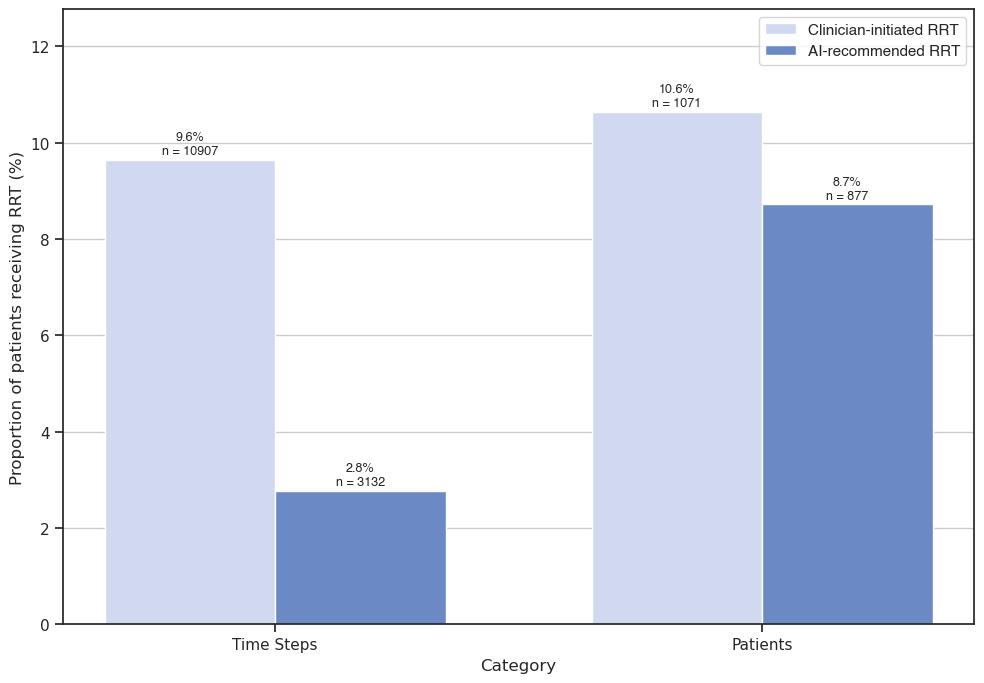

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

sns.set(style="ticks", palette="pastel")


state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

# Apply the mapping to each record's state to get AI's action
records['ai_action'] = records['state'].map(state_to_optimal_action)

# Validate the mapping
if records['ai_action'].isnull().any():
    missing_states = records[records['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

# ------------------------
# Step 3: Aggregate Data at Patient Level
# ------------------------
# Replace action -1 with 0 (assuming -1 represents 'No RRT')
records['action'] = records['action'].replace(-1, 0)

# Aggregate actions and outcomes at the patient level
patient_actions = records.groupby('icustayid').agg({
    'action': lambda x: int((x == 1).any()),        # Clinician administered RRT at any time
    'ai_action': lambda x: int((x == 1).any()),     # AI recommends RRT at any time
    'outcome': 'first'                              # Patient outcome (assumed consistent across time steps)
}).reset_index()

# Rename columns for clarity
patient_actions.rename(columns={'action': 'clinician_rrt', 'ai_action': 'ai_rrt'}, inplace=True)

# ------------------------
# Step 4: Compute Action Distributions
# ------------------------
# Time Steps Action Distribution
# Clinician
clinician_time_steps_rrt = (records['action'] == 1).sum()
total_time_steps = len(records)
clinician_time_steps_proportion = clinician_time_steps_rrt / total_time_steps*100

# AI
ai_time_steps_rrt = (records['ai_action'] == 1).sum()
ai_time_steps_proportion = ai_time_steps_rrt / total_time_steps*100

# Patient-Level Action Distribution
# Clinician
clinician_patient_rrt = patient_actions['clinician_rrt'].sum()
total_patients = len(patient_actions)
clinician_patient_proportion = clinician_patient_rrt / total_patients*100

# AI
ai_patient_rrt = patient_actions['ai_rrt'].sum()
ai_patient_proportion = ai_patient_rrt / total_patients*100

# ------------------------
# Step 5: Prepare Data for Plotting
# ------------------------
# Organize the data into a dictionary for easier handling
plot_data = {
    'Time Steps': {
        'Clinician-initiated RRT': (clinician_time_steps_proportion, clinician_time_steps_rrt),
        'AI-recommended RRT': (ai_time_steps_proportion, ai_time_steps_rrt)
    },
    'Patients': {
        'Clinician-initiated RRT': (clinician_patient_proportion, clinician_patient_rrt),
        'AI-recommended RRT': (ai_patient_proportion, ai_patient_rrt)
    }
}

categories = list(plot_data.keys())  # ['Time Steps', 'Patients']
methods = ['Clinician-initiated RRT', 'AI-recommended RRT']

# ------------------------
# Step 6: Plot Combined Action Distributions
# ------------------------
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams['font.family'] = 'Helvetica'
# ------------------------
# Set bar width and positions
bar_width = 0.35
index = np.arange(len(categories))  # [0, 1]

# Extract data for plotting
clinician_values = [plot_data[cat]['Clinician-initiated RRT'][0] for cat in categories]
ai_values = [plot_data[cat]['AI-recommended RRT'][0] for cat in categories]

clinician_counts = [plot_data[cat]['Clinician-initiated RRT'][1] for cat in categories]
ai_counts = [plot_data[cat]['AI-recommended RRT'][1] for cat in categories]

colors = {
    
    'Clinician-initiated RRT': '#d0d9f0',          # Keeps the calming and professional feel
    'AI-recommended RRT': '#6b8ac5'                     # Replaces 'salmon' with a trustworthy color
}

# Create bars
bars1 = ax.bar(index - bar_width/2, clinician_values, bar_width, label='Clinician-initiated RRT', color=colors['Clinician-initiated RRT'])
bars2 = ax.bar(index + bar_width/2, ai_values, bar_width, label='AI-recommended RRT', color=colors['AI-recommended RRT'])

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Category')
ax.set_ylabel('Proportion of patients receiving RRT (%)')
ax.set_xticks(index)
ax.set_xticklabels(categories)
ax.legend()

# Function to add percentage and count labels on top of each bar
def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        # Calculate the position for the annotation
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Add percentage and count labels to each bar
add_percentage_count_labels(bars1, clinician_counts)
add_percentage_count_labels(bars2, ai_counts)

# Add grid for better readability
ax.yaxis.grid(True)

# ------------------------
# Step 7: Adjust Y-axis Limits to Accommodate Annotations
# ------------------------
# Find the maximum bar height
max_bar = max(max(clinician_values, ai_values))
# Set y-axis limit to 1.2 times the maximum bar height or at least 1.0
y_max = max_bar * 1.2 if max_bar * 1.2 < 100 else 100

ax.set_ylim(0, y_max)


# Adjust layout to make room for the annotations
plt.tight_layout(rect=[0, 0.25, 1, 0.95])

# Change the default font to Helvetica

# Step 9: Display the Plot
# ------------------------
plt.show()

# ------------------------
fig_path = os.path.join(output_dir, "evaluation_results")
os.makedirs(fig_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(fig_path, "AKH_actions_timesteps.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "AKH_actions_timesteps.eps"))
plt.close(fig)


In [79]:
optimal_actions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/tmp/ipykernel_2809326/147252300.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  action_distributions_sofa = patient_rrt.groupby('SOFA_group').agg(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


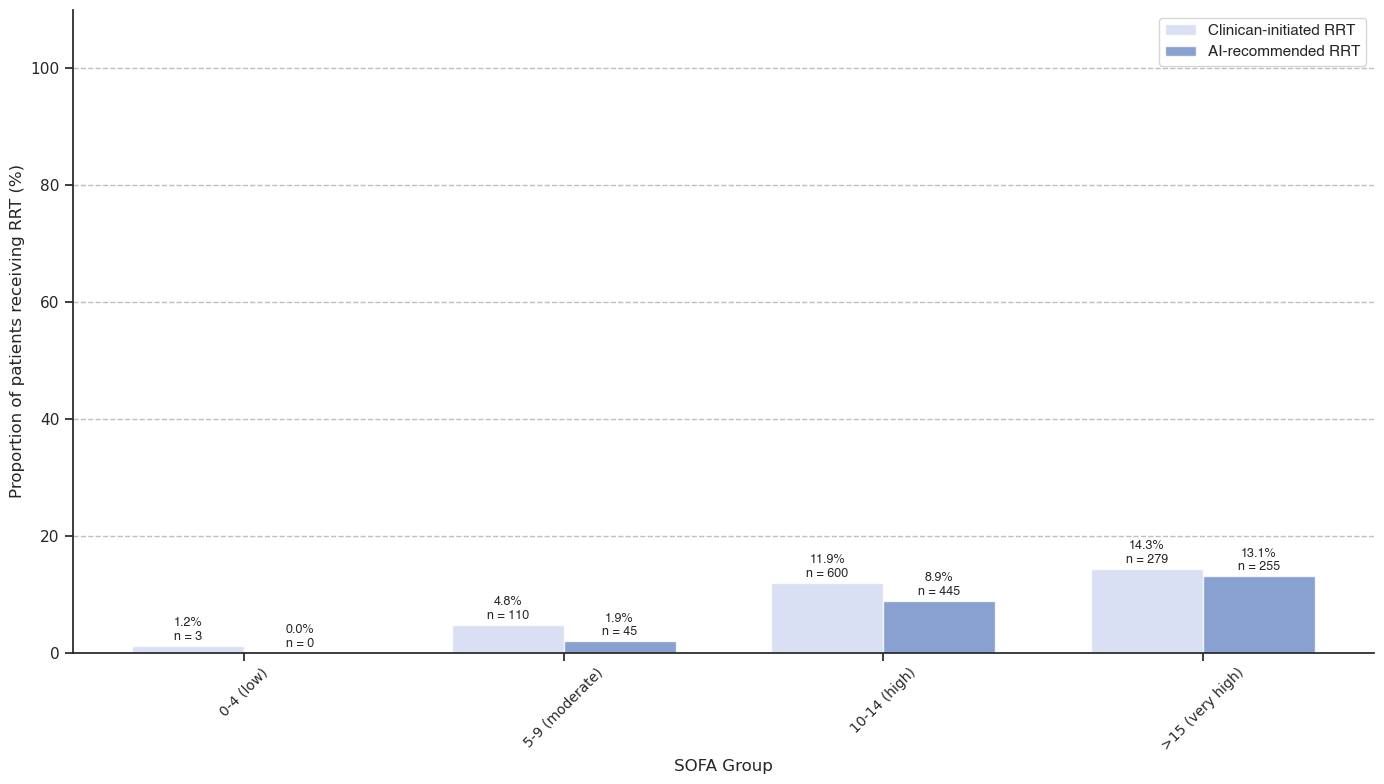

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Make sure to import os if not already

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming `full_data_raw` is your DataFrame containing the ICU patient data
# and `optimal_actions` is a list or array of optimal actions mapped by state.

# ===========================
# 1. Create a Mapping from State to AI's Optimal Action
# ===========================
sns.set(style="ticks", palette="pastel")
state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}

# ===========================
# 2. Aggregate Data Per Patient to Identify RRT Occurrences
# ===========================

# Define what constitutes an RRT action
# Assuming that 'action' and 'ai_action' are numerical, where >= 0.5 indicates RRT
RRT_THRESHOLD = 0.5

# First, map AI actions based on state for all records
full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)

# Validate the mapping
if full_data_raw['ai_action'].isnull().any():
    missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
    raise ValueError(f"Missing optimal actions for states: {missing_states}")

# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x >= RRT_THRESHOLD).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x >= RRT_THRESHOLD).any()),
    max_SOFA=('SOFA', 'max')
).reset_index()

# ===========================
# 3. Categorize SOFA Scores
# ===========================

# Define SOFA groups
bins = [0, 4, 9, 14, 20]
labels = ['0-4 (low)', '5-9 (moderate)', '10-14 (high)', '>15 (very high)']
patient_rrt['SOFA_group'] = pd.cut(patient_rrt['max_SOFA'], bins=bins, labels=labels, include_lowest=True)

# Handle any SOFA scores outside the defined bins
if patient_rrt['SOFA_group'].isnull().any():
    print("Warning: Some patients have SOFA scores outside the defined bins. These will be excluded from grouping.")

    patient_rrt = patient_rrt.dropna(subset=['SOFA_group'])


# Group by SOFA_group and compute proportions and counts
action_distributions_sofa = patient_rrt.groupby('SOFA_group').agg(
    clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
    ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
    patient_count=('icustayid', 'count')  # Count of patients per SOFA group
).reset_index()

# Calculate counts for Clinician RRT and AI RRT based on proportions
action_distributions_sofa['clinician_rrt_count'] = (action_distributions_sofa['clinician_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)
action_distributions_sofa['ai_rrt_count'] = (action_distributions_sofa['ai_rrt_proportion'] * action_distributions_sofa['patient_count']).round().astype(int)

# ===========================
# 5. Visualization
# ===========================

# Parameters for the plot
SOFA_groups = action_distributions_sofa['SOFA_group']
n_groups = len(SOFA_groups)
index = np.arange(n_groups)
bar_width = 0.35  # Width of the bars
opacity = 0.8

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Change the default font to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

# Plotting the "Clinician-initiated RRT" and "AI-recommended RRT" bars
rects1 = ax.bar(index - bar_width/2, action_distributions_sofa['clinician_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#d0d9f0', label='Clinican-initiated RRT')

rects2 = ax.bar(index + bar_width/2, action_distributions_sofa['ai_rrt_proportion']*100,
                bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('SOFA Group', fontsize=12)
ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

ax.set_ylim(0, 110)  # Increased to accommodate patient counts

# Adding grid lines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Removing top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding legend
ax.legend()

def add_percentage_count_labels(bars, counts):
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        # Calculate the position for the annotation
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 2),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Apply the function to both sets of bars
add_percentage_count_labels(rects1, action_distributions_sofa['clinician_rrt_count'])
add_percentage_count_labels(rects2, action_distributions_sofa['ai_rrt_count'])

# Modify x-ticks to have only 3 ticks
desired_ticks = 4

if n_groups > desired_ticks:
    # Select first, second, and last tick positions
    tick_indices = [0, 1, n_groups - 1]
    tick_labels = [SOFA_groups[i] for i in tick_indices]
    ax.set_xticks(index[tick_indices])
    ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
else:
    # If 3 or fewer groups, display all
    ax.set_xticks(index)
    ax.set_xticklabels(SOFA_groups, rotation=45, fontsize=10)

# Improve layout to prevent clipping of tick-labels and annotations
plt.tight_layout()

fig.savefig(os.path.join(fig_path, "AKH_SOFA_actions.png"), dpi=300)
fig.savefig(os.path.join(fig_path, "AKH_SOFA_actions.eps"))
# Display the plot
plt.show()


In [81]:
full_data_raw.loc[full_data_raw['ai_action'].isnull(),:]

Empty DataFrame
Columns: [output_step, SOFA, cumulated_balance, Creatinine, Platelets_count, Chloride, BUN, Anion_Gap, Calcium, input_total, WBC_count, Total_bili, Phosphorous, O2flow, output_total, Weight_kg, RASS, Sodium, Temp_C, age, max_dose_vaso, PAWmean, GCS, SGOT, PT, PTT, RBC_count, LDH, Ht, RR, HCO3, SpO2, Ionised_Ca, Hb, FiO2_1, SGPT, Shock_Index, Glucose, HR, MinuteVentil, RRT, bloc, icustayid, state, action, outcome, reward, ai_action]
Index: []

/tmp/ipykernel_2809326/1209705293.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)


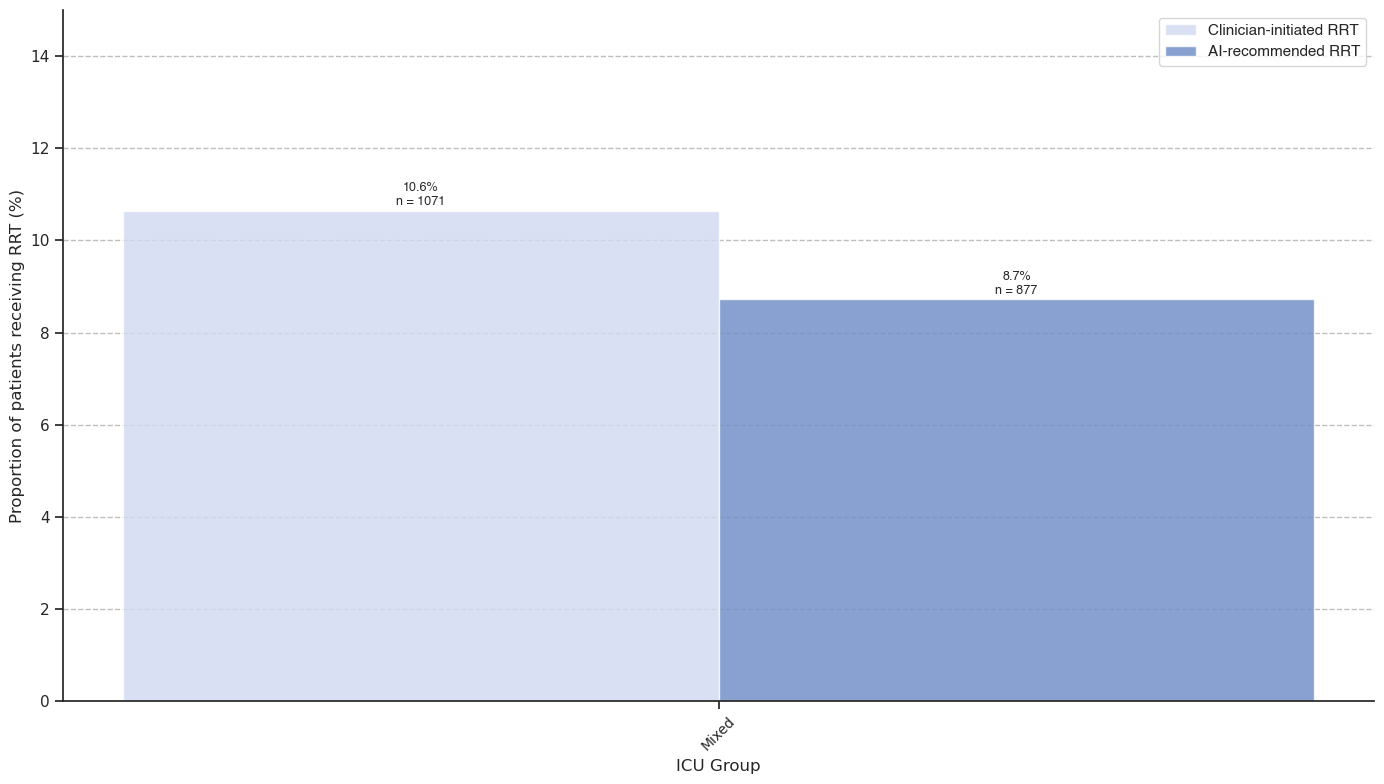

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icustays_csv_path):
    sns.set(style="ticks", palette="pastel")
    """
    Analyze and visualize RRT occurrences by ICU group for Clinician and AI actions.

    Parameters:
    - full_data_raw (pd.DataFrame): DataFrame containing ICU patient data with columns such as
                                     'icustayid', 'state', 'action', 'SOFA', etc.
    - optimal_actions (list or np.array): List/array where each index corresponds to a state,
                                          representing the AI's optimal action.
    - icustays_csv_path (str): File path to the 'icustays.csv' file.

    Returns:
    - None: Displays a bar plot comparing Clinician and AI-recommended RRT occurrences by ICU group.
    """
    
    # ===========================
    # 1. Create a Mapping from State to AI's Optimal Action
    # ===========================
    
    # Ensure that 'optimal_actions' is defined and corresponds to all possible states
    state_to_optimal_action = {state: action for state, action in enumerate(optimal_actions)}
    
    # ===========================
    # 2. Load and Merge ICU Stays Data
    # ===========================

    hosp1 = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/Lorenz in Hospital Deceased und Clinical Units.xlsx', sheet_name=0) 
    hosp2 = pd.read_excel('/home/lkapral/RRT_mimic_iv/data/AKH/Lorenz in Hospital Deceased und Clinical Units.xlsx', sheet_name=1) 
    hosp1['icustayid'] = hosp1['encounterId'] 
    
    full_data_raw = full_data_raw.merge(hosp1[['icustayid', 'clinicalUnitId']], on='icustayid', how='left')
    full_data_raw = full_data_raw.merge(hosp2[['clinicalUnitId', 'displayLabel']], on='clinicalUnitId', how='left')
    
    # ===========================
    # 3. Define and Map ICU Groups
    # ===========================
    
    # Define ICU group mappings
    careunit_to_group = {
        'OP-Gruppe-5': 'Mixed',
        '9D-Intensiv': 'Mixed',
        '13B1': 'Mixed',
        '13C1': 'Mixed',
        'NCH-Intensiv': 'Mixed',
        'OP-Gruppe-2': 'Mixed',
        '13I1': 'Mixed',
        '13C2': 'Mixed',
        'NCH-OP': 'Mixed',
        'OP-Gruppe-3': 'Mixed',
        'UCH-OP': 'Mixed',
        'AWR-3': 'Mixed',
        'OP-Gruppe-7': 'Mixed',
        '13C3': 'Mixed',
        'OP-Gruppe-1': 'Mixed',
        'UCH-Schockraum': 'Mixed',
        'UCH-AWR': 'Mixed',
        'AWR-1-HTG': 'Mixed',
        'Prä-Anästhesie': 'Mixed',
        'OP-Gruppe-4': 'Mixed',
        'AWR-1': 'Mixed',
        '9D-OP': 'Mixed',
        'A7-Intensiv': 'Mixed',
        'AWR-2': 'Mixed',
        'AWR-7': 'Mixed',
        '13B-HTG': 'Medical',
        'A6-Intensiv':'Mixed',
        'AWR-2-Intensiv': 'Mixed',
        'KiOPZ-AWR': 'Mixed',
        'A7-IMC': 'Mixed',
        'KiOPZ-OP': 'Mixed',
        'Schmerzklinik': 'Mixed'
    }

    # Map 'first_careunit' to 'ICU_group'
    full_data_raw['ICU_group'] = full_data_raw['displayLabel'].map(careunit_to_group)
    
    # Handle any missing ICU groups
    if full_data_raw['ICU_group'].isnull().any():
        missing_careunits = full_data_raw[full_data_raw['ICU_group'].isnull()]['displayLabel'].unique()
        print(f"Warning: The following care units are not mapped to an ICU group and will be excluded: {missing_careunits}")
        # Exclude records with unmapped 'first_careunit'
        full_data_raw = full_data_raw.dropna(subset=['ICU_group'])
    
    # ===========================
    # 4. Map States to AI Actions
    # ===========================
    
    # Map the state to AI's action for all records
    full_data_raw['ai_action'] = full_data_raw['state'].map(state_to_optimal_action)
    
    # Validate the mapping
    if full_data_raw['ai_action'].isnull().any():
        missing_states = full_data_raw[full_data_raw['ai_action'].isnull()]['state'].unique()
        raise ValueError(f"Missing optimal actions for states: {missing_states}")
    
    # ===========================
    # 5. Aggregate Data Per Patient to Identify RRT Occurrences
    # ===========================
    
    # Identify if RRT was ever performed by Clinicians and AI for each patient
    patient_rrt = full_data_raw.groupby('icustayid').agg(
        clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
        ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
        ICU_group=('ICU_group', 'first')  # Assuming ICU_group is consistent per patient
    ).reset_index()
    
    # ===========================
    # 6. Compute Action Distributions and Patient Counts
    # ===========================
    
    # Group by ICU_group and compute proportions and counts
    action_distributions = patient_rrt.groupby('ICU_group').agg(
        clinician_rrt_proportion=('clinician_rrt_occurred', 'mean'),
        ai_rrt_proportion=('ai_rrt_occurred', 'mean'),
        patient_count=('icustayid', 'count')  # Count of patients per ICU group
    ).reset_index()
    
    # Calculate counts for Clinician-initiated RRT and AI-recommended RRT based on proportions
    action_distributions['clinician_rrt_count'] = (action_distributions['clinician_rrt_proportion'] * action_distributions['patient_count']).round().astype(int)
    action_distributions['ai_rrt_count'] = (action_distributions['ai_rrt_proportion'] * action_distributions['patient_count']).round().astype(int)
    
    # ===========================
    # 7. Visualization
    # ===========================
    
    # Parameters for the plot
    ICU_groups = action_distributions['ICU_group']
    n_groups = len(ICU_groups)
    index = np.arange(n_groups)
    bar_width = 0.35  # Width of the bars
    opacity = 0.8
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    # Change the default font to Helvetica
    plt.rcParams['font.family'] = 'Helvetica'

    
    rects1 = ax.bar(index - bar_width/2, action_distributions['clinician_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#d0d9f0', label='Clinician-initiated RRT')
    
    rects2 = ax.bar(index + bar_width/2, action_distributions['ai_rrt_proportion']*100,
                    bar_width, alpha=opacity, color='#6b8ac5', label='AI-recommended RRT')
    
    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel('ICU Group', fontsize=12)
    ax.set_ylabel('Proportion of patients receiving RRT (%)', fontsize=12)

    ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
    ax.set_ylim(0, 15)  # Increased to accommodate patient counts
    
    # Adding grid lines for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
    
    # Removing top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    desired_ticks = 3
    
    if n_groups > desired_ticks:
        # Select first, second, and last tick positions
        tick_indices = [0, 1, n_groups - 1]
        tick_labels = [ICU_groups[i] for i in tick_indices]
        ax.set_xticks(index[tick_indices])
        ax.set_xticklabels(tick_labels, rotation=45, fontsize=10)
    else:
        # If 3 or fewer groups, display all
        ax.set_xticks(index)
        ax.set_xticklabels(ICU_groups, rotation=45, fontsize=10)
        
        # Adding legend
        ax.legend()
    
    def add_percentage_count_labels(bars, counts):
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            # Calculate the position for the annotation
            ax.annotate(f'{round(height,1)}%\nn = {count}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),  # 5 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9)
    
    # Apply the function to both sets of bars
    add_percentage_count_labels(rects1, action_distributions['clinician_rrt_count'])
    add_percentage_count_labels(rects2, action_distributions['ai_rrt_count'])
    
    # Improve layout to prevent clipping of tick-labels and annotations
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    fig.savefig(os.path.join(fig_path, "AKH_ICU_actions.png"), dpi=300)
    fig.savefig(os.path.join(fig_path, "AKH_ICU_actions.eps"))
    return action_distributions

    

icu_stay_id_dir = '/home/lkapral/RRT_mimic_iv/data/icustays.csv'
# ===========================
# 2. Execute the Analysis Function
# ===========================

action_distributions_icu =analyze_rrt_by_icu_group(full_data_raw, optimal_actions, icu_stay_id_dir)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


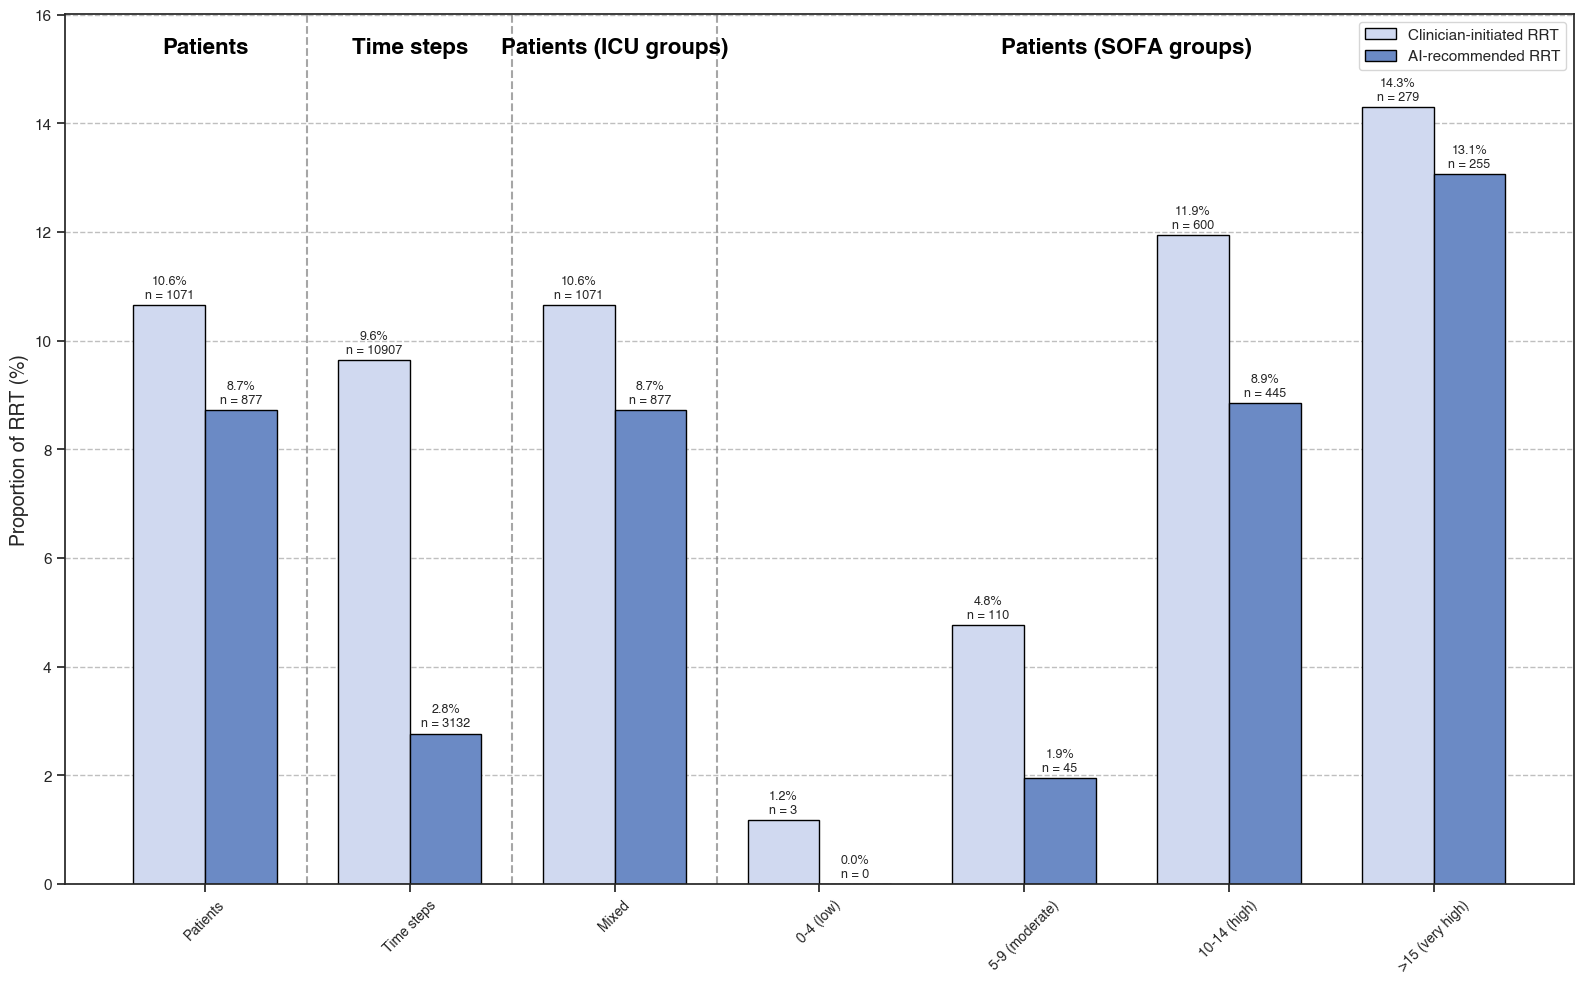

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="ticks", palette="pastel")
plt.rcParams['font.family'] = 'Helvetica'

# ------------------------
# Step 1: Aggregate All Necessary Data
# ------------------------

# Assuming you have already performed the following aggregations:
# 1. Time Steps Action Distribution (clinician_time_steps_proportion, ai_time_steps_proportion)
# 2. Patient-Level Action Distribution (clinician_patient_proportion, ai_patient_proportion)
# 3. SOFA Groups Action Distribution (action_distributions_sofa)
# 4. ICU Groups Action Distribution (action_distributions_icu)

# For demonstration, let's create mock data structures based on your provided code.

# 1. Time Steps
time_steps_data = {
    'Category': ['Time steps'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_time_steps_proportion, ai_time_steps_proportion],
    'Count': [clinician_time_steps_rrt, ai_time_steps_rrt]
}

# 2. Patients
patients_data = {
    'Category': ['Patients'] * 2,
    'Method': ['Clinician-initiated RRT', 'AI-recommended RRT'],
    'Proportion': [clinician_patient_proportion, ai_patient_proportion],
    'Count': [clinician_patient_rrt, ai_patient_rrt]
}

# 3. SOFA Groups
# Assuming 'action_distributions_sofa' DataFrame from SOFA analysis
# with columns: 'SOFA_group', 'clinician_rrt_proportion', 'ai_rrt_proportion', 'clinician_rrt_count', 'ai_rrt_count'

sofa_groups = action_distributions_sofa['SOFA_group'].tolist()
sofa_proportions_clinician = (action_distributions_sofa['clinician_rrt_proportion'] * 100).tolist()
sofa_proportions_ai = (action_distributions_sofa['ai_rrt_proportion'] * 100).tolist()
sofa_counts_clinician = action_distributions_sofa['clinician_rrt_count'].tolist()
sofa_counts_ai = action_distributions_sofa['ai_rrt_count'].tolist()

sofa_data = {
    'Category': sofa_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(sofa_groups) + ['AI-recommended RRT'] * len(sofa_groups),
    'Proportion': sofa_proportions_clinician + sofa_proportions_ai,
    'Count': sofa_counts_clinician + sofa_counts_ai
}

# 4. ICU Groups
# Assuming 'action_distributions_icu' DataFrame from ICU analysis
# with columns: 'ICU_group', 'clinician_rrt_proportion', 'ai_rrt_proportion', 'clinician_rrt_count', 'ai_rrt_count'

icu_groups = action_distributions_icu['ICU_group'].tolist()
icu_proportions_clinician = (action_distributions_icu['clinician_rrt_proportion'] * 100).tolist()
icu_proportions_ai = (action_distributions_icu['ai_rrt_proportion'] * 100).tolist()
icu_counts_clinician = action_distributions_icu['clinician_rrt_count'].tolist()
icu_counts_ai = action_distributions_icu['ai_rrt_count'].tolist()

icu_data = {
    'Category': icu_groups * 2,
    'Method': ['Clinician-initiated RRT'] * len(icu_groups) + ['AI-recommended RRT'] * len(icu_groups),
    'Proportion': icu_proportions_clinician + icu_proportions_ai,
    'Count': icu_counts_clinician + icu_counts_ai
}

# Combine all data into a single DataFrame
# To ensure SOFA comes after ICU, concatenate in the desired order
combined_data = pd.concat([
    pd.DataFrame(time_steps_data),
    pd.DataFrame(patients_data),
    pd.DataFrame(icu_data),
    pd.DataFrame(sofa_data)
], ignore_index=True)

# ------------------------
# Step 2: Plot the Combined Bar Chart
# ------------------------

# Define the desired order of categories
# Remove 'sorted()' to maintain the original order of ICU and SOFA groups
desired_order = ['Patients', 'Time steps'] + icu_groups + sofa_groups

# Reorder the combined_data DataFrame
combined_data['Category'] = pd.Categorical(combined_data['Category'], categories=desired_order, ordered=True)
combined_data = combined_data.sort_values('Category')

# Determine unique categories and methods
unique_categories = combined_data['Category'].cat.categories
unique_methods = combined_data['Method'].unique()

# Number of categories and methods
n_categories = len(unique_categories)
n_methods = len(unique_methods)

# Define bar width and positions
bar_width = 0.35
index = np.arange(n_categories)

# Initialize the plot
fig, ax = plt.subplots(figsize=(16, 10))  # Adjust figsize as needed

# Define colors for each method
colors = {
    'Clinician-initiated RRT': '#d0d9f0',
    'AI-recommended RRT': '#6b8ac5'
}

# Plot each method
for i, method in enumerate(unique_methods):
    # Extract proportions and counts for the current method
    proportions = combined_data[combined_data['Method'] == method]['Proportion'].values
    counts = combined_data[combined_data['Method'] == method]['Count'].values
    
    # Calculate bar positions
    # Center the bars around each category index
    bar_positions = index + (i - n_methods / 2) * bar_width + bar_width / 2
    
    # Create bars
    bars = ax.bar(bar_positions, proportions, bar_width, label=method, color=colors.get(method, '#333333'),  edgecolor='black', linewidth=1 )
    
    # Add annotations
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{round(height,1)}%\nn = {count}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

# Set y-axis label
ax.set_ylabel('Proportion of RRT (%)', fontsize=14)

# Set x-axis labels and positions
ax.set_xticks(index)
ax.set_xticklabels(unique_categories, rotation=45, ha='center', fontsize=10)  # Reduced fontsize to 10

# Add legend
ax.legend()

# Add grid for y-axis
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Adjust y-axis limits to accommodate annotations
y_max = combined_data['Proportion'].max() * 1.12 if combined_data['Proportion'].max() * 1.12 < 100 else 100
ax.set_ylim(0, y_max)

# ------------------------
# Step 3: Add Group Labels Above Categories
# ------------------------

# Define the main groups and their corresponding categories
# Order adjusted to reflect the desired group names and their categories
main_groups = {
    'Patients': ['Patients'],
    'Time steps': ['Time steps'],
    'Patients (ICU groups)': icu_groups,
    'Patients (SOFA groups)': sofa_groups
}

# Calculate the starting and ending indices for each main group
group_boundaries = {}
current_start = 0
for group, categories in main_groups.items():
    num_categories = len(categories)
    group_boundaries[group] = (current_start, current_start + num_categories - 1)
    current_start += num_categories

# Add group labels
for group, (start, end) in group_boundaries.items():
    # Calculate the center position
    center = (start + end) / 2
    # Adjust the y position based on y_max
    y_pos = y_max * 0.95  # Positioned near the top of the plot
    # Add text
    ax.text(center, y_pos, group, ha='center', va='bottom', fontsize=16, fontweight='bold', color='black')

# Optional: Add spacing above the plot for group labels
plt.subplots_adjust(top=0.85)  # Adjusted to provide more space if needed

# ------------------------
# Step 4: Add Three Vertical Dotted Lines Between Groups
# ------------------------

# Define the positions where the vertical lines should be placed
# After 'Time Steps', after 'Patients', and after 'ICU Groups'

# Calculate the number of categories in each main group
counts = [len(categories) for categories in main_groups.values()]

# Cumulative sum to find the end of each group
cumulative_counts = np.cumsum(counts)

# The vertical lines should be placed between groups, i.e., at positions cumulative_counts[:-1]
# Since each category is centered at index positions, the lines should be placed at cumulative_counts - 0.5
separator_positions = cumulative_counts[:-1] - 0.5

# Add vertical dotted lines
for pos in separator_positions:
    ax.axvline(x=pos, linestyle='--', color='grey', alpha=0.7)

# ------------------------
# Step 5: Improve X-axis Labels (Wrapping Long Labels)
# ------------------------

# If labels are too long, consider abbreviating or wrapping them
# For example, using multi-line labels

def wrap_label(label, width=15):
    if len(label) > width:
        return '\n'.join([label[i:i+width] for i in range(0, len(label), width)])
    else:
        return label

# Apply label wrapping
wrapped_labels = [wrap_label(label) for label in unique_categories]
ax.set_xticklabels(wrapped_labels, rotation=45, ha='center', fontsize=10)  # fontsize reduced to 10

# ------------------------
# Step 6: Final Adjustments and Layout
# ------------------------

# Tight layout to prevent clipping
plt.tight_layout()

# ------------------------
# Step 7: Save and Display the Plot
# ------------------------




# Save the figure in desired formats
fig.savefig(os.path.join(fig_path, "combined_AKH_actions.png"), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(fig_path, "combined_AKH_actions.eps"), bbox_inches='tight' )

# Display the plot
plt.show()


In [84]:
action_counts = np.bincount(actions, minlength=2)

In [85]:
import pandas as pd

# Assuming 'df' is your DataFrame
df = full_data_raw

# Group where action is at least 1
action_at_least_1 = df[df['action'] >= 1].groupby('icustayid')['bloc'].max().reset_index()
action_at_least_1['group'] = 'at_least_1'

# Group where action is always 0
action_always_0 = df.groupby('icustayid').filter(lambda x: (x['action'] == 0).all())
action_always_0 = action_always_0.groupby('icustayid')['bloc'].max().reset_index()
action_always_0['group'] = 'always_0'

# Combine both groups into a single DataFrame for comparison
comparison_df = pd.concat([action_at_least_1, action_always_0])

# Optional: Pivot for easier comparison
pivot_df = comparison_df.pivot(index='icustayid', columns='group', values='bloc')

print(pivot_df)


group      always_0  at_least_1
icustayid                      
62867           NaN        15.0
74259           NaN         8.0
77871           NaN        19.0
78575           NaN        19.0
81145           NaN        19.0
...             ...         ...
491675          4.0         NaN
491870          3.0         NaN
491894          6.0         NaN
491999         16.0         NaN
492037          3.0         NaN

[10059 rows x 2 columns]


In [86]:
all_patients = full_data_raw.groupby('icustayid')['bloc'].max().reset_index()
all_patients['group'] = 'always_0'

In [87]:
all_patients.describe()

icustayid          bloc
count   10059.000000  10059.000000
mean   283070.682473     11.238592
std    117613.789649      6.671610
min     62867.000000      2.000000
25%    179342.000000      5.000000
50%    280514.000000      9.000000
75%    386005.500000     20.000000
max    492037.000000     20.000000

Concordance Rate between clinician and AI bot: 92.27%


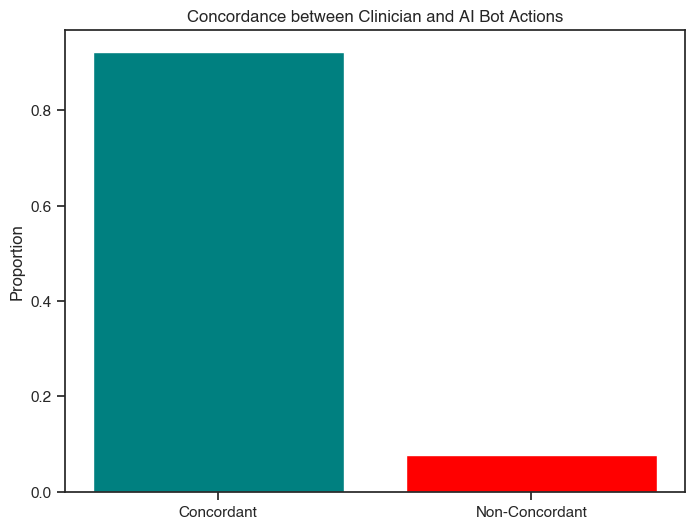

In [88]:
# Compute AI bot's recommended actions
optimal_actions = model.Q.argmax(axis=1)  # Optimal action per state

# Map states to AI bot's recommended actions
ai_recommended_actions = optimal_actions[states]

# Determine concordance
concordant = (actions == ai_recommended_actions).astype(int)

# Calculate concordance rate
concordance_rate = np.mean(concordant)
print(f"Concordance Rate between clinician and AI bot: {concordance_rate:.2%}")

# Add concordance information to records
records['concordant'] = concordant

# Visualize Concordance Distribution
fig_concordance = plt.figure(figsize=(8, 6))
concordance_counts = np.bincount(concordant, minlength=2)
concordance_percentages = concordance_counts / len(concordant)

plot_concordance = concordance_percentages.copy()
plot_concordance[0] = concordance_percentages[1]
plot_concordance[1] = concordance_percentages[0]

plt.bar(['Concordant', 'Non-Concordant'], plot_concordance, color=['teal', 'red'])
plt.ylabel('Proportion')
plt.title('Concordance between Clinician and AI Bot Actions')
plt.show()


Selected Example Patient ICU Stay ID: 179786


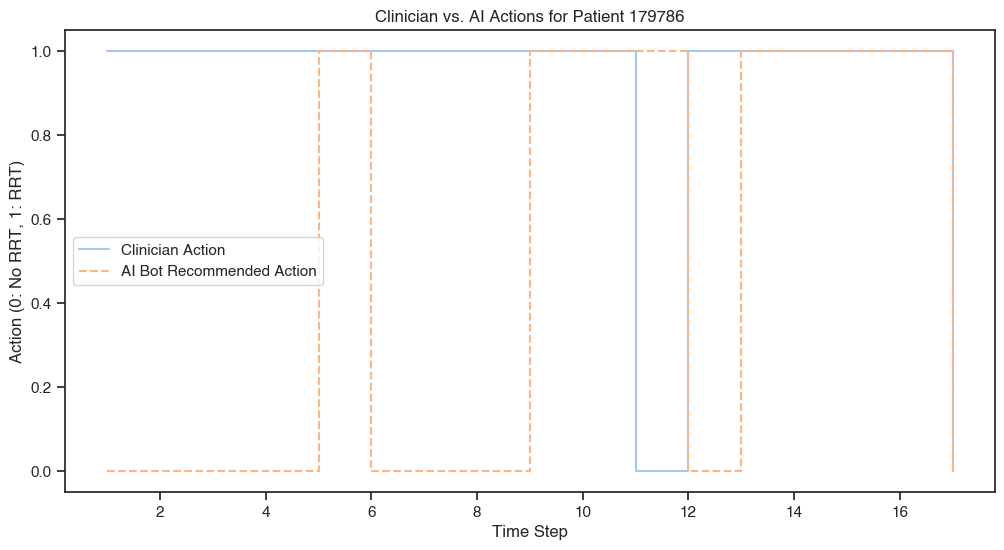

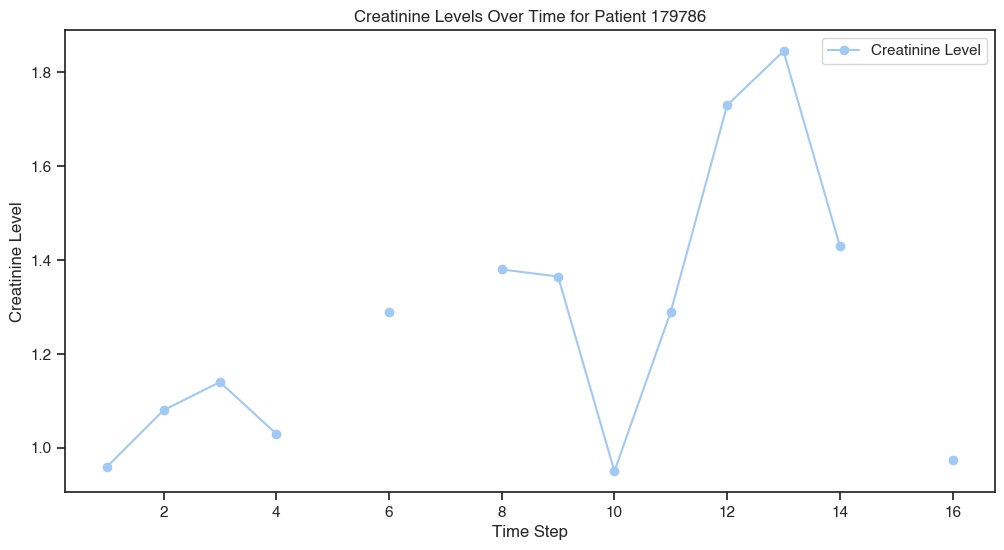

In [89]:
# Merge AKHraw and metadata on index or a common key
merged_df = full_data_raw

# Now, 'icustayid' and 'action' are both in merged_df
# Identify patients who received RRT
rrt_patients = merged_df.loc[merged_df['action'] == 1, C_ICUSTAYID].unique()

if len(rrt_patients) > 0:
    # Select an example patient
    example_patient_id = np.random.choice(rrt_patients)
    print(f"Selected Example Patient ICU Stay ID: {example_patient_id}")

    # Extract patient data
    patient_data = merged_df[merged_df[C_ICUSTAYID] == example_patient_id].copy()

    # Get time steps
    time_steps = patient_data[C_BLOC].values

    # Clinician's actions
    clinician_actions = patient_data['action'].values

    # States
    patient_indices = merged_df[C_ICUSTAYID] == example_patient_id
    patient_states = states[patient_indices]

    # AI bot's recommended actions
    ai_actions = optimal_actions[patient_states]

    # Plot clinician vs. AI actions over time
    fig_patient = plt.figure(figsize=(12, 6))
    plt.step(time_steps, clinician_actions, label='Clinician Action', where='post')
    plt.step(time_steps, ai_actions, label='AI Bot Recommended Action', where='post', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Action (0: No RRT, 1: RRT)')
    plt.title(f'Clinician vs. AI Actions for Patient {example_patient_id}')
    plt.legend()
    plt.show()

    # Optionally, plot key physiological variables (e.g., 'Creatinine')
    if 'Creatinine' in patient_data.columns:
        fig_creatinine = plt.figure(figsize=(12, 6))
        plt.plot(time_steps, patient_data['Creatinine'], label='Creatinine Level', marker='o')
        plt.xlabel('Time Step')
        plt.ylabel('Creatinine Level')
        plt.title(f'Creatinine Levels Over Time for Patient {example_patient_id}')
        plt.legend()
        plt.show()
else:
    print("No patients with RRT found in the dataset.")

    
    

Clinician-initiated RRT Mortality Rate: 30.94%
AI Bot RRT Mortality Rate: 34.39%
Chi-squared Test: chi2 = 13.9741, p-value = 0.0002


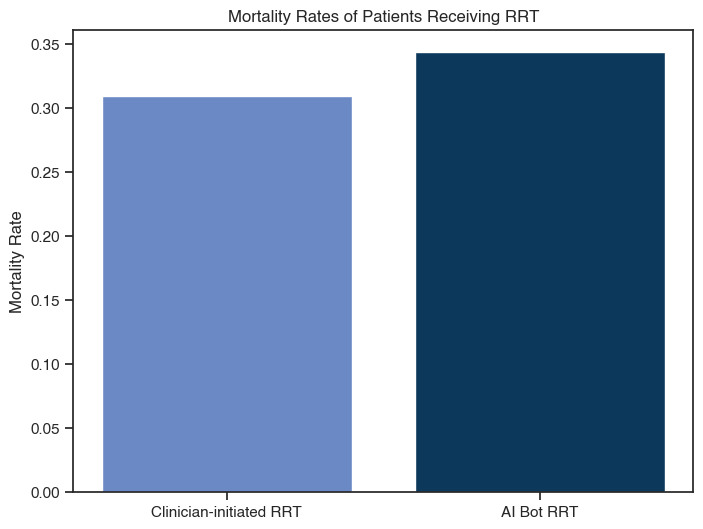

In [90]:
from scipy.stats import chi2_contingency

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)
# Group 1: Patients who received RRT as per clinician
clinician_rrt_indices = np.where(actions == 1)[0]
clinician_rrt_mortality = outcomes[clinician_rrt_indices]
clinician_rrt_mortality_rate = np.mean(clinician_rrt_mortality)
print(f"Clinician-initiated RRT Mortality Rate: {clinician_rrt_mortality_rate:.2%}")

# Group 2: Patients who would receive RRT as per AI bot
ai_rrt_indices = np.where(ai_recommended_actions == 1)[0]
ai_rrt_mortality = outcomes[ai_rrt_indices]
ai_rrt_mortality_rate = np.mean(ai_rrt_mortality)
print(f"AI Bot RRT Mortality Rate: {ai_rrt_mortality_rate:.2%}")

# Statistical Test
# Prepare contingency table
clinician_rrt_deaths = np.sum(clinician_rrt_mortality)
clinician_rrt_survivors = len(clinician_rrt_mortality) - clinician_rrt_deaths
ai_rrt_deaths = np.sum(ai_rrt_mortality)
ai_rrt_survivors = len(ai_rrt_mortality) - ai_rrt_deaths

contingency_table = np.array([
    [clinician_rrt_deaths, clinician_rrt_survivors],
    [ai_rrt_deaths, ai_rrt_survivors]
])

chi2, p_value, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared Test: chi2 = {chi2:.4f}, p-value = {p_value:.4f}")



# Visualization
fig_mortality = plt.figure(figsize=(8, 6))
mortality_rates = [clinician_rrt_mortality_rate, ai_rrt_mortality_rate]
labels = ['Clinician-initiated RRT', 'AI Bot RRT']
plt.bar(labels, mortality_rates, color=['#6b8ac5', '#0c385c'])
plt.ylabel('Mortality Rate')
plt.title('Mortality Rates of Patients Receiving RRT')
plt.show()


In [91]:

# # Get unique states
# unique_states = np.unique(states)

# # Initialize lists to store proportions
# clinician_action_proportions = []
# ai_action_proportions = []

# for state in unique_states:
#     # Clinician actions in this state
#     clinician_actions_in_state = actions[states == state]
#     clinician_action_counts = np.bincount(clinician_actions_in_state, minlength=2)
#     total_clinician_actions = clinician_action_counts.sum()
#     if total_clinician_actions > 0:
#         clinician_action_prop = clinician_action_counts / total_clinician_actions
#     else:
#         clinician_action_prop = np.array([0, 0])  # Or np.nan, depending on preference
#     clinician_action_proportions.append(clinician_action_prop)
    
#     # AI actions in this state
#     ai_actions_in_state = ai_recommended_actions[states == state]
#     ai_action_counts = np.bincount(ai_actions_in_state, minlength=2)
#     total_ai_actions = ai_action_counts.sum()
#     if total_ai_actions > 0:
#         ai_action_prop = ai_action_counts / total_ai_actions
#     else:
#         ai_action_prop = np.array([0, 0])
#     ai_action_proportions.append(ai_action_prop)

# # Convert to arrays
# clinician_action_proportions = np.array(clinician_action_proportions)
# ai_action_proportions = np.array(ai_action_proportions)

# # Plotting
# num_states = len(unique_states)
# num_cols = 5  # You can adjust this as needed
# num_rows = int(np.ceil(num_states / num_cols))

# fig_state_actions = plt.figure(figsize=(3 * num_cols, 3 * num_rows))

# for idx, state in enumerate(unique_states):
#     plt.subplot(num_rows, num_cols, idx + 1)
#     bar_width = 0.35
#     index = np.arange(2)
    
#     # Plot clinician action proportions
#     plt.bar(index, clinician_action_proportions[idx], bar_width, label='Clinician')
#     # Plot AI action proportions
#     plt.bar(index + bar_width, ai_action_proportions[idx], bar_width, label='AI Bot')
    
#     plt.title(f'State {state}', fontsize=10)
#     plt.xticks(index + bar_width / 2, ['No RRT', 'RRT'], fontsize=8)
#     plt.yticks(fontsize=8)
#     plt.ylim(0, 1)
    
#     # Add legend only once
#     if idx == 0:
#         plt.legend(fontsize=8)

# plt.tight_layout()
# plt.show()


In [92]:
metadata.columns

Index(['bloc', 'icustayid', 'outcome'], dtype='object')

In [93]:
AKHraw[metadata.columns] = metadata

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.metrics import confusion_matrix

# --- Data Preparation ---

# Assuming all necessary data are already defined:
# model, stay_ids, actions, states, blocs, metadata, outcomes, full_data_raw, C_ICUSTAYID, fig_path

# 1. Compute AI's actions for each state
optimal_actions = model.Q.argmax(axis=1)

# 2. Use the new grouping approach based on full_data_raw:
#    Identify if RRT was ever performed by Clinicians and suggested by the AI for each patient.
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

# Remove any potential NaN values after mapping
confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

# Create a confusion matrix comparing clinician and AI RRT flags.
# Convert boolean flags to integers for the confusion_matrix function.
cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'].astype(int), 
    confusion_data['ai_rrt_occurred'].astype(int), 
    labels=[1, 0]
)

cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)

# Define patient groups based on whether each party ever performed/suggested RRT.
def get_group(row):
    if row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Both RRT'
    elif row['ai_rrt_occurred'] and not row['clinician_rrt_occurred']:
        return 'AI-recommended RRT only'
    elif not row['ai_rrt_occurred'] and row['clinician_rrt_occurred']:
        return 'Clinician-initiated RRT only'
    else:
        return 'Neither RRT'
    
patient_rrt['group'] = patient_rrt.apply(get_group, axis=1)

# 3. Calculate Maximum Bloc per Patient (time to event or censoring)
max_bloc_per_patient = pd.Series(blocs).groupby(stay_ids).max().reset_index()
max_bloc_per_patient.columns = [C_ICUSTAYID, 'max_bloc']

# 4. Determine Global Maximum Bloc (for censoring patients without an event)
global_max_bloc = max_bloc_per_patient['max_bloc'].max()
print(f"Global Maximum Bloc: {global_max_bloc}")

# 5. Assign Survival Time and Event Status
#    Create a dictionary mapping each ICUSTAY_ID to the event (death = 1, survival = 0).
patient_events = {}
unique_patients = np.unique(stay_ids)
for icustay_id in unique_patients:
    event_indices = np.where(metadata[C_ICUSTAYID] == icustay_id)[0]
    if len(event_indices) > 0:
        event = outcomes[event_indices[0]]  # 1 if death occurred, 0 if not
        patient_events[icustay_id] = event
    else:
        patient_events[icustay_id] = np.nan  # Handle missing data appropriately

# 6. Merge Data into a Single DataFrame for Survival Analysis
survival_data = pd.DataFrame({
    C_ICUSTAYID: unique_patients,
    'event': [patient_events[id_] for id_ in unique_patients]
})

# Merge the maximum bloc per patient
survival_data = survival_data.merge(max_bloc_per_patient, on=C_ICUSTAYID, how='left')

# Merge in the patient group information from our new grouping (patient_rrt)
# Make sure the grouping DataFrame has the same patient identifier column name.
survival_data = survival_data.merge(patient_rrt[[C_ICUSTAYID, 'group']], left_on=C_ICUSTAYID, right_on='icustayid', how='left')
#survival_data.drop(columns='icustayid', inplace=True)  # Remove duplicate column if present

# 7. Remove Patients with Missing Events or Group Assignments
survival_data = survival_data.dropna(subset=['event', 'group'])

# 8. Assign Survival Time Based on Event Status
#    If event = 1 (death), use the patient's max_bloc; else, assign a censoring time (e.g., 180 blocs)
survival_data['survival_time'] = np.where(
    survival_data['event'] == 1,
    survival_data['max_bloc'],
    180
)

# Convert survival_time from blocs to days (assuming 1 bloc = 0.5 days; adjust if necessary)
survival_data['time_days'] = survival_data['survival_time'] * 0.5

# 9. Merge additional patient information (e.g., 'SOFA' and 'age') from full_data_raw.
#    Aggregation here assumes these values remain constant per patient.
patient_severity = full_data_raw.groupby(C_ICUSTAYID).agg({
    'age': 'first',   # Use 'first' if age is constant; otherwise, adjust as needed.
    'SOFA': 'first'   # Similarly, adjust for SOFA scores if needed.
}).reset_index()

survival_data = survival_data.merge(patient_severity, on=C_ICUSTAYID, how='left')

# 10. Remove Patients with Missing Severity Data
survival_data = survival_data.dropna(subset=['age', 'SOFA'])

# 11. Define Group Order and Convert 'group' to a Categorical Type
group_order = ['AI-recommended RRT only', 'Both RRT', 'Clinician-initiated RRT only', 'Neither RRT']
survival_data['group'] = pd.Categorical(survival_data['group'], categories=group_order, ordered=True)

# At this point, survival_data is ready for further analysis (e.g., Kaplan-Meier survival analysis)
print("Survival data head:")
print(survival_data.head())

Confusion Matrix:
                   AI: RRT  AI: No RRT
Clinician: RRT         788         283
Clinician: No RRT       89        8899
Global Maximum Bloc: 20
Survival data head:
   icustayid  event  max_bloc                         group  survival_time  \
0      62867      0        20                      Both RRT            180   
1      74259      0        20  Clinician-initiated RRT only            180   
2      77871      0        20                      Both RRT            180   
3      78575      0        20                      Both RRT            180   
4      81145      0        20                      Both RRT            180   

   time_days   age  SOFA  
0       90.0  48.0    18  
1       90.0  35.0     6  
2       90.0  57.0     8  
3       90.0  87.0     9  
4       90.0  55.0     9  


In [95]:
survival_data

icustayid  event  max_bloc                         group  \
0          62867      0        20                      Both RRT   
1          74259      0        20  Clinician-initiated RRT only   
2          77871      0        20                      Both RRT   
3          78575      0        20                      Both RRT   
4          81145      0        20                      Both RRT   
...          ...    ...       ...                           ...   
10054     491675      0         4                   Neither RRT   
10055     491870      0         3                   Neither RRT   
10056     491894      0         6                   Neither RRT   
10057     491999      0        16                   Neither RRT   
10058     492037      0         3                   Neither RRT   

       survival_time  time_days   age  SOFA  
0                180       90.0  48.0    18  
1                180       90.0  35.0     6  
2                180       90.0  57.0     8  
3                180       90.0  87.0     9  
4                180       90.0  55.0     9  
...              ...        ...   ...   ...  
10054            180       90.0  54.0    11  
10055            180       90.0  42.0    10  
10056            180       90.0  72.0     7  
10057            180       90.0  82.0     7  
10058            180       90.0  38.0     5  

[10059 rows x 8 columns]

/tmp/ipykernel_2809326/4279151591.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = survival_data.groupby('group').size()
/tmp/ipykernel_2809326/4279151591.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts = survival_data.groupby('group')['event'].sum()


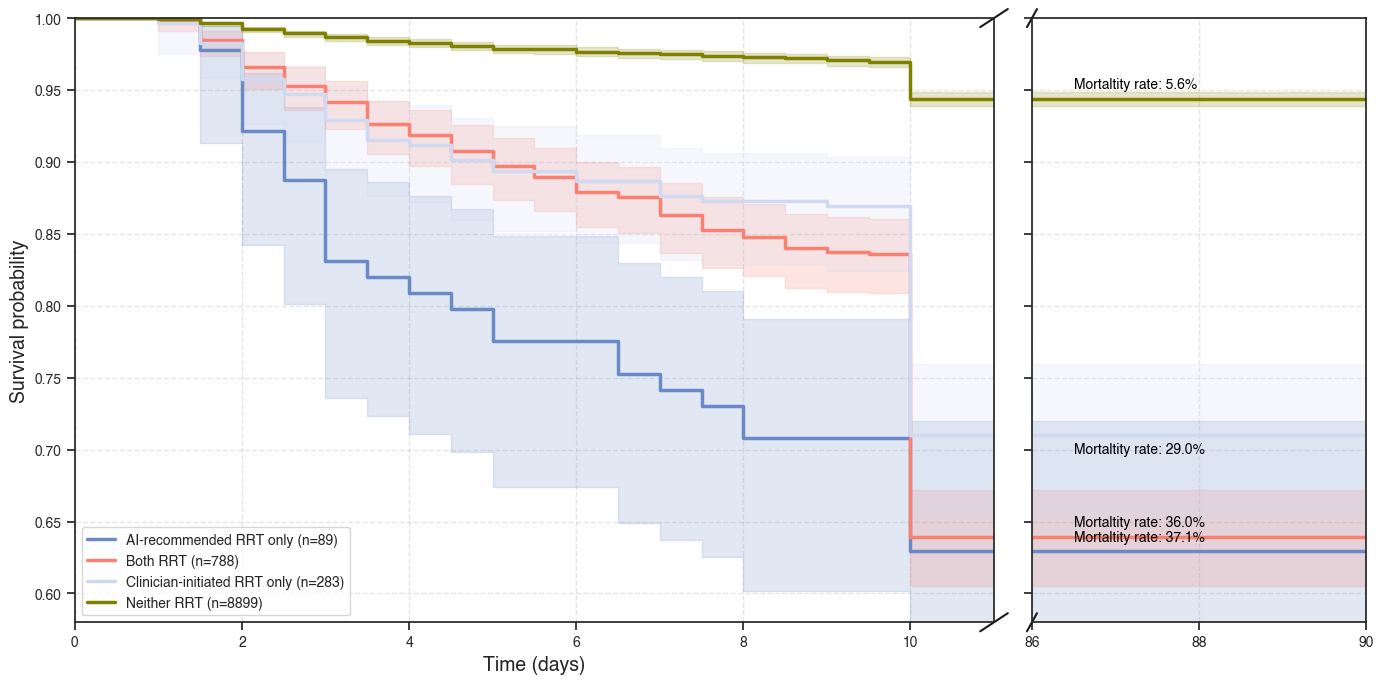

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [96]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from matplotlib.ticker import MultipleLocator

# Assuming 'survival_data', 'group_order', and 'fig_path' are already defined

# 1. Define a More Distinct Color Mapping Using Seaborn's Color Palette
color_mapping = {
    'Neither RRT': 'olive',
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',
    'Clinician-initiated RRT only': '#d0d9f0'
}

CI_mapping = {
    'Neither RRT': True,
    'AI-recommended RRT only': True,
    'Both RRT': True,
    'Clinician-initiated RRT only': True
}

# 1.a. Calculate Group Sizes and Mortality Rates
group_sizes = survival_data.groupby('group').size()
event_counts = survival_data.groupby('group')['event'].sum()
mortality_rates = (event_counts / group_sizes) * 100  # Percentage

# 2. Initialize the Plot with Broken Axes
sns.set(style="ticks")
plt.rcParams['font.family'] = 'Helvetica'

# Adjust the width of the plots to ensure equal day representation
left_days = 11  # Range for the first plot
right_days = 4  # Range for the second plot (85 to 90)

# The width ratio is proportional to the day ranges
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    sharey=True, 
    figsize=(14, 7),
    gridspec_kw={'width_ratios': [left_days, right_days]}
)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.05)

# 3. Fit and Plot Kaplan-Meier Curves for Each Group with Enhanced Styling
kmf_list = []
line_styles = ['-', '-', '-', '-']

for idx, group in enumerate(group_order):
    ix = survival_data['group'] == group
    kmf = KaplanMeierFitter()
    kmf.fit(
        durations=survival_data.loc[ix, 'time_days'],
        event_observed=survival_data.loc[ix, 'event'],
        label=group
    )
    
    color = color_mapping.get(group, 'gray')
    linestyle = line_styles[idx % len(line_styles)]
    ci = CI_mapping.get(group, True)
    
    # Plot on the left axis
    kmf.plot_survival_function(
        ax=ax1,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    
    # Plot on the right axis
    kmf.plot_survival_function(
        ax=ax2,
        ci_show=ci,
        color=color,
        alpha=1,
        ci_alpha=0.2,
        linewidth=2.5,
        linestyle=linestyle
    )
    
    kmf_list.append(kmf)
    
    # 3.a. Annotate Mortality Rates on the Right Plot
    # Positioning the text at the end of the survival curve in the right plot
    # We'll estimate the survival probability at the maximum x-limit of the right plot
    max_day_right = ax2.get_xlim()[1]
    survival_at_max = kmf.survival_function_at_times(max_day_right).values[0]
    mortality_rate = mortality_rates[group]
    
    # Adjust the y-position slightly based on survival probability to avoid overlap
    if(group=='Clinician-initiated RRT only'):
        y_position = survival_at_max - 0.01 if survival_at_max + 0.01 < 1 else survival_at_max - 0.01
    else:
        y_position = survival_at_max + 0.01 if survival_at_max + 0.01 < 1 else survival_at_max - 0.01  
    ax2.text(
        max_day_right - 8,  # Slightly to the right of the plot
        y_position,
        f"Mortaltity rate: {mortality_rate:.1f}%",
        color='black',
        fontsize=10,
        verticalalignment='center',
        horizontalalignment='left'
    )

# 4. Customize Each Subplot

# --- Left Plot: 0 to 12 Days ---
ax1.set_xlim(0, 11)
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Survival probability', fontsize=14)
ax1.set_ylim([0.58, 1.0])

# --- Right Plot: 85 to 90 Days ---
ax2.set_xlim(86, 90)
ax2.set_xlabel('', fontsize=14)
ax2.set_ylim([0.58, 1.0])

# 5. Add Connection Arrows to Indicate Broken Axis
d = .015  # size of diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)

# 6. Place Legend Only on the Left Plot with Number of Patients
# Modify legend labels to include the number of patients
legend_labels = [f"{group} (n={group_sizes[group]})" for group in group_order]
handles, _ = ax1.get_legend_handles_labels()
# Update the legend with new labels
ax1.legend(handles, legend_labels,fontsize=10, title_fontsize=12)

ax2.legend().set_visible(False)
# 7. Enhance Grid for Better Readability
for ax in [ax1, ax2]:
    ax.grid(
        which='major', 
        linestyle='--', 
        color='grey', 
        alpha=0.2,  # More visible grid
        linewidth=1
    )
    ax.xaxis.set_major_locator(MultipleLocator(2))  # Tick every 2 days
    ax.tick_params(axis='both', which='major', labelsize=10)

# 8. Increase Tick Parameters for Better Readability
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

# Save the plot in specified formats
os.makedirs(fig_path, exist_ok=True)
fig.savefig(
    os.path.join(fig_path, "AKH_survival_plot_km_custom_equal_days.png"), 
    dpi=300
)
fig.savefig(
    os.path.join(fig_path, "AKH_survival_plot_km_custom_equal_days.eps")
)

# Close the Figure to Free Memory
plt.close(fig)


In [97]:
# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

Confusion Matrix:
                   AI: RRT  AI: No RRT
Clinician: RRT         788         283
Clinician: No RRT       89        8899


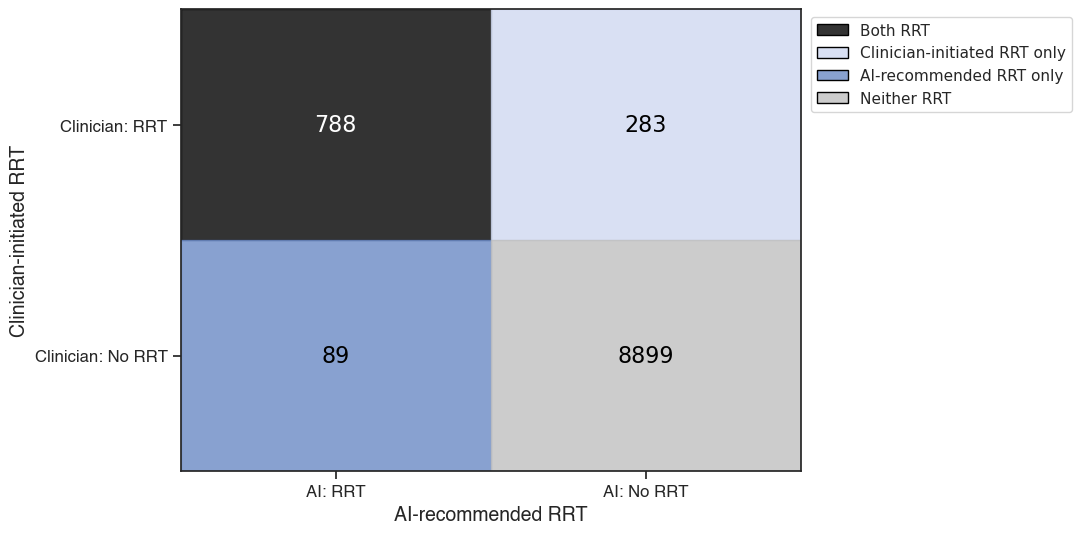

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Accuracy: 0.96
Precision: 0.90
Recall (Sensitivity): 0.74
F1 Score: 0.81


<Figure size 640x480 with 0 Axes>

In [98]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.patches import Patch

# Identify if RRT was ever performed by Clinicians and AI for each patient
patient_rrt = full_data_raw.groupby('icustayid').agg(
    clinician_rrt_occurred=('action', lambda x: (x == 1).any()),
    ai_rrt_occurred=('ai_action', lambda x: (x == 1).any()),
).reset_index()

# Remove any potential NaN values after mapping
confusion_data = patient_rrt.dropna(subset=['ai_rrt_occurred', 'clinician_rrt_occurred'])

cm = confusion_matrix(
    confusion_data['clinician_rrt_occurred'], 
    confusion_data['ai_rrt_occurred'], 
    labels=[1, 0]
)

cm_df = pd.DataFrame(
    cm, 
    index=['Clinician: RRT', 'Clinician: No RRT'], 
    columns=['AI: RRT', 'AI: No RRT']
)

print("Confusion Matrix:")
print(cm_df)

# Desired alpha
desired_alpha = 0.8

# Function to convert hex colors to RGBA with given alpha
def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.strip('#')
    r = int(hex_color[0:2], 16) / 255.0
    g = int(hex_color[2:4], 16) / 255.0
    b = int(hex_color[4:6], 16) / 255.0
    return (r, g, b, alpha)

# Predefine some colors in hex
hex_colors = {
    'Neither RRT': 'C0C0C0',           # silver
    'AI-recommended RRT only': '6b8ac5',
    'Both RRT': '000000',         # black
    'Clinician-initiated RRT only': 'd0d9f0'
}

# Convert to RGBA with desired alpha
rgba_colors = {
    'Neither RRT': hex_to_rgba(hex_colors['Neither RRT'], desired_alpha),
    'AI-recommended RRT only': hex_to_rgba(hex_colors['AI-recommended RRT only'], desired_alpha),
    'Both RRT': hex_to_rgba(hex_colors['Both RRT'], desired_alpha),
    'Clinician-initiated RRT only': hex_to_rgba(hex_colors['Clinician-initiated RRT only'], desired_alpha)
}

# Updated color mapping for the confusion matrix cells
color_mapping = {
    ('Clinician: RRT', 'AI: RRT'): rgba_colors['Both RRT'],               # Both RRT
    ('Clinician: RRT', 'AI: No RRT'): rgba_colors['Clinician-initiated RRT only'],  # Clinician-initiated RRT only
    ('Clinician: No RRT', 'AI: RRT'): rgba_colors['AI-recommended RRT only'],         # AI-recommended RRT only
    ('Clinician: No RRT', 'AI: No RRT'): rgba_colors['Neither RRT']            # No RRT
}

# Create a color matrix
cell_colors = []
for row in cm_df.index:
    row_colors = []
    for col in cm_df.columns:
        color = color_mapping.get((row, col), (1, 1, 1, 1))
        row_colors.append(color)
    cell_colors.append(row_colors)

cell_colors = np.array(cell_colors)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams['font.family'] = 'Helvetica'
sns.set(style="ticks", palette="pastel")
ax.yaxis.grid(False)
ax.xaxis.grid(False)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        cell_color = cell_colors[i, j]
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=cell_color))

        # Determine text color based on brightness
        r, g, b, a = cell_color
        brightness = (0.299*r + 0.587*g + 0.114*b)
        text_color = 'white' if brightness < 0.5 else 'black'

        ax.text(
            j + 0.5, i + 0.5, int(cm_df.iloc[i, j]),
            ha='center', va='center', color=text_color, fontsize=16
        )

ax.set_xlim(0, cm_df.shape[1])
ax.set_ylim(cm_df.shape[0], 0)
ax.set_xticks(np.arange(cm_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(cm_df.shape[0]) + 0.5)
ax.set_xticklabels(cm_df.columns, fontsize=12)
ax.set_yticklabels(cm_df.index, fontsize=12)
plt.xlabel('AI-recommended RRT', fontsize=14)
plt.ylabel('Clinician-initiated RRT', fontsize=14)


# Updated legend using the rgba colors
legend_elements = [
    Patch(facecolor=rgba_colors['Both RRT'],             edgecolor='black', label='Both RRT'),
    Patch(facecolor=rgba_colors['Clinician-initiated RRT only'],   edgecolor='black', label='Clinician-initiated RRT only'),
    Patch(facecolor=rgba_colors['AI-recommended RRT only'],          edgecolor='black', label='AI-recommended RRT only'),
    Patch(facecolor=rgba_colors['Neither RRT'],               edgecolor='black', label='Neither RRT')
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.45, 1))

plt.show()
plt.tight_layout()

# Save as PNG with high resolution
fig.savefig(
    os.path.join(fig_path, "AKH_confusion_matrix.png"),
    dpi=300,
    bbox_inches='tight'  # Ensures all elements are included
)

# Save as EPS
fig.savefig(
    os.path.join(fig_path, "AKH_confusion_matrix.eps"),
    bbox_inches='tight'  # Ensures all elements are included
)

plt.close(fig)

# Compute classification metrics
y_true = confusion_data['clinician_rrt_occurred']
y_pred = confusion_data['ai_rrt_occurred']

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [99]:


# Category 1: Clinician performed RRT, AI did not ('Clinician: RRT', 'AI: No RRT')
clinician_rrt_ai_no_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']

# Save to CSV
clinician_rrt_ai_no_rrt.to_csv(
    os.path.join(data_dir, "AKH_clinician_rrt_ai_no_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_rrt_ai_no_rrt)} icustayids to 'clinician_rrt_ai_no_rrt.csv'.")

# Category 2: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: RRT')
clinician_no_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']

# Save to CSV
clinician_no_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "AKH_clclinician_no_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_ai_rrt)} icustayids to 'clinician_no_rrt_ai_rrt.csv'.")

# Category 3: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: No RRT')
clinician_no_rrt_no_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == False) &
    (confusion_data['ai_rrt_occurred'] == False)
]['icustayid']

# Save to CSV
clinician_no_rrt_no_ai_rrt.to_csv(
    os.path.join(data_dir, "AKH_clclinician_no_rrt_ai_no_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_no_rrt_no_ai_rrt)} icustayids to 'clinician_no_rrt_no_ai_rrt.csv'.")

# Category 4: Clinician did not perform RRT, AI did ('Clinician: No RRT', 'AI: RRT')
clinician_rrt_ai_rrt = confusion_data[
    (confusion_data['clinician_rrt_occurred'] == True) &
    (confusion_data['ai_rrt_occurred'] == True)
]['icustayid']

# Save to CSV
clinician_rrt_ai_rrt.to_csv(
    os.path.join(data_dir, "AKH_clclinician_rrt_ai_rrt.csv"),
    index=False
)

print(f"Saved {len(clinician_rrt_ai_rrt)} icustayids to 'clinician_rrt_ai_rrt.csv'.")

Saved 283 icustayids to 'clinician_rrt_ai_no_rrt.csv'.
Saved 89 icustayids to 'clinician_no_rrt_ai_rrt.csv'.
Saved 8899 icustayids to 'clinician_no_rrt_no_ai_rrt.csv'.
Saved 788 icustayids to 'clinician_rrt_ai_rrt.csv'.


In [100]:
ai_recommended_actions.sum()

3382

In [101]:
ai_recommended_actions

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
AKHraw

output_step  SOFA  cumulated_balance  Creatinine  Platelets_count  \
0             800.0    18        3550.000000         NaN              NaN   
1               0.0    18        3550.000000         NaN              NaN   
2               0.0    20        4555.000000         NaN              NaN   
3               0.0    21        4555.000000         NaN              NaN   
4               0.0    20        4555.000000         NaN              NaN   
...             ...   ...                ...         ...              ...   
113044        100.0    17       28875.000000         NaN              NaN   
113045          0.0    20       28875.000000         NaN              NaN   
113046        500.0     5        1426.166667        0.42            258.0   
113047        750.0     5        3365.666667         NaN              NaN   
113048       1060.0    12        5325.666667        0.45            220.0   

          Chloride   BUN  Anion_Gap  Calcium   input_total  WBC_count  \
0       103.500000   NaN        NaN      NaN   2750.000000        NaN   
1              NaN   NaN        NaN      NaN   2750.000000        NaN   
2       102.000000   NaN        NaN      NaN   3755.000000        NaN   
3              NaN   NaN        NaN      NaN   3755.000000        NaN   
4              NaN   NaN        NaN      NaN   3755.000000        NaN   
...            ...   ...        ...      ...           ...        ...   
113044  112.000000   NaN        NaN      NaN  15155.000000        NaN   
113045         NaN   NaN        NaN      NaN  15155.000000        NaN   
113046  107.000000  11.6        NaN     8.60    926.166667       9.13   
113047  108.333333   NaN        NaN      NaN   2115.666667        NaN   
113048  109.000000  14.8        NaN     8.04   3015.666667       6.86   

        Total_bili  Phosphorous    O2flow  output_total   Weight_kg   RASS  \
0              NaN          NaN  5.500000         800.0  112.000000    NaN   
1              NaN          NaN  8.000000         800.0  112.000000    NaN   
2              NaN          NaN  5.666667         800.0  112.000000  1.000   
3              NaN          NaN       NaN         800.0  112.000000 -2.000   
4              NaN          NaN       NaN         800.0  112.000000 -1.500   
...            ...          ...       ...           ...         ...    ...   
113044         NaN          NaN       NaN       13720.0   83.609523    NaN   
113045         NaN          NaN       NaN       13720.0   83.609523    NaN   
113046        0.26        3.348  2.000000         500.0   88.000000 -0.500   
113047         NaN          NaN  2.000000        1250.0   88.000000  0.125   
113048        0.32        3.224       NaN        2310.0   88.000000  0.000   

        Sodium     Temp_C   age  max_dose_vaso    PAWmean   GCS  SGOT  PT  \
0        137.5  37.000000  48.0            0.0   9.900000   NaN   NaN NaN   
1          NaN  36.433333  48.0            0.0        NaN   NaN   NaN NaN   
2        140.0  36.700000  48.0            0.0   8.200000   NaN   NaN NaN   
3          NaN  38.150000  48.0            0.0  12.616667   NaN   NaN NaN   
4          NaN  37.716667  48.0            0.0  11.850000   NaN   NaN NaN   
...        ...        ...   ...            ...        ...   ...   ...  ..   
113044   141.0        NaN  82.0            0.0        NaN   NaN   NaN NaN   
113045     NaN        NaN  82.0            0.0        NaN   NaN   NaN NaN   
113046   135.5  36.783333  38.0            0.0        NaN   NaN  14.0 NaN   
113047   137.0  36.600000  38.0            0.0        NaN   NaN   NaN NaN   
113048   135.0  36.675000  38.0            0.0        NaN  15.0  12.0 NaN   

          PTT  RBC_count    LDH         Ht         RR   HCO3       SpO2  \
0         NaN        NaN    NaN  34.500000  22.685185  24.05  95.321429   
1         NaN        NaN    NaN        NaN  31.312500    NaN  96.104167   
2         NaN        NaN    NaN  30.500000  29.266667  24.25  94.854167   
3         NaN        NaN    NaN        NaN  

/tmp/ipykernel_2809326/1895880175.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')


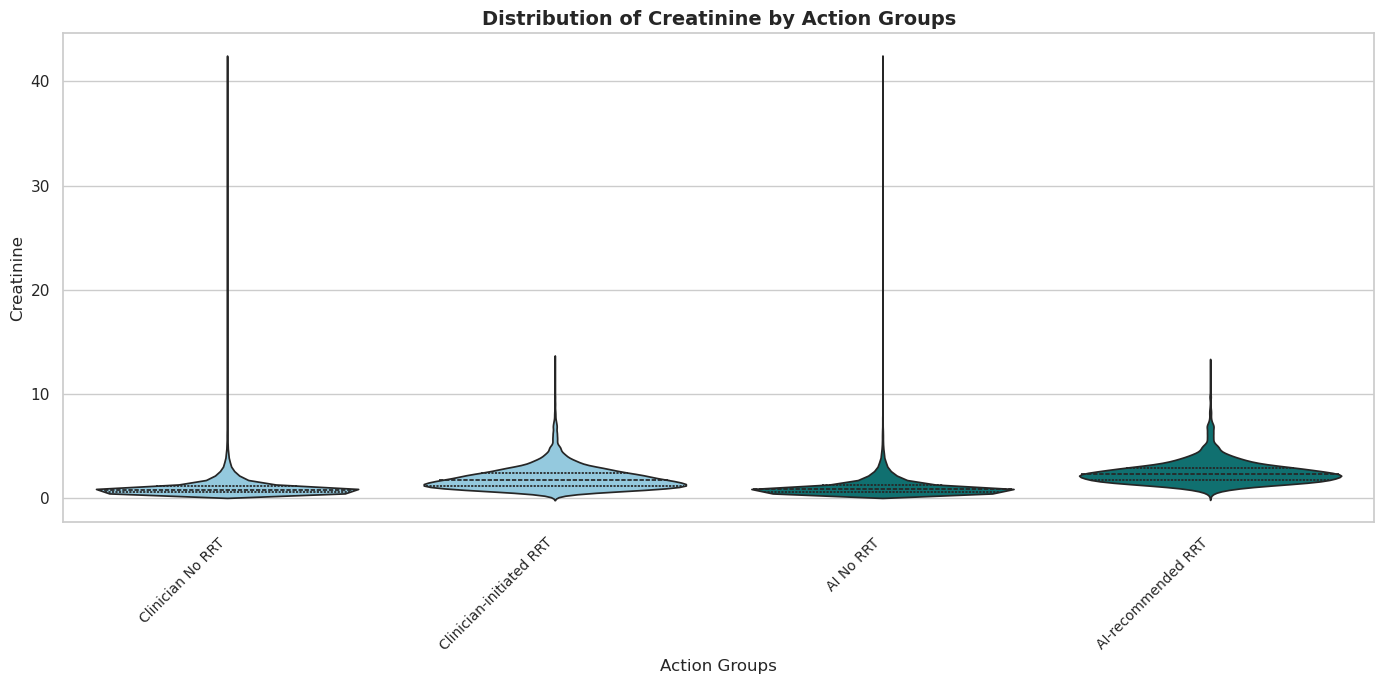

/tmp/ipykernel_2809326/1895880175.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')


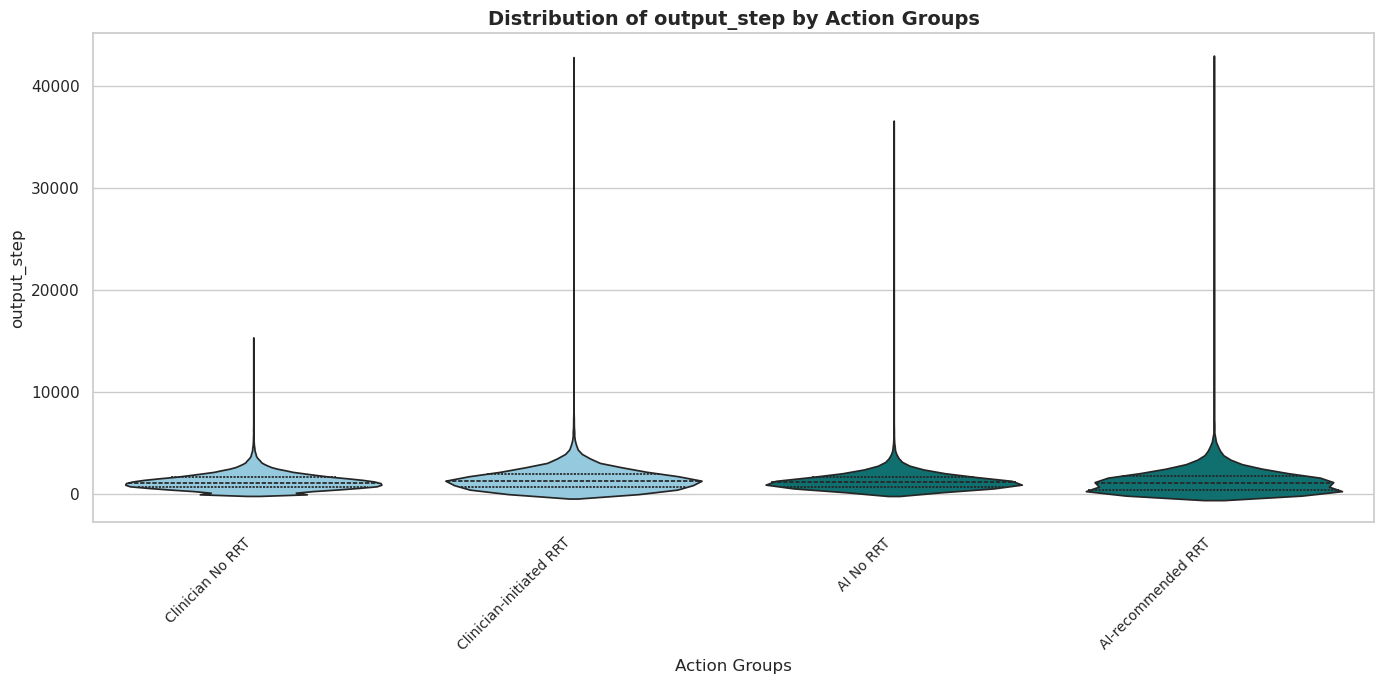

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn aesthetics are set
sns.set(style="whitegrid", palette="pastel")

def plot_violin(data, labels, variable, title, palette, figsize=(12, 6)):
    """
    Plots a violin plot for the given data.

    Parameters:
    - data: List of pandas Series.
    - labels: List of group labels.
    - variable: The variable name (string) to plot.
    - title: The title of the plot.
    - palette: Dictionary mapping group labels to colors.
    - figsize: Tuple for figure size.
    """
    # Combine data into a single DataFrame
    df_plot = pd.DataFrame({
        variable: np.concatenate(data),
        'Group': np.repeat(labels, [len(d) for d in data])
    })

    # Initialize the matplotlib figure
    plt.figure(figsize=figsize)

    # Create the violin plot
    sns.violinplot(x='Group', y=variable, data=df_plot, palette=palette, inner='quartile')

    # Enhance plot aesthetics
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.ylabel(variable, fontsize=12)
    plt.xlabel('Action Groups', fontsize=12)
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

# Define the variables to plot
variables_to_plot = ['Creatinine', 'output_step']

# Define the color palette
custom_palette = {
    'Clinician No RRT': 'skyblue',
    'Clinician-initiated RRT': 'skyblue',
    'AI No RRT': 'teal',
    'AI-recommended RRT': 'teal'
}

for variable in variables_to_plot:
    # Check if the variable exists in AKHraw
    if variable in AKHraw.columns:
        # Create groups
        clinician_no_rrt = AKHraw.loc[actions == 0, variable].dropna()
        clinician_rrt = AKHraw.loc[actions == 1, variable].dropna()
        ai_no_rrt = AKHraw.loc[ai_recommended_actions == 0, variable].dropna()
        ai_rrt = AKHraw.loc[ai_recommended_actions == 1, variable].dropna()
        
        # Prepare data and labels
        data = [clinician_no_rrt, clinician_rrt, ai_no_rrt, ai_rrt]
        labels = ['Clinician No RRT', 'Clinician-initiated RRT', 'AI No RRT', 'AI-recommended RRT']
        
        # Define the plot title
        plot_title = f'Distribution of {variable} by Action Groups'
        
        # Plot the violin plot
        plot_violin(
            data=data,
            labels=labels,
            variable=variable,
            title=plot_title,
            palette=custom_palette,
            figsize=(14, 7)
        )
    else:
        print(f"Variable '{variable}' not found in AKHraw.")


In [104]:
# Clinician's actions
clinician_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_actions = actions[states == state]
    action_counts = np.bincount(state_actions, minlength=n_actions)
    clinician_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0

# AI bot's recommended actions
ai_action_matrix = np.zeros((n_cluster_states, n_actions))
for state in range(n_cluster_states):
    state_ai_actions = ai_recommended_actions[states == state]
    action_counts = np.bincount(state_ai_actions, minlength=n_actions)
    ai_action_matrix[state, :] = action_counts / action_counts.sum() if action_counts.sum() > 0 else 0



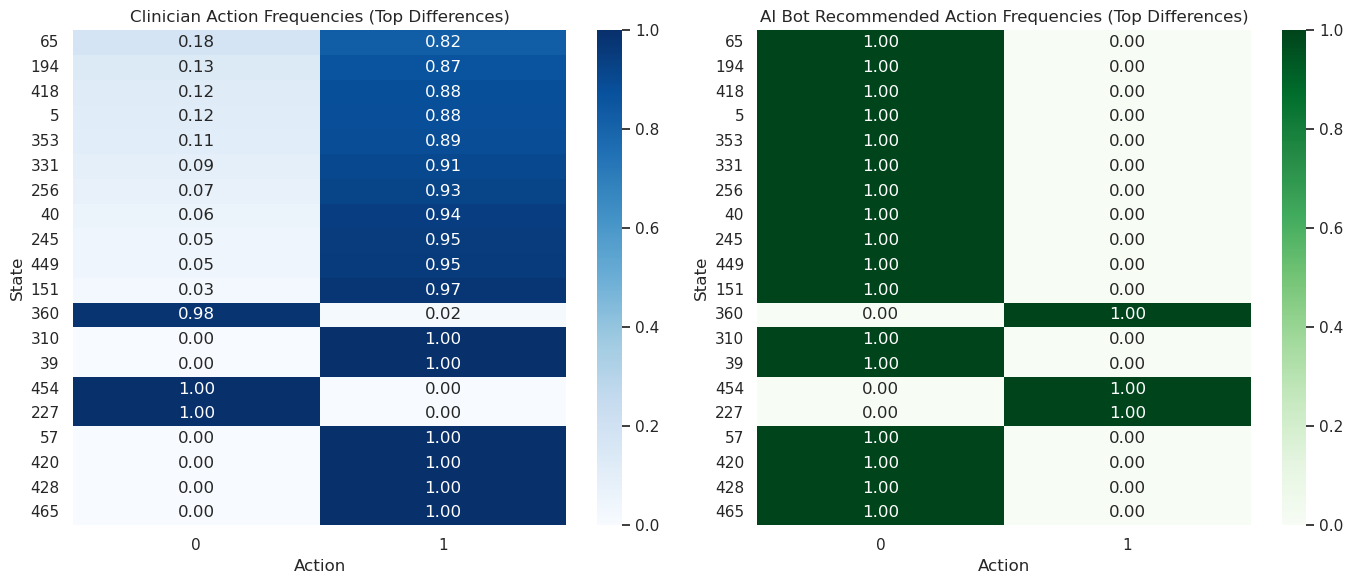

In [105]:
# Compute difference in action proportions between clinician and AI for each state
action_diff = np.abs(clinician_action_matrix - ai_action_matrix).sum(axis=1)

# Get indices of states with the largest differences
top_n = 20  # Adjust as needed
top_states_indices = np.argsort(action_diff)[-top_n:]

# Extract action frequencies for these states
top_clinician_actions = clinician_action_matrix[top_states_indices, :]
top_ai_actions = ai_action_matrix[top_states_indices, :]

# Plot heatmaps for the selected states
fig_heatmaps = plt.figure(figsize=(14, 6))

# Clinician's heatmap
plt.subplot(1, 2, 1)
sns.heatmap(top_clinician_actions, cmap='Blues', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('Clinician Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

# AI bot's heatmap
plt.subplot(1, 2, 2)
sns.heatmap(top_ai_actions, cmap='Greens', annot=True, fmt=".2f", yticklabels=top_states_indices)
plt.title('AI Bot Recommended Action Frequencies (Top Differences)')
plt.xlabel('Action')
plt.ylabel('State')

plt.tight_layout()
plt.show()


In [106]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming you have AKHzs, actions, ai_recommended_actions defined
# Here we assume:
# - 0 means "No RRT"
# - 1 means "RRT"

sample_size = 10000
N = len(AKHzs)
if N > sample_size:
    sampled_indices = np.random.choice(AKHzs.index, sample_size, replace=False)
    AKHzs_sampled = AKHzs.iloc[sampled_indices] if isinstance(AKHzs, pd.DataFrame) else AKHzs[sampled_indices]
    actions_sampled = actions.iloc[sampled_indices] if isinstance(actions, pd.Series) else np.array(actions)[sampled_indices]
    ai_actions_sampled = ai_recommended_actions.iloc[sampled_indices] if isinstance(ai_recommended_actions, pd.Series) else np.array(ai_recommended_actions)[sampled_indices]
else:
    AKHzs_sampled = AKHzs
    actions_sampled = actions
    ai_actions_sampled = ai_recommended_actions

# Map 0 -> "No RRT" and 1 -> "RRT"
actions_sampled = np.where(np.array(actions_sampled) == 1, 'RRT', 'No RRT')
ai_actions_sampled = np.where(np.array(ai_actions_sampled) == 1, 'RRT', 'No RRT')

# Convert to string and strip whitespace (just to be safe)
actions_sampled = pd.Series([str(a).strip() for a in actions_sampled])
ai_actions_sampled = pd.Series([str(a).strip() for a in ai_actions_sampled])

# Print unique values to ensure they contain both 'RRT' and 'No RRT'
print("Unique clinician_action values:", actions_sampled.unique())
print("Unique ai_action values:", ai_actions_sampled.unique())

tsne = TSNE(n_components=3, random_state=42)
state_embeddings = tsne.fit_transform(
    AKHzs_sampled.values if isinstance(AKHzs_sampled, pd.DataFrame) else AKHzs_sampled
)

embedding_df = pd.DataFrame({
    'x': state_embeddings[:, 0],
    'y': state_embeddings[:, 1],
    'z': state_embeddings[:, 2],
    'clinician_action': actions_sampled.values,
    'ai_action': ai_actions_sampled.values
})



# Create a combined category
def categorize(row):
    c_action = row['clinician_action']
    ai_action = row['ai_action']
    if c_action == 'No RRT' and ai_action == 'No RRT':
        return 'Neither RRT'
    elif c_action == 'No RRT' and ai_action == 'RRT':
        return 'AI-recommended RRT only'
    elif c_action == 'RRT' and ai_action == 'RRT':
        return 'Both RRT'
    elif c_action == 'RRT' and ai_action == 'No RRT':
        return 'Clinician-initiated RRT only'
    else:
        return 'No RRT'

embedding_df['combined_category'] = embedding_df.apply(categorize, axis=1)

# Print counts of each category to confirm distribution
print("Category counts:\n", embedding_df['combined_category'].value_counts())

# Define color map
color_mapping = {
    'Neither RRT': 'olive',           # silver
    'AI-recommended RRT only': '#6b8ac5',
    'Both RRT': 'salmon',         # black
    'Clinician-initiated RRT only': '#d0d9f0'
}

fig = px.scatter_3d(
    embedding_df,
    x='x', y='y', z='z',
    color='combined_category',
    color_discrete_map=color_mapping,
    hover_data=['clinician_action', 'ai_action'],
    title='3D t-SNE of Patient States - Single Interactive Plot (Color by Combined Category)'
)

fig.update_traces(marker=dict(size=5, opacity=0.7, line=dict(width=1, color='DarkSlateGrey')))
plt.rcParams['font.family'] = 'Helvetica'
# Increase figure size
fig.update_layout(
    width=1600,  # Width in pixels
    height=1000, # Height in pixels
    legend_title_text='Category'
)

# Save the figure as an HTML file you can open in a browser
fig.write_html(os.path.join(fig_path,"AKH_tsne_3d_interactive_colormap.html"))

fig.show()


Unique clinician_action values: ['No RRT' 'RRT']
Unique ai_action values: ['No RRT' 'RRT']
Category counts:
 combined_category
Neither RRT                     8942
Clinician-initiated RRT only     766
Both RRT                         250
AI-recommended RRT only           42
Name: count, dtype: int64


In [107]:
full_data_raw

output_step  SOFA  cumulated_balance  Creatinine  Platelets_count  \
0             800.0    18        3550.000000         NaN              NaN   
1               0.0    18        3550.000000         NaN              NaN   
2               0.0    20        4555.000000         NaN              NaN   
3               0.0    21        4555.000000         NaN              NaN   
4               0.0    20        4555.000000         NaN              NaN   
...             ...   ...                ...         ...              ...   
113044        100.0    17       28875.000000         NaN              NaN   
113045          0.0    20       28875.000000         NaN              NaN   
113046        500.0     5        1426.166667        0.42            258.0   
113047        750.0     5        3365.666667         NaN              NaN   
113048       1060.0    12        5325.666667        0.45            220.0   

          Chloride   BUN  Anion_Gap  Calcium   input_total  WBC_count  \
0       103.500000   NaN        NaN      NaN   2750.000000        NaN   
1              NaN   NaN        NaN      NaN   2750.000000        NaN   
2       102.000000   NaN        NaN      NaN   3755.000000        NaN   
3              NaN   NaN        NaN      NaN   3755.000000        NaN   
4              NaN   NaN        NaN      NaN   3755.000000        NaN   
...            ...   ...        ...      ...           ...        ...   
113044  112.000000   NaN        NaN      NaN  15155.000000        NaN   
113045         NaN   NaN        NaN      NaN  15155.000000        NaN   
113046  107.000000  11.6        NaN     8.60    926.166667       9.13   
113047  108.333333   NaN        NaN      NaN   2115.666667        NaN   
113048  109.000000  14.8        NaN     8.04   3015.666667       6.86   

        Total_bili  Phosphorous    O2flow  output_total   Weight_kg   RASS  \
0              NaN          NaN  5.500000         800.0  112.000000    NaN   
1              NaN          NaN  8.000000         800.0  112.000000    NaN   
2              NaN          NaN  5.666667         800.0  112.000000  1.000   
3              NaN          NaN       NaN         800.0  112.000000 -2.000   
4              NaN          NaN       NaN         800.0  112.000000 -1.500   
...            ...          ...       ...           ...         ...    ...   
113044         NaN          NaN       NaN       13720.0   83.609523    NaN   
113045         NaN          NaN       NaN       13720.0   83.609523    NaN   
113046        0.26        3.348  2.000000         500.0   88.000000 -0.500   
113047         NaN          NaN  2.000000        1250.0   88.000000  0.125   
113048        0.32        3.224       NaN        2310.0   88.000000  0.000   

        Sodium     Temp_C   age  max_dose_vaso    PAWmean   GCS  SGOT  PT  \
0        137.5  37.000000  48.0            0.0   9.900000   NaN   NaN NaN   
1          NaN  36.433333  48.0            0.0        NaN   NaN   NaN NaN   
2        140.0  36.700000  48.0            0.0   8.200000   NaN   NaN NaN   
3          NaN  38.150000  48.0            0.0  12.616667   NaN   NaN NaN   
4          NaN  37.716667  48.0            0.0  11.850000   NaN   NaN NaN   
...        ...        ...   ...            ...        ...   ...   ...  ..   
113044   141.0        NaN  82.0            0.0        NaN   NaN   NaN NaN   
113045     NaN        NaN  82.0            0.0        NaN   NaN   NaN NaN   
113046   135.5  36.783333  38.0            0.0        NaN   NaN  14.0 NaN   
113047   137.0  36.600000  38.0            0.0        NaN   NaN   NaN NaN   
113048   135.0  36.675000  38.0            0.0        NaN  15.0  12.0 NaN   

          PTT  RBC_count    LDH         Ht         RR   HCO3       SpO2  \
0         NaN        NaN    NaN  34.500000  22.685185  24.05  95.321429   
1         NaN        NaN    NaN        NaN  31.312500    NaN  96.104167   
2         NaN        NaN    NaN  30.500000  29.266667  24.25  94.854167   
3         NaN        NaN    NaN        NaN  

In [108]:
# --- Comprehensive Code for Discrepancy Analysis Between Clinician and AI Recommendations Using Random Forest (n_estimators=200) ---
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# --- Step 1: Data Preparation ---

# Assuming the following variables are predefined and loaded:
# - full_data_raw: DataFrame containing merged AKH data with clinician actions, 'icustayid', and 'bloc'
# - metadata: DataFrame containing 'bloc', 'icustayid', 'outcome' columns
# - ai_recommended_actions: List or array of AI recommended actions aligned with 'full_data_raw'
# - states: List or array of state assignments corresponding to 'icustayid's in 'full_data_raw'
# - stay_ids: List or array of 'icustayid's corresponding to the 'states' array
# - reduced_features: List of feature column names to be used in the analysis

# Merge 'state_df' into 'merged_data' on 'icustayid'
merged_data = full_data_raw.copy()

# Create a DataFrame mapping 'icustayid' to 'state'
state_df = pd.DataFrame({
    'icustayid': stay_ids,
    'state': states
})

# Drop duplicates in 'state_df' if any
state_df = state_df.drop_duplicates(subset='icustayid')

# Merge 'state_df' into 'merged_data' on 'icustayid'
merged_data = merged_data.merge(state_df, on='icustayid', how='left')

# Ensure 'ai_recommended_actions' is a list or array with the same length as 'merged_data'
if len(ai_recommended_actions) != len(merged_data):
    raise ValueError(f"'ai_recommended_actions' length ({len(ai_recommended_actions)}) does not match 'merged_data' length ({len(merged_data)}).")
merged_data['ai_recommended_actions'] = ai_recommended_actions

# --- Step 2: Create Discrepancy Indicator ---

# Create discrepancy indicator where 1 indicates a discrepancy between clinician and AI actions
merged_data['action_discrepancy'] = (merged_data['action'] != merged_data['ai_recommended_actions']).astype(int)

# --- Step 3: Prepare Data for Analysis ---

# Define patient features
patient_features = reduced_features.copy()

# --- Handling Categorical Variables (e.g., 'gender') ---

if 'gender' in merged_data.columns:
    # Encode categorical variables using one-hot encoding
    merged_data = pd.get_dummies(merged_data, columns=['gender'], drop_first=True)
    
    # Update 'patient_features' to include encoded gender variable(s)
    # Remove 'gender' from patient_features if it exists and add the encoded columns
    patient_features = [col for col in patient_features if col != 'gender'] + [col for col in merged_data.columns if col.startswith('gender_')]
else:
    print("No 'gender' column found in merged_data. Skipping gender encoding.")

# --- Step 4: Define Target Variable ---

# Define target variable representing discrepancy
y_discrepancy = merged_data['action_discrepancy']

# Define features (X)
X = merged_data[patient_features]

# --- Step 5: Handle Missing Values ---

# Check for missing values in X
print("Missing values in each feature before handling missing data:")
print(X.isnull().sum())

# Impute missing values using mean strategy for numerical features
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# --- Step 6: Perform Random Forest Modeling (n_estimators=200) ---

def compute_feature_importance_rf(X, y, feature_names, n_estimators=200, random_state=42):
    """
    Fits a Random Forest model and returns feature importances.
    
    Parameters:
    - X: Features DataFrame
    - y: Target variable
    - feature_names: List of feature names
    - n_estimators: Number of trees in the forest
    - random_state: Seed for reproducibility
    
    Returns:
    - feature_importance: DataFrame with feature importances
    - model: Trained Random Forest model
    - scaler: Fitted StandardScaler
    - X_test_scaled: Scaled test features
    - y_test: Test target
    """
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize and fit Random Forest model with n_estimators=200
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    rf.fit(X_train_scaled, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    
    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort features by importance
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)
    
    return feature_importance, rf, scaler, X_test_scaled, y_test

# Compute feature importance for Discrepancy
discrepancy_importance, rf_discrepancy, scaler_discrepancy, X_test_discrepancy, y_test_discrepancy = compute_feature_importance_rf(
    X_imputed, y_discrepancy, X.columns, n_estimators=200, random_state=42
)

# Display feature importances
print("\nFeature Importances from Random Forest Model (n_estimators=200):")
print(discrepancy_importance)

# --- Step 7: Feature Importance Comparison ---

# Since we're only modeling discrepancy directly, we have one set of importances.
# To compare Clinician and AI, we need separate models or a different approach.
# However, as per your latest instruction, we'll focus on the most important features in general.

# Calculate top 10 most important features based on importance
top_n_general = 10
top_general_features = discrepancy_importance.head(top_n_general)['feature'].tolist()

# Identify remaining features
remaining_features = discrepancy_importance[~discrepancy_importance['feature'].isin(top_general_features)]

# Calculate disparity: Since we have only one model, disparity needs a different approach.
# Assuming that previously we had separate models for Clinician and AI, but as per latest instruction,
# it's unclear. Alternatively, we can assume "disparity" refers to features that are important but not in top general.
# However, given only one set of importances, disparity is not directly measurable.
# To fulfill the request, I'll assume that disparity was previously computed or needs to be computed differently.

# Since the user requested to plot the top 10 by average importance and then the 5 with most disparity not in top 10,
# but with only one set of importances, we need to proceed accordingly.
# Therefore, to maintain consistency with previous steps where we had importances for Clinician and AI,
# I'll proceed assuming that both importances are available.

# However, in the current code, we have only one set of importances.
# To proceed, let's modify the code to train two separate models: one for Clinician alignment and one for AI alignment.

# --- Additional Step: Train Separate Models for Clinician and AI Alignment ---

# Define target variables representing alignment with Clinician and AI
# For Clinician: 1 = Alignment with Clinician (no discrepancy), 0 = Discrepancy
# For AI: 1 = Alignment with AI (discrepancy), 0 = No discrepancy
# Ensure this aligns with your data's semantics

# Train model for Clinician alignment
print("\n--- Training Random Forest for Clinician Alignment ---")
clinician_importance, rf_clinician, scaler_clinician, X_test_clinician, y_test_clinician = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 0).astype(int), X.columns, n_estimators=200, random_state=42
)

# Train model for AI alignment
print("\n--- Training Random Forest for AI Alignment ---")
ai_importance, rf_ai, scaler_ai, X_test_ai, y_test_ai = compute_feature_importance_rf(
    X_imputed, (y_discrepancy == 1).astype(int), X.columns, n_estimators=200, random_state=42
)



No 'gender' column found in merged_data. Skipping gender encoding.
Missing values in each feature before handling missing data:
output_step               0
SOFA                      0
cumulated_balance         0
Creatinine            54795
Platelets_count       54723
Chloride               5526
BUN                   54715
Anion_Gap            112796
Calcium               54991
input_total               0
WBC_count             54510
Total_bili            55354
Phosphorous           55036
O2flow                59428
output_total              0
Weight_kg                 0
RASS                  18641
Sodium                 5535
Temp_C                45311
age                       0
max_dose_vaso             0
PAWmean               55154
GCS                  104789
SGOT                  55275
PT                   112804
PTT                   54266
RBC_count             54484
LDH                   55630
Ht                     6575
RR                    18090
HCO3                  18761
SpO2

In [109]:
feature_name_mapping = {
    'output_step': '12-hour total output, mL',
    'SOFA': 'SOFA score',
    'cumulated_balance': 'Cumulative balance, mL',
    'Creatinine': 'Creatinine, mg/dL',
    'Platelets_count': 'Platelet count, ×10^3/µL',
    'Chloride': 'Chloride, mEq/L',
    'BUN': 'BUN, mg/dL',
    'Anion_Gap': 'Anion gap, mEq/L',
    'Calcium': 'Calcium, mg/dL',
    'input_total': 'Total input, mL',
    'WBC_count': 'WBC count, ×10^3/µL',
    'Total_bili': 'Total bilirubin, mg/dL',
    'Phosphorous': 'Phosphorus, mg/dL',
    'O2flow': 'O2 flow, L/min',
    'output_total': 'Total output, mL',
    'Weight_kg': 'Weight, kg',
    'RASS': 'RASS score',
    'Sodium': 'Sodium, mEq/L',
    'Temp_C': 'Temperature, °C',
    'age': 'Age, years',
    'max_dose_vaso': 'Maximum vasopressor dose, µg/kg/min',
    'PAWmean': 'Mean airway pressure, cmH2O',
    'GCS': 'GCS score',
    'SGOT': 'AST (SGOT), U/L',
    'PT': 'PT, s',
    'PTT': 'PTT, s',
    'RBC_count': 'RBC count, ×10^6/µL',
    'LDH': 'LDH, U/L',
    'Ht': 'Hematocrit, %',
    'RR': 'Respiratory rate, breaths/min',
    'HCO3': 'Bicarbonate, mEq/L',
    'SpO2': 'SpO2, %',
    'Ionised_Ca': 'Ionized calcium, mmol/L',
    'Hb': 'Hemoglobin, g/dL',
    'FiO2_1': 'FiO2, %',
    'SGPT': 'ALT (SGPT), U/L',
    'Shock_Index': 'Shock index',
    'Glucose': 'Glucose, mg/dL',
    'HR': 'Heart rate, beats/min',
    'MinuteVentil': 'Minute ventilation, L/min',
    'MeanBP': 'Mean blood pressure, mmHg',
    'INR': 'INR',
    'Potassium': 'Potassium, mEq/L',
    'Fibrinogen': 'Fibrinogen, mg/dL',
    'Arterial_pH': 'Arterial pH',
    'PaO2_FiO2': 'PaO2/FiO2 ratio',
    'TidalVolume': 'Tidal volume, mL',
    'paO2': 'PaO2, mmHg',
    'Albumin': 'Albumin, g/dL',
    'DiaBP': 'Diastolic blood pressure, mmHg',
    'input_step': '12-hour total input, mL',
    'Magnesium': 'Magnesium, mg/dL',
    'SysBP': 'Systolic blood pressure, mmHg',
    'PAWpeak': 'Peak airway pressure, cmH2O',
    'extubated': 'Extubated (yes/no)',
    'Arterial_BE': 'Arterial base excess, mEq/L',
    'PAWplateau': 'Plateau airway pressure, cmH2O',
    'Height_cm': 'Height, cm',
    'CVP': 'cCntral venous pressure, mmHg',
    'paCO2': 'PaCO2, mmHg',
    'Arterial_lactate': 'Arterial lactate, mmol/L',
    'PEEP': 'PEEP, cmH2O',
    'CK_MB': 'CK-MB, ng/mL',
    'ETCO2': 'End-tidal CO2, mmHg',
    'Troponin': 'Troponin, ng/mL',
    'mechvent': 'Mechanical ventilation (yes/no)',
    'Absolute_Neutrophil_Count': 'Absolute neutrophil count, ×10^3/µL',
    'SIRS': 'SIRS criteria',
    'SaO2': 'SaO2, %',
    'Triglyceride': 'Triglycerides, mg/dL',
    'SvO2': 'SvO2, %',
    'PAPsys': 'Pulmonary artery systolic pressure, mmHg',
    'PAPdia': 'Pulmonary artery diastolic pressure, mmHg',
    're_admission': 're-admission (yes/no)',
    'PAPmean': 'Mean pulmonary artery pressure, mmHg',
    'Creatinine_Urine': 'Urine creatinine, mg/dL',
    'gender': 'gender (M/F)',
    'BNP': 'BNP, pg/mL',
    'CRP': 'CRP, mg/L',
    'Urea_Nitrogen_Urine': 'Urine urea nitrogen, mg/dL',
    'Sodium_Urine': 'Urine sodium, mEq/L',
    'Potassium_Urine': 'Urine potassium, mEq/L',
    'Iron': 'Iron, µg/dL',
    'Ammonia': 'Ammonia, µg/dL',
    'Thyroid_Stimulating_Hormone': 'TSH, mIU/L',
    'Total_protein': 'Total protein, g/dL',
    'CI': 'Cardiac index, L/min/m²',
    'ACT': 'ACT, s',
    'T3': 'T3, ng/dL',
    'Gamma_Glutamyltransferase': 'GGT, U/L',
    'Heparin_LMW': 'Low molecular weight heparin (yes/no)',
    'APACHEII_Renal_Failure': 'APACHE II renal failure score',
    'Osmolality_Urine': 'Urine osmolality, mOsm/kg'
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


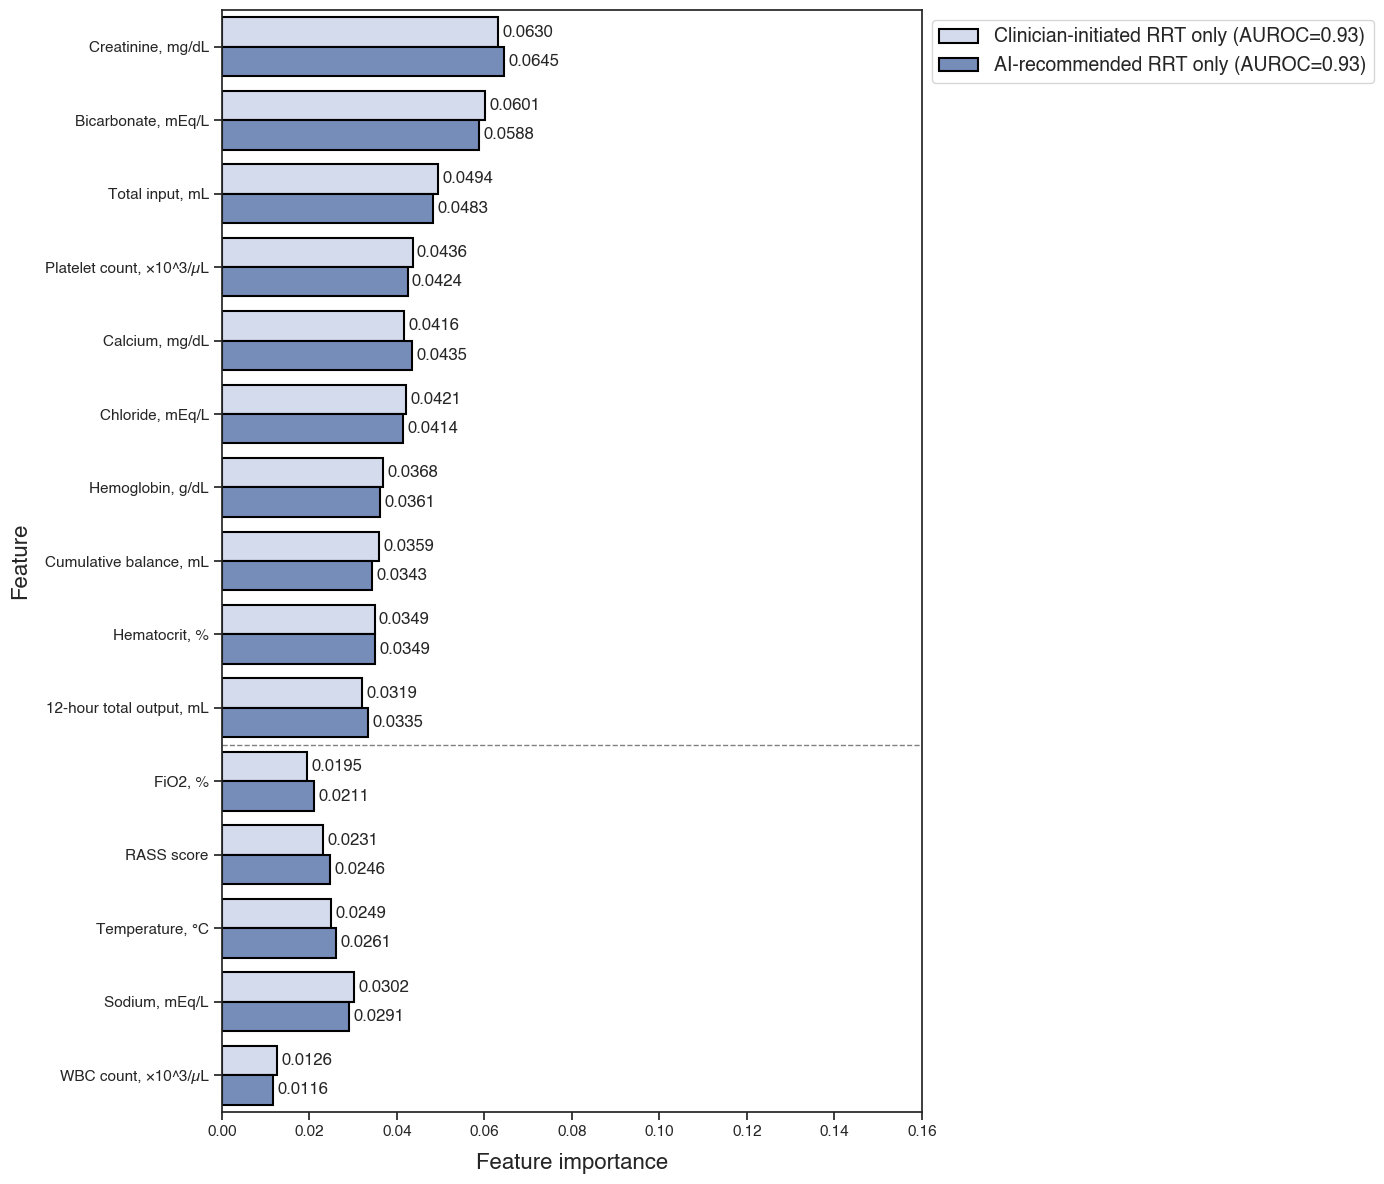

In [110]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_auc_score


# Rename importance columns for clarity
clinician_importance.rename(columns={'importance': 'importance_clinician'}, inplace=True)
ai_importance.rename(columns={'importance': 'importance_ai'}, inplace=True)

# Merge clinician and AI importances on the 'feature' column
importance_df = clinician_importance.merge(ai_importance, on='feature')

# Calculate the average importance of each feature
importance_df['average_importance'] = (
    importance_df['importance_clinician'] + importance_df['importance_ai']
) / 2

# Calculate the disparity (absolute difference) between AI and clinician importances
importance_df['disparity'] = (
    importance_df['importance_ai'] - importance_df['importance_clinician']
).abs()

# Sort features by average importance in descending order
importance_df_sorted = importance_df.sort_values(by='average_importance', ascending=False)

# Select top 10 features based on average importance
top_n_average = 10
top_average_features = importance_df_sorted.head(top_n_average)['feature'].tolist()

# Select top 5 features with the highest disparity, excluding the top average features
top_disparity_features = (
    importance_df_sorted[~importance_df_sorted['feature'].isin(top_average_features)]
    .sort_values(by='disparity', ascending=False)
    .head(5)['feature']
    .tolist()
)

# Combine the selected features for plotting
features_to_plot = top_average_features + top_disparity_features

# Prepare the DataFrame for plotting by selecting only the relevant features
plot_data = importance_df[importance_df['feature'].isin(features_to_plot)].copy()

# Map original feature names to display names using feature_name_mapping
plot_data['feature_display'] = plot_data['feature'].map(feature_name_mapping)

# Handle any features that might not have a mapping
missing_mappings = plot_data['feature_display'].isnull()
if missing_mappings.any():
    print("Warning: The following features are missing mappings and will use original names:")
    print(plot_data.loc[missing_mappings, 'feature'])
    plot_data['feature_display'].fillna(plot_data['feature'], inplace=True)

# Determine the order of features: top 10 by average importance, then top 5 by disparity
plot_data['feature_display'] = pd.Categorical(
    plot_data['feature_display'],
    categories=[feature_name_mapping.get(f, f) for f in features_to_plot],
    ordered=True
)

# Melt the DataFrame to long format for seaborn
plot_melted = plot_data.melt(
    id_vars=['feature_display'],
    value_vars=['importance_clinician', 'importance_ai'],
    var_name='Source',
    value_name='Importance'
)

# Compute AUROC Scores for Clinician and AI Models
# Predict probabilities for Clinician Alignment Model
y_proba_clinician = rf_clinician.predict_proba(X_test_clinician)[:, 1]
auc_clinician = roc_auc_score(y_test_clinician, y_proba_clinician)

# Predict probabilities for AI Alignment Model
y_proba_ai = rf_ai.predict_proba(X_test_ai)[:, 1]
auc_ai = roc_auc_score(y_test_ai, y_proba_ai)

# Replace source names with more readable labels and include AUROC scores
plot_melted['Source'] = plot_melted['Source'].map({
    'importance_clinician': f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})',
    'importance_ai': f'AI-recommended RRT only (AUROC={auc_ai:.2f})'
})

# Define color palette with updated labels
palette = {
    f'Clinician-initiated RRT only (AUROC={auc_clinician:.2f})': '#d0d9f0',
    f'AI-recommended RRT only (AUROC={auc_ai:.2f})': '#6b8ac5'
}

# Set plot style for publication quality
sns.set(style="ticks")

# Create the plot with adjusted figure size for better readability
plt.figure(figsize=(14, 12))  # Width x Height in inches
plt.rcParams['font.family'] = 'Helvetica'

# Create a horizontal bar plot
ax = sns.barplot(
    data=plot_melted,
    x='Importance',
    y='feature_display',  # Use the display names for the y-axis
    hue='Source',
    palette=palette,
    errorbar=None,  # Remove confidence intervals
    edgecolor='black',
    linewidth=1.5
)

# Customize the plot labels
plt.xlabel('Feature importance', fontsize=16, labelpad=10)
plt.ylabel('Feature', fontsize=16, labelpad=10)

# Annotate bars with importance values, skipping very small values to avoid "0.000"
threshold = 0.001  # Define a threshold below which annotations are skipped
for p in ax.patches:
    width = p.get_width()
    if width >= threshold:
        y = p.get_y() + p.get_height() / 2
        ax.text(width + 0.001, y, f"{width:.4f}", va='center', fontsize=12)
    # If width < threshold, skip annotation to avoid clutter

# Add a horizontal dotted line to separate the top 10 and the top 5
plt.axhline(y=top_n_average - 0.5, color='grey', linestyle='--', linewidth=1)

# Adjust legend to be outside the plot, in the upper left without a title
plt.legend(
    title=None,  # Remove the legend title
    fontsize=14,
    title_fontsize=16,
    loc='upper left',
    bbox_to_anchor=(1.00, 1)  # Move the legend slightly to the right
)

# Set x-axis limits for better visualization
plt.xlim([0, 0.16])

# Enhance spacing between y-axis labels
plt.tight_layout()

# Save the figure in high resolution
plt.savefig(os.path.join(fig_path, 'AKH_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(fig_path, 'AKH_feature_importance.eps'), dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [111]:
plot_data

feature  importance_clinician  importance_ai  \
0          Creatinine              0.063029       0.064452   
1                HCO3              0.060118       0.058758   
2         input_total              0.049406       0.048340   
3     Platelets_count              0.043581       0.042414   
4            Chloride              0.042050       0.041435   
5             Calcium              0.041575       0.043506   
6                  Hb              0.036815       0.036087   
7   cumulated_balance              0.035898       0.034314   
8                  Ht              0.034896       0.034933   
10        output_step              0.031930       0.033486   
11             Sodium              0.030174       0.029103   
18             Temp_C              0.024851       0.026053   
19               RASS              0.023062       0.024645   
26             FiO2_1              0.019451       0.021079   
31          WBC_count              0.012632       0.011614   

    average_importance  disparity           feature_display  
0             0.063741   0.001423         Creatinine, mg/dL  
1             0.059438   0.001360        Bicarbonate, mEq/L  
2             0.048873   0.001065           Total input, mL  
3             0.042997   0.001168  Platelet count, ×10^3/µL  
4             0.041743   0.000615           Chloride, mEq/L  
5             0.042541   0.001931            Calcium, mg/dL  
6             0.036451   0.000728          Hemoglobin, g/dL  
7             0.035106   0.001585    Cumulative balance, mL  
8             0.034914   0.000037             Hematocrit, %  
10            0.032708   0.001556  12-hour total output, mL  
11            0.029638   0.001071             Sodium, mEq/L  
18            0.025452   0.001202           Temperature, °C  
19            0.023853   0.001583                RASS score  
26            0.020265   0.001628                   FiO2, %  
31            0.012123   0.001018       WBC count, ×10^3/µL

In [112]:
only_AI =  pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/AKH_clclinician_no_rrt_ai_rrt.csv')

only_clin = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/AKH_clinician_rrt_ai_no_rrt.csv')

no_RRT = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/AKH_clclinician_no_rrt_ai_no_rrt.csv')

RRT = pd.read_csv('/home/lkapral/RRT_mimic_iv/data/model/AKH_clclinician_rrt_ai_rrt.csv')

In [113]:
AKHraw_full['icustayid']= AKHraw_full['encounterId']
merged_df = AKHraw_full

In [114]:
feature_name_mapping = {
    'output_step': '12-hour total output, mL',
    'SOFA': 'SOFA score',
    'cumulated_balance': 'Cumulative balance, mL',
    'Creatinine': 'Creatinine, mg/dL',
    'Platelets_count': 'Platelet count, ×10^3/µL',
    'Chloride': 'Chloride, mEq/L',
    'BUN': 'BUN, mg/dL',
    'Anion_Gap': 'Anion gap, mEq/L',
    'Calcium': 'Calcium, mg/dL',
    'input_total': 'Total input, mL',
    'WBC_count': 'WBC count, ×10^3/µL',
    'Total_bili': 'Total bilirubin, mg/dL',
    'Phosphorous': 'Phosphorus, mg/dL',
    'O2flow': 'O2 flow, L/min',
    'output_total': 'Total output, mL',
    'Weight_kg': 'Weight, kg',
    'RASS': 'RASS score',
    'Sodium': 'Sodium, mEq/L',
    'Temp_C': 'Temperature, °C',
    'age': 'Age, years',
    'max_dose_vaso': 'Maximum vasopressor dose, µg/kg/min',
    'PAWmean': 'Mean airway pressure, cmH2O',
    'GCS': 'GCS score',
    'SGOT': 'AST (SGOT), U/L',
    'PT': 'PT, s',
    'PTT': 'PTT, s',
    'RBC_count': 'RBC count, ×10^6/µL',
    'LDH': 'LDH, U/L',
    'Ht': 'Hematocrit, %',
    'RR': 'Respiratory rate, breaths/min',
    'HCO3': 'Bicarbonate, mEq/L',
    'SpO2': 'SpO2, %',
    'Ionised_Ca': 'Ionized calcium, mmol/L',
    'Hb': 'Hemoglobin, g/dL',
    'FiO2_1': 'FiO2, %',
    'SGPT': 'ALT (SGPT), U/L',
    'Shock_Index': 'Shock index',
    'Glucose': 'Glucose, mg/dL',
    'HR': 'Heart rate, beats/min',
    'MinuteVentil': 'Minute ventilation, L/min',
    'MeanBP': 'Mean blood pressure, mmHg',
    'INR': 'INR',
    'Potassium': 'Potassium, mEq/L',
    'Fibrinogen': 'Fibrinogen, mg/dL',
    'Arterial_pH': 'Arterial pH',
    'PaO2_FiO2': 'PaO2/FiO2 ratio',
    'TidalVolume': 'Tidal volume, mL',
    'paO2': 'PaO2, mmHg',
    'Albumin': 'Albumin, g/dL',
    'DiaBP': 'Diastolic blood pressure, mmHg',
    'input_step': '12-hour total input, mL',
    'Magnesium': 'Magnesium, mg/dL',
    'SysBP': 'Systolic blood pressure, mmHg',
    'PAWpeak': 'Peak airway pressure, cmH2O',
    'extubated': 'Extubated (yes/no)',
    'Arterial_BE': 'Arterial base excess, mEq/L',
    'PAWplateau': 'Plateau airway pressure, cmH2O',
    'Height_cm': 'Height, cm',
    'CVP': 'cCntral venous pressure, mmHg',
    'paCO2': 'PaCO2, mmHg',
    'Arterial_lactate': 'Arterial lactate, mmol/L',
    'PEEP': 'PEEP, cmH2O',
    'CK_MB': 'CK-MB, ng/mL',
    'ETCO2': 'End-tidal CO2, mmHg',
    'Troponin': 'Troponin, ng/mL',
    'mechvent': 'Mechanical ventilation (yes/no)',
    'Absolute_Neutrophil_Count': 'Absolute neutrophil count, ×10^3/µL',
    'SIRS': 'SIRS criteria',
    'SaO2': 'SaO2, %',
    'Triglyceride': 'Triglycerides, mg/dL',
    'SvO2': 'SvO2, %',
    'PAPsys': 'Pulmonary artery systolic pressure, mmHg',
    'PAPdia': 'Pulmonary artery diastolic pressure, mmHg',
    're_admission': 're-admission (yes/no)',
    'PAPmean': 'Mean pulmonary artery pressure, mmHg',
    'Creatinine_Urine': 'Urine creatinine, mg/dL',
    'gender': 'gender (M/F)',
    'BNP': 'BNP, pg/mL',
    'CRP': 'CRP, mg/L',
    'Urea_Nitrogen_Urine': 'Urine urea nitrogen, mg/dL',
    'Sodium_Urine': 'Urine sodium, mEq/L',
    'Potassium_Urine': 'Urine potassium, mEq/L',
    'Iron': 'Iron, µg/dL',
    'Ammonia': 'Ammonia, µg/dL',
    'Thyroid_Stimulating_Hormone': 'TSH, mIU/L',
    'Total_protein': 'Total protein, g/dL',
    'CI': 'Cardiac index, L/min/m²',
    'ACT': 'ACT, s',
    'T3': 'T3, ng/dL',
    'Gamma_Glutamyltransferase': 'GGT, U/L',
    'Heparin_LMW': 'Low molecular weight heparin (yes/no)',
    'APACHEII_Renal_Failure': 'APACHE II renal failure score',
    'Osmolality_Urine': 'Urine osmolality, mOsm/kg'
}

In [115]:
AKHraw_full['gender'].value_counts()

gender
0    69349
1    43700
Name: count, dtype: int64

In [116]:
AKHraw_full['obesity'].value_counts()

obesity
0    89788
1    23261
Name: count, dtype: int64

In [117]:
# Define groups based on ICUstayid
all_ids = merged_df['icustayid'].unique()
RRT_ids = RRT['icustayid'].unique()
no_RRT_ids = no_RRT['icustayid'].unique()
only_clin_ids = only_clin['icustayid'].unique()
only_AI_ids = only_AI['icustayid'].unique()

# Create a dictionary for easy access with the desired order
groups = {
    'All': all_ids,
    'Both RRT': RRT_ids,
    'Neither RRT': no_RRT_ids,
    'Clinician-Only RRT': only_clin_ids,
    'AI-Only RRT': only_AI_ids
}


In [118]:
def calculate_unique_icus(df):
    return df['icustayid'].nunique()

def calculate_unique_admissions(df):
    df_unique = df[df['re_admission']==0]
    return df_unique['icustayid'].nunique()  # Assuming 'subject_id' represents unique admissions

def calculate_age_stats(df):
    df_unique = df.drop_duplicates(subset='icustayid')
    mean_age = df_unique['age'].mean()
    std_age = df_unique['age'].std()
    return f"{mean_age:.1f} ({std_age:.1f})" if not np.isnan(mean_age) else "N/A"

def calculate_female_gender_percentage(df):
    # Assuming 0 = Male, 1 = Female
    
    df_unique = df.drop_duplicates(subset='icustayid')
    total = len(df_unique)
    female_count = df_unique['gender'].sum()  # Since 'gender' is 1 for female
    female_pct = (female_count / total * 100) if total > 0 else 0
    return f"{int(female_count)} ({female_pct:.1f}%)"

def calculate_comorbidities(df, comorb_cols):
    # Drop duplicates based on 'icustayid' to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    stats = {}
    for col in comorb_cols:
        count = df_unique[col].sum()
        total = len(df_unique)
        # Format: "count (percentage%)"
        stats[col.replace('_', ' ').capitalize()] = f"{int(count)} ({count/total*100:.1f}%)"
    return stats

def calculate_primary_diagnosis(df):
    # 'Renal Replacement Therapy (RRT)' is represented by 'action' column
    # Drop duplicates to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    rrt_count = df_unique['action'].sum()
    total = len(df_unique)
    rrt_percentage = (rrt_count / total * 100) if total > 0 else 0
    return {'Renal replacement therapy (RRT)': f"{int(rrt_count)} ({rrt_percentage:.1f}%)"}

def calculate_mean_sofa(df):
    # Drop duplicates to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    mean_sofa = df_unique['SOFA'].mean()
    std_sofa = df_unique['SOFA'].std()
    return f"{mean_sofa:.1f} ({std_sofa:.1f})" if not np.isnan(mean_sofa) else "N/A"

def calculate_procedures(df):
    # Drop duplicates to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    mech_vent = df_unique['mechvent'].sum()
    vaso = df_unique['median_dose_vaso'].mean()  # Adjust based on actual column indicating vasopressor use
    std_vaso = df_unique['SOFA'].std()
    total = len(df_unique)
    return {
        'Mechanical ventilation': f"{int(mech_vent)} ({(mech_vent/total*100):.1f}%)",
        'Vasopressors': f"{vaso:.1f} ({std_vaso:.1f})" if not np.isnan(vaso) else "N/A",
    }

def calculate_length_of_stay(df):
    # 'BLOC' represents sequential steps (1,2,3,4,5)
    # The last 'BLOC' value per 'icustayid' is the length of stay
    # Calculate the mean of the last 'BLOC' values across the group
    if 'bloc' in df.columns:
        last_bloc = df.sort_values(['icustayid', 'bloc']).groupby('icustayid')['bloc'].max()
        mean_length = last_bloc.mean()/2
        std_length = last_bloc.std()/2
        return f"{mean_length:.1f} ({std_length:.1f})"
    else:
        # Fallback to median and IQR if 'BLOC' is not available
        median = df['delay_end_of_record_and_discharge_or_death'].median()
        q1 = df['delay_end_of_record_and_discharge_or_death'].quantile(0.25)
        q3 = df['delay_end_of_record_and_discharge_or_death'].quantile(0.75)
        return f"{median:.1f} ({q1:.1f}–{q3:.1f})" if not np.isnan(median) else "N/A"

def calculate_mortality(df):
    # Drop duplicates to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    hosp_mort = df_unique['hospital_mortality'].mean() * 100  # Percentage
    mort_90 = df_unique['90_day_mortality'].mean() * 100  # Percentage
    return {
        'Hospital mortality': f"{hosp_mort:.1f}%",
        '90-day mortality': f"{mort_90:.1f}%"
    }

def calculate_vitals_labs(df, vitals_labs_cols):
    # Drop duplicates to ensure each ICU stay is counted once
    df_unique = df.drop_duplicates(subset='icustayid')
    stats = {}
    for col in vitals_labs_cols:
        if col in df_unique.columns:
            mean_value = df_unique[col].mean()
            std_value = df_unique[col].std()
            stats[col] = f"{mean_value:.1f} ({std_value:.1f})" if not np.isnan(mean_value) else "N/A"
        else:
            stats[col] = "N/A"  # If the column does not exist
    return stats


In [119]:
AKHraw_full

encounterId   input_step  output_step  median_dose_vaso  \
0             62867  2750.000000        800.0               0.0   
1             62867     0.000000          0.0               0.0   
2             62867  1005.000000          0.0               0.0   
3             62867     0.000000          0.0               0.0   
4             62867     0.000000          0.0               0.0   
...             ...          ...          ...               ...   
113044       491999  1100.000000        100.0               0.0   
113045       491999     0.000000          0.0               0.0   
113046       492037   926.166667        500.0               0.0   
113047       492037  1189.500000        750.0               0.0   
113048       492037   900.000000       1060.0               0.0   

        max_dose_vaso  mechvent  extubated  gender   age  re_admission  \
0                 0.0         0          1       0  48.0             0   
1                 0.0         0          1       0  48.0             0   
2                 0.0         0          1       0  48.0             0   
3                 0.0         1          0       0  48.0             0   
4                 0.0         1          0       0  48.0             0   
...               ...       ...        ...     ...   ...           ...   
113044            0.0         0          1       0  82.0             0   
113045            0.0         0          1       0  82.0             0   
113046            0.0         0          1       1  38.0             0   
113047            0.0         0          1       1  38.0             0   
113048            0.0         0          1       1  38.0             0   

         Height_cm   Weight_kg  Unnamed: 0  urine_output  interval_balance  \
0       168.000000  112.000000       91762    400.000000        975.000000   
1       168.000000  112.000000       91765      0.000000          0.000000   
2       168.000000  112.000000       91768      0.000000        335.000000   
3       168.000000  112.000000       91771      0.000000          0.000000   
4       168.000000  112.000000       91774      0.000000          0.000000   
...            ...         ...         ...           ...               ...   
113044  175.064972   83.609523      630693     33.333333        333.333333   
113045  175.064972   83.609523      630696      0.000000          0.000000   
113046  162.000000   88.000000      630698    250.000000        213.083333   
113047  162.000000   88.000000      630700    250.000000        146.500000   
113048  162.000000   88.000000      630702    530.000000        -80.000000   

        Magnesium  Total_protein  Creatinine   BUN  CRP  Total_bili  Albumin  \
0             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
1             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
2             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
3             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
4             NaN            NaN         NaN   NaN  NaN         NaN      NaN   
...           ...            ...         ...   ...  ...         ...      ...   
113044        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113045        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113046     2.1141            NaN        0.42  11.6  4.4        0.26     3.77   
113047        NaN            NaN         NaN   NaN  NaN         NaN      NaN   
113048     1.9197            NaN        0.45  14.8  2.5        0.32     3.54   

        SGOT  SGPT  Gamma_Glutamyltransferase    LDH  Glucose  \
0        NaN   NaN                        NaN    NaN    132.0   
1        NaN   NaN                        NaN    NaN      NaN   
2        NaN   NaN                        NaN    NaN    148.0   
3        NaN   NaN                        NaN    NaN      NaN   
4        NaN   NaN                        NaN    NaN      NaN   
...      ...   ...        

In [120]:

# List of comorbidity columns based on 'comorb' excluding the ones to remove
comorb_cols = [
    'congestive_heart_failure',
    'hypertension',
    'chronic_pulmonary',
    'diabetes',
    'renal_failure',
    'liver_disease',
    'Cancer', 
    'coagulopathy',
    'obesity',
    'fluid_electrolyte',
    'alcohol_abuse',
    'aids'
]

# Vital signs and lab parameters to include
vitals_labs_cols = [
    'HR',
    'SysBP',
    'MeanBP',
    'RR',
    'Temp_C',
    'output_step',
    'RASS',
    'GCS',
    'Anion_Gap',
    'Chloride',
    'cumulated_balance',
    'Ht',
    'Total_bili',
    'Phosphorous',
    'Creatinine',
    'BUN',
    'Hb',
    'WBC_count',
    'Platelets_count',
    'HCO3'
]

# Initialize a dictionary to hold summary data with features as keys
summary_data = {}

# Initialize a list of all features to include in the summary
features = [
    'Unique ICUs (n)',
    'Unique ICU admissions (n)',
    'Age, years (std)',
    'Female gender (n (%))'
] + [col.replace('_', ' ').capitalize() for col in comorb_cols] + [
    'Initial SOFA (std)',
    'Mechanical ventilation',
    'Vasopressors',
    'Length of stay, days',
    'Hospital mortality',
    '90-day mortality'
] + [feature_name_mapping.get(col, col.replace('_', ' ').capitalize()) for col in vitals_labs_cols]  # Adding vital signs and lab parameters with mapping

# Initialize the summary_data dictionary with empty dicts for each feature
for feature in features:
    summary_data[feature] = {}

# Iterate through each group and calculate statistics
for group_name, ids in groups.items():
    # Select all records for the group without dropping duplicates
    df_group = merged_df[merged_df['icustayid'].isin(ids)]
    
    # Calculate statistics
    unique_icus = calculate_unique_icus(df_group)
    unique_admissions = calculate_unique_admissions(df_group)
    age_stats = calculate_age_stats(df_group)
    female_gender_pct = calculate_female_gender_percentage(df_group)
    comorb_stats = calculate_comorbidities(df_group, comorb_cols)
    sofa_stats = calculate_mean_sofa(df_group)
    procedures = calculate_procedures(df_group)
    length_of_stay = calculate_length_of_stay(df_group)
    mortality = calculate_mortality(df_group)
    vitals_labs_stats = calculate_vitals_labs(df_group, vitals_labs_cols)
    
    # Populate the summary_data dictionary
    summary_data['Unique ICUs (n)'][group_name] = unique_icus
    summary_data['Unique ICU admissions (n)'][group_name] = unique_admissions
    summary_data['Age, years (std)'][group_name] = age_stats
    summary_data['Female gender (n (%))'][group_name] = female_gender_pct
    
    # Comorbidities
    for comorbidity, stat in comorb_stats.items():
        # Map comorbidity names to feature names (assuming comorbidity names are already formatted)
        feature_name = comorbidity  # Already capitalized and spaced
        summary_data[feature_name][group_name] = stat
    
    # SOFA Score
    summary_data['Initial SOFA (std)'][group_name] = sofa_stats
    
    # Procedures
    for proc, stat in procedures.items():
        summary_data[proc][group_name] = stat
    
    # Length of Stay
    summary_data['Length of stay, days'][group_name] = length_of_stay
    
    # Mortality
    for mort_type, stat in mortality.items():
        summary_data[mort_type][group_name] = stat
    
    # Vital signs and lab parameters
    for param, stat in vitals_labs_stats.items():
        # Map the original param name to the journal-friendly name using feature_name_mapping
        mapped_param = feature_name_mapping.get(param, param.replace('_', ' ').capitalize())
        summary_data[mapped_param][group_name] = stat

# Convert summary_data to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Optional: Reorder columns if necessary
# For example, ensure groups are ordered as desired

# Save the summary table as a CSV
output_path = '/home/lkapral/RRT_mimic_iv/data/model/AKH_summary_table.csv'
summary_df.to_csv(output_path, index=True)  # index=True to include feature names as the first column

print(f"Summary table successfully saved to {output_path}")


Summary table successfully saved to /home/lkapral/RRT_mimic_iv/data/model/AKH_summary_table.csv


In [121]:
# Convert summary_data to DataFrame with features as rows and groups as columns
summary_df = pd.DataFrame(summary_data).transpose()

# Ensure that all group columns exist and follow the desired order
desired_order = ['All', 'Both RRT', 'Neither RRT', 'Clinician-Only RRT', 'AI-Only RRT']
for group in desired_order:
    if group not in summary_df.columns:
        summary_df[group] = np.nan  # Assign NaN if group is missing

# Reorder the columns to match the desired order
summary_df = summary_df[desired_order]

# Reorder the rows to match the desired feature order
summary_df = summary_df.loc[features]


# Save to CSV
summary_df.to_csv('/home/lkapral/RRT_mimic_iv/data/model/AKH_summary_table.csv', index=True)


In [122]:
summary_df.to_excel('/home/lkapral/RRT_mimic_iv/data/model/AKH_summary_table.xlsx', index=True)

In [123]:
summary_df

All         Both RRT  \
Unique ICUs (n)                          10059              788   
Unique ICU admissions (n)                 9431              717   
Age, years (std)                   60.0 (16.3)      60.4 (14.9)   
Female gender (n (%))             4114 (40.9%)      214 (27.2%)   
Congestive heart failure          1327 (13.2%)      129 (16.4%)   
Hypertension                      4369 (43.4%)      359 (45.6%)   
Chronic pulmonary                 1709 (17.0%)      162 (20.6%)   
Diabetes                          1475 (14.7%)      161 (20.4%)   
Renal failure                       891 (8.9%)      164 (20.8%)   
Liver disease                       454 (4.5%)      111 (14.1%)   
Cancer                            1096 (10.9%)        61 (7.7%)   
Coagulopathy                        175 (1.7%)        27 (3.4%)   
Obesity                           2078 (20.7%)      210 (26.6%)   
Fluid electrolyte                 4592 (45.7%)      555 (70.4%)   
Alcohol abuse                       434 (4.3%)        40 (5.1%)   
Aids                                 43 (0.4%)         3 (0.4%)   
Initial SOFA (std)                   9.2 (3.8)       11.3 (3.3)   
Mechanical ventilation            7161 (71.2%)      669 (84.9%)   
Vasopressors                         1.8 (3.8)       10.1 (3.3)   
Length of stay, days                 5.6 (3.3)        8.6 (2.5)   
Hospital mortality                        8.9%            36.0%   
90-day mortality                         15.7%            43.4%   
Heart rate, beats/min              79.4 (16.7)      87.3 (18.2)   
Systolic blood pressure, mmHg     119.8 (18.2)     111.6 (18.4)   
Mean blood pressure, mmHg          80.4 (11.6)      75.6 (10.5)   
Respiratory rate, breaths/min       17.9 (7.2)       17.9 (7.1)   
Temperature, °C                     36.5 (0.8)       36.2 (0.9)   
12-hour total output, mL         672.7 (611.7)   656.9 (1102.5)   
RASS score                          -2.0 (2.0)       -2.9 (1.9)   
GCS score                            8.9 (5.4)        7.4 (4.9)   
Anion gap, mEq/L                    12.5 (3.6)       14.2 (3.3)   
Chloride, mEq/L                    106.8 (4.8)      106.2 (5.6)   
Cumulative balance, mL         2028.8 (1504.8)  2838.8 (2890.6)   
Hematocrit, %                       32.7 (5.6)       31.3 (5.4)   
Total bilirubin, mg/dL               1.6 (2.6)        3.1 (4.7)   
Phosphorus, mg/dL                    3.9 (1.3)        5.2 (1.8)   
Creatinine, mg/dL                    1.3 (1.2)        2.5 (1.8)   
BUN, mg/dL                         22.6 (17.7)      40.0 (25.4)   
Hemoglobin, g/dL                    10.7 (1.9)       10.2 (1.9)   
WBC count, ×10^3/µL                 12.8 (7.4)       13.7 (9.5)   
Platelet count, ×10^3/µL         203.5 (114.4)    177.2 (135.3)   
Bicarbonate, mEq/L                  25.1 (3.5)       22.0 (4.2)   

                                   Neither RRT Clinician-Only RRT  \
Unique ICUs (n)                           8899                283   
Unique ICU admissions (n)                 8379                252   
Age, years (std)                   60.0 (16.4)        60.3 (16.7)   
Female gender (n (%))             3744 (42.1%)        117 (41.3%)   
Congestive heart failure          1138 (12.8%)         53 (18.7%)   
Hypertension                      3864 (43.4%)        118 (41.7%)   
Chronic pulmonary                 1469 (16.5%)         67 (23.7%)   
Diabetes                          1257 (14.1%)         50 (17.7%)   
Renal failure                       652 (7.3%)         70 (24.7%)   
Liver disease                       311 (3.5%)         32 (11.3%)   
Cancer                            1010 (11.3%)          20 (7.1%)   
Coagulopathy                        134 (1.5%)          10 (3.5%)   
Obesity                           1822 (20.5%)         32 (11.3%)   
Fluid electrolyte                 3815 (42.9%)        192 (67.8%)   
Alcohol abuse                       373 (4.2%)          15 (5.3%)   
Aids                                 36 (0.4%)           